<a href="https://colab.research.google.com/github/sznajder/FwdMuonTrigger/blob/master/FwdMuontGraphConstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook to Construct and Analyze Forward mu hit graphs.



### Based on: 

https://github.com/jmduarte/heptrkx-gnn-tracking/blob/master/README.md

https://github.com/jmduarte/gnn-fpga/blob/master/README.md

https://github.com/jmduarte/gnn-fpga/blob/master/gnn/GraphConstructionDev.ipynb





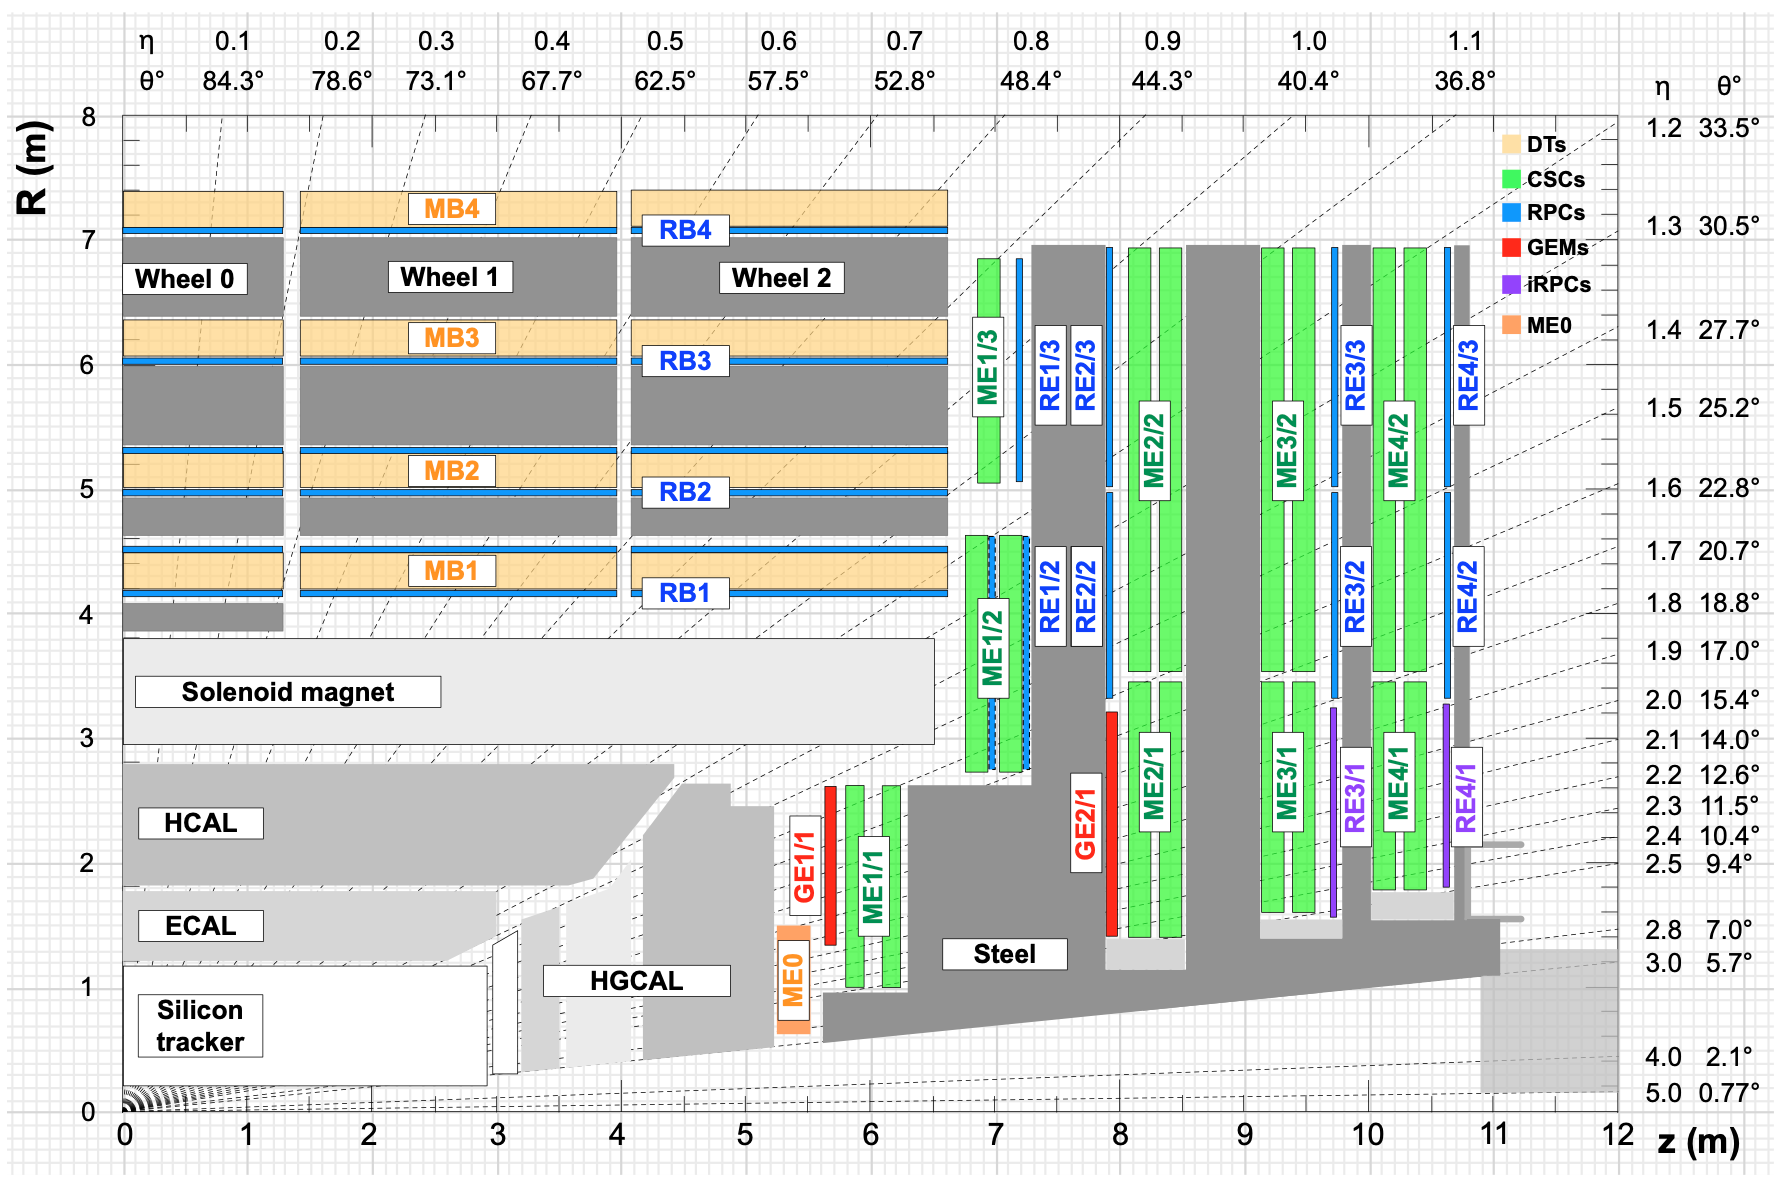

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from collections import namedtuple
import math
import h5py
import random 
import logging
from scipy.sparse import csr_matrix, find
import matplotlib.pyplot as plt
from google.colab import drive

# Mount google drive on remote Colab machine
drive.mount('/content/gdrive', force_remount=False)
sys.path.append('gdrive/My Drive/Colab Notebooks')

!ls 'gdrive/My Drive/Colab Notebooks/Data'
data_dir = 'gdrive/My Drive/Colab Notebooks/Data'

# Input and Output files and events to read
infile_mu   = data_dir+'/ntuple_SingleMuon_Endcap_9.root'
infile_pu = data_dir+'/ntuple_SingleNeutrino_PU200_63.root' 
outfile = data_dir+'/graphs.npz'
events_start=0
events_end=100


# Install uproot
!pip install uproot
import uproot

#!pip install ipynb
#!pip install import_ipynb



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
_about.txt	   graphs		  ntuple_qqH_ZZ4mu.root
bolsas_astro.txt   jet_images.h5	  ntuple_SingleMuon_Endcap_9.root
bolsas_fisica.txt  model_best.pt	  ntuple_SingleNeutrino_PU200_63.root
events.root	   ntuple_bkg_ZZ4mu.root  VBFHZZ_background.csv
GOOG.csv	   ntuple_ggH_ZZ4mu.root  VBFHZZ_signal.csv


## Define Globals and Utility Functions

In [0]:
# Event dataframe


# Event VARS from Root tree and HITVARS
VARS = ['ve_event','vh_size','vh_type', 'vh_sector', 'vh_station', 'vh_ring','vh_chamber','vh_sim_r','vh_sim_phi','vh_sim_z', 'vh_sim_eta', 'vh_sim_theta','vh_bend','vh_sim_tp1','vh_sim_tp2']
HITVARS = ['vh_type','vh_sector', 'vh_station', 'vh_ring','vh_sim_r','vh_sim_phi','vh_sim_z', 'vh_sim_eta', 'vh_sim_theta','vh_bend','vh_sim_tp1','vh_sim_tp2']

# Segments filter cuts
phi_slope_min = 0.
phi_slope_max = 0.0006
z0_max = 1000.

# Graph is a namedtuple of (X, Ri, Ro, y) for convenience
feature_names = ['vh_sim_r', 'vh_sim_phi', 'vh_sim_z','isMuon']
#feature_scale = np.array([1000., 180. / 6., 1000.])
feature_scale = np.array([1000., 180. / 6., 1000.,1.])
Graph = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y'])

# Sparse graph uses the indices for the Ri, Ro matrices
SparseGraph = namedtuple('SparseGraph',['X', 'Ri_rows', 'Ri_cols', 'Ro_rows', 'Ro_cols', 'y'])

def graph_to_sparse(graph):
    Ri_rows, Ri_cols = graph.Ri.nonzero()
    Ro_rows, Ro_cols = graph.Ro.nonzero()
    return dict(X=graph.X, y=graph.y,
                Ri_rows=Ri_rows, Ri_cols=Ri_cols,
                Ro_rows=Ro_rows, Ro_cols=Ro_cols)

def sparse_to_graph(X, Ri_rows, Ri_cols, Ro_rows, Ro_cols, y, dtype=np.uint8):
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ro = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1
    return Graph(X, Ri, Ro, y)



# Muon hit type
#kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

# Number of Muon PHI sectors 
nsectors=6

# MUON Detector layers 
nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)

# List of Forward Muon detector layer IDs 
csc_layers  = [ 2 , 3 , 7 , 8 , 10 ]
csc_rpc_layers  = [ 2 , 3 , 4 , 5 , 7 , 8 , 9, 10, 11 ]
muon_layers = [ 0, 1, 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 ]

# EMTF hit layer number
#emtf_lut = np.zeros((5,5,5), dtype=np.int32) - 99
#emtf_lut[1,1,4] = 0  # ME1/1a
#emtf_lut[1,1,1] = 0  # ME1/1b
#emtf_lut[1,1,2] = 1  # ME1/2
#emtf_lut[1,1,3] = 1  # ME1/3
#emtf_lut[1,2,1] = 2  # ME2/1
#emtf_lut[1,2,2] = 2  # ME2/2
#emtf_lut[1,3,1] = 3  # ME3/1
#emtf_lut[1,3,2] = 3  # ME3/2
#emtf_lut[1,4,1] = 4  # ME4/1
#emtf_lut[1,4,2] = 4  # ME4/2
#emtf_lut[2,1,2] = 5  # RE1/2
#emtf_lut[2,2,2] = 6  # RE2/2
#emtf_lut[2,3,1] = 7  # RE3/1
#emtf_lut[2,3,2] = 7  # RE3/2
#emtf_lut[2,3,3] = 7  # RE3/3
#emtf_lut[2,4,1] = 8  # RE4/1
#emtf_lut[2,4,2] = 8  # RE4/2
#emtf_lut[2,4,3] = 8  # RE4/3
#emtf_lut[3,1,1] = 9  # GE1/1
#emtf_lut[3,2,1] = 10 # GE2/1
#emtf_lut[4,1,1] = 11 # ME0

emtf_lut[1,1,4] = 2  # ME1/1a
emtf_lut[1,1,1] = 2  # ME1/1b
emtf_lut[1,1,2] = 3  # ME1/2
emtf_lut[1,1,3] = 3  # ME1/3
emtf_lut[1,2,1] = 7  # ME2/1
emtf_lut[1,2,2] = 7  # ME2/2
emtf_lut[1,3,1] = 8  # ME3/1
emtf_lut[1,3,2] = 8  # ME3/2
emtf_lut[1,4,1] = 10  # ME4/1
emtf_lut[1,4,2] = 10  # ME4/2
emtf_lut[2,1,2] = 4  # RE1/2
emtf_lut[2,2,2] = 5  # RE2/2
emtf_lut[2,3,1] = 9  # RE3/1
emtf_lut[2,3,2] = 9  # RE3/2
emtf_lut[2,3,3] = 9  # RE3/3
emtf_lut[2,4,1] = 11  # RE4/1
emtf_lut[2,4,2] = 11  # RE4/2
emtf_lut[2,4,3] = 11  # RE4/3
emtf_lut[3,1,1] = 1  # GE1/1
emtf_lut[3,2,1] = 6 # GE2/1
emtf_lut[4,1,1] = 0 # ME0

# Get layer function
def get_layer(dtype, station, ring):
  layer = emtf_lut[dtype.astype(int),station.astype(int),ring.astype(int)] 
  return layer

def muon_layer(dtype, station, ring):
  layer = emtf_lut[dtype.astype(int),station.astype(int),ring.astype(int)] 
  return layer

# Delta phi function
def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi

# Draw graphs function
def draw_sample(X, Ri, Ro, y): 
    # Select the i/o node features for each segment    
    # Prepare the figure
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,12))
    cmap = plt.get_cmap('bwr_r')

    # HITS features 
    R=X[:,0]
    Phi=(np.pi/180.)*X[:,1]
    Z=X[:,2]
    XX=R*np.cos(Phi)
    YY=R*np.sin(Phi)


    # Draw the hits (R, Phi, Z)
#    ax0.scatter(XX,YY, c='k')
#    ax1.scatter(Z,R, c='k')
    clm=np.float32(X[:,3])
    ax0.scatter(XX,YY, s=100., c=cmap(clm))
    ax1.scatter(Z,R, s=100., c=cmap(clm))
    
    # Draw the segments
    idx_i = find(np.rot90(Ri))[1]
    idx_o = find(np.rot90(Ro))[1]
  
    R_i=X[idx_i,0]
    Phi_i=(np.pi/180.)*X[idx_i,1]
    Z_i=X[idx_i,2]
    X_i=R_i*np.cos(Phi_i)
    Y_i=R_i*np.sin(Phi_i)
  
    R_o=X[idx_o,0]
    Phi_o=(np.pi/180.)*X[idx_o,1]
    Z_o=X[idx_o,2]
    X_o=R_o*np.cos(Phi_o)
    Y_o=R_o*np.sin(Phi_o)

    print("Z_i=",Z_i)
    print("Z_o=",Z_o)
    

    for j in range(y.shape[0]):
#      if not y[j] : continue
      seg_args = dict(c=cmap(float(y[j])))
      ax0.plot([X_i[j], X_o[j]], [Y_i[j], Y_o[j]], '-', **seg_args)
      ax1.plot([Z_i[j], Z_o[j]], [R_i[j], R_o[j]], '-', **seg_args)

    # Adjust axes
    ax0.set_xlabel('$X$')
    ax0.set_ylabel('$Y$')
    ax1.set_xlabel('$Z$')
    ax1.set_ylabel('$R$')
    plt.tight_layout()
    plt.show()
#    plt.savefig("graph.png")


# Read EVENTS function

In [0]:
# Function that reads all EVENTS from input file sand sture it in dataframes 
def readEvents():

  # Load the DATA and store selected the Root tree variables into Pandas dataframe
  upfile_mu = uproot.open(infile_mu)
  upfile_pu = uproot.open(infile_pu)
  tree_mu = upfile_mu["ntupler"]["tree"] # dictionary of NumPy arrays
  tree_pu = upfile_pu["ntupler"]["tree"] # dictionary of NumPy arrays

  #upfile_mu.keys()
  #tree_mu.show()


  # Read ROOT trees into dataframes
  df_events_mu = tree_mu.pandas.df(VARS,flatten=False, entrystart=int(events_start), entrystop=int(events_end))
  df_events_pu = tree_pu.pandas.df(VARS,flatten=False, entrystart=int(events_start), entrystop=int(events_end))
  df_muon_vp   = tree_mu.pandas.df(['vp_pt','vp_eta'], entrystart=int(events_start), entrystop=int(events_end))

  # Return events dataframes
  return df_events_mu , df_events_pu , df_muon_vp

## Get HITS Function

In [0]:
# Function that builds a HITS dataframe per event containing all real muon hits and merge it with pileup hits
def getHits(event_mu,event_pu):

 # print("event_mu = ", event_mu.head())

  # Create a HITS dataframe for a given muon event 
  hits_mu = event_mu[HITVARS]        # create a DF containing only muon hits variables
  hits_mu_list = hits_mu.values.tolist()  # evaluate jagged arrays and transform to list or arrays DF ( trick for DF of jagged arrays )
  df_hits_mu = pd.DataFrame(hits_mu_list, index=hits_mu.index) # create a dataframe from a list of arrays
  df_hits_mu = df_hits_mu.transpose() # transpose dataframe to have hit variables as columns 

  # Get only true muon hits (use generator-level matching condition)!
  df_hits_mu = df_hits_mu[(df_hits_mu['vh_sim_tp1']==0) & (df_hits_mu['vh_sim_tp2']==0)]   

  # Create a HITS only dataframe for a given pileup event 
  hits_pu = event_pu[HITVARS]         # create a DF containing only pileup hits variables
  hits_pu_list = hits_pu.values.tolist()   # evaluate jagged arrays and transform to list or arrays DF ( trick for DF of jagged arrays )
  df_hits_pu = pd.DataFrame(hits_pu_list, index=hits_pu.index)   # create a dataframe from a list of arrays
  df_hits_pu = df_hits_pu.transpose() # transpose dataframe to have hit variables as columns

  # Add "isMuon" variable to dataframes
  df_hits_mu['isMuon'] = np.ones(len(df_hits_mu))
  df_hits_pu['isMuon'] = np.zeros(len(df_hits_pu))
  
  # Concatenate MUON and PU hits dataframes into a single hits dataframe
  df_hits = pd.concat([df_hits_mu, df_hits_pu],ignore_index=True) # merge muon and pileup hits
#  df_hits = df_hits_mu # only muon hits
 
  # Add hit layer info to dataframe
  df_hits['vh_layer'] = df_hits.apply(lambda row: get_layer(row['vh_type'], row['vh_station'], row['vh_ring']), axis=1)
 
  # Filter out hits without layer information
  #df_events_mu = df_events_mu[(df_events_mu["vh_layer"]>=0)]
  #df_events_pu = df_events_pu[(df_events_pu["vh_layer"]>=0)]

 # print("len(df_hits)=",len(df_hits))
 # print("df_hits head = ", df_hits.head(3) ) 

  # Add the muon event number to the hits dataframe ( hits history )
  evtid = event_mu['ve_event'][0]        # muon event number
  df_hits["evtid"]=evtid
 
  # Return the HITS dataframe 
  return df_hits
  

## Split HITS Function

In [0]:
# Split hits by detector PHI sector and detector sides  
def splitHits(df_hits):
     
  # List of of hits dataframes per sector 
  hits_sectors = []

  # Loop over detector sides (Z>0 and Z<0) 
  for zsign in [-1,1]:

    df_hits_side = df_hits[(df_hits["vh_sim_z"]*zsign>0)]
  
    # Loop over PHI sectors
    for i in range(1,nsectors+1):

      # Create a new dataframe containing only hits in a given sector
      df_hits_sec = df_hits_side[(df_hits_side['vh_sector']==i)].copy()

      # Reset dataframe hits index in each sector 
      df_hits_sec.reset_index(inplace=True, drop=True) 
     
      # Append to list 
      hits_sectors.append(df_hits_sec)

  # Return list of dataframes hits in each detector sector
  return hits_sectors



# Build SEGMENTS Function

In [0]:

# Function that builds SEGMENTS ( hit pairs ) using Hits dataframes. SEGMENTS are defined as consecutive hit pairs ordered LAYER numbers
def buildSegments(df_hits):


  # Order df_hits by layer and reindex
  df_hits.sort_values(by=['vh_layer'], inplace=True)
  df_hits.reset_index(inplace=True, drop=True)

#  print("df_hits = ")
  print(df_hits[['vh_layer', 'vh_type', 'vh_sector', 'vh_station','vh_sim_r','vh_sim_z']])
  
  segments= [] # list of segments

  # Choose the muon detectors to use
  #layers = csc_layers
  #layers = csc_rpc_layers
  layers = muon_layers

  # Create a list of consecutive(adjacent) detector layer pairs
  layer_pairs = [ [i,j] for i in layers for j in layers]
  adj_layer_pairs = [ x for x in layer_pairs if ( layers.index(x[0])+1 == layers.index(x[1]) ) ]
  print("adj_layer_pairs=",adj_layer_pairs)

  # Group hits dataframe by layer number
  hits_groups = df_hits.groupby("vh_layer")
#  print("hits_groups=",list(hits_groups))

  # Loop over adjacent CSC layers ID pairs  
  for l1,l2 in adj_layer_pairs:

#    print("layer1, layer2 = ",l1," , ",l2)

    # Group hits in consecutive layers  
    try:
      df_hits1 = hits_groups.get_group(l1)
      df_hits2 = hits_groups.get_group(l2)
    except KeyError as e:  
      logging.info('skipping empty layer: %s' % e)
#      print('skipping empty layer pair :', l1," , ",l2)
      continue

    # Reset index of the hits dataframes to have the 'old index' added as a dataframe column befor merging
    df_hits1.reset_index(inplace=True)
    df_hits2.reset_index(inplace=True)

    # Merge df_hits1 and df_hits2 in a single dataframe, adding the suffixes _1 and _2 to old labels
    # df_hit_pairs = pd.merge( df_hits1.reset_index(), df_hits2.reset_index(), how='inner', on='evtid', suffixes=('_1', '_2'))
    # df_hit_pairs = pd.merge( df_hits1.reset_index(), df_hits2.reset_index(), on='evtid', suffixes=('_1', '_2'))
    df_hit_pairs = pd.merge( df_hits1.reset_index(), df_hits2.reset_index(), how='outer', on='evtid', suffixes=('_1', '_2'))
  
    # Compute line segment through the hits
    dphi = calc_dphi(df_hit_pairs.vh_sim_phi_1, df_hit_pairs.vh_sim_phi_2)
    dz = df_hit_pairs.vh_sim_z_2 - df_hit_pairs.vh_sim_z_1
    dr = df_hit_pairs.vh_sim_r_2 - df_hit_pairs.vh_sim_r_1
    phi_slope = dphi / dr
    z0 = df_hit_pairs.vh_sim_z_1 - df_hit_pairs.vh_sim_r_1 * dz / dr
  
    # Discard individual hits variables and add segments( hit pairs ) variables 
    df_hit_pairs = df_hit_pairs[['evtid', 'index_1', 'index_2', 'vh_layer_1', 'vh_layer_2']].assign(dphi=dphi, dz=dz, dr=dr, phi_slope=phi_slope, z0=z0)

    # Filter segments according to criteria
    #sel_mask = (phi_slope.abs() < phi_slope_max) & (z0.abs() < z0_max)
    #sel_mask = (((phi_slope.abs() < phi_slope_max) & (df_hit_pairs.layer_1[0] < 5)) | ((phi_slope.abs() < phi_slope_outer_max) & (df_hit_pairs.layer_1[0] >= 5))) & (z0.abs() < z0_max)  
    sel_mask = ((df_hit_pairs.phi_slope.abs() > phi_slope_min) &
                (df_hit_pairs.phi_slope.abs() < phi_slope_max) &
                (df_hit_pairs.z0.abs() < z0_max))
    #df_hit_pairs.assign(selected=sel_mask)

    #df_hit_pairs=df_hit_pairs[sel_mask]

    # Create a hit pairs dataframe in segments list
    segments.append(df_hit_pairs)
 
   # End loop over segment pairs 

  # Create an all events segments dataframe from list of dataframes of event segments
  df_segments = pd.DataFrame()
  if ( len(segments) > 0 ) :  
    df_segments = pd.concat(segments, ignore_index=True)
    print("len(segments)=",len(segments) )
    print("df_segments=",df_segments[['index_1', 'index_2', 'vh_layer_1', 'vh_layer_2', 'phi_slope', 'z0']])

#    print(" ")
#    print("------------------------------------------------------------------------------------------- ")
#    print(" ")

  # Return modified df_hits and df_segments dataframes
  return df_segments


################################################################################################################################


#def segment_efficiency(df_segments):
#    return (df_segments.y & df_segments.selected).sum() / df_segments.y.sum()
#
#def segment_purity(df_segment):
#    return (df_segments.y & df_segments.selected).sum() / df_segments.selected.sum()

## Build GRAPHS function

In [0]:
def buildGraph(df_hits,df_segments):

  # Get number of hits and segments in event
  n_hits = df_hits.shape[0]
  n_edges = df_segments.shape[0]

  # Prepare the GRAPH tensors( matrices )
  Ri = np.zeros((n_hits, n_edges), dtype=np.uint8)  # Adjacency matrix
  Ro = np.zeros((n_hits, n_edges), dtype=np.uint8)  # Adjacency matrix
  X = (df_hits[feature_names].values / feature_scale).astype(np.float32)  # features
  y = np.zeros(n_edges, dtype=np.float32)           # labels for SEGMENTS classification
  
#  y = np.zeros(n_hits, dtype=np.float32)           # labels for HITS classification

  # We have the segments and need to get hits positional indices in the df_hits dataframe
  # Use a series (hit_idx) to map df_hits indices onto df_segments hits indices.
  hit_idx = pd.Series(np.arange(n_hits), index=df_hits.index)
  start_idx = hit_idx.loc[df_segments.index_1].values
  end_idx = hit_idx.loc[df_segments.index_2].values

  # Now we can fill the association matrices.
  # Note that Ri maps hits onto their incoming edges,
  # which are actually segment endings.
  Ri[start_idx, np.arange(n_edges)] = 1
  Ro[end_idx, np.arange(n_edges)] = 1
  
 # For HITS classification fill the hits labels
 # pid1 = df_hits.isMuon.loc[df_segments.index_1].values
 # y[:] = [i for i in pid1]

  # For SEGMENT classification fill the segment labels ( for muon segments label1=label2=1 )
  label1 = df_hits.isMuon.loc[df_segments.index_1].values
  label2 = df_hits.isMuon.loc[df_segments.index_2].values
  y[:] = [(i and j) for i, j in zip(label1, label2)]

#  print("n_hits=",n_hits)
#  print("n_edges=",n_edges)
#  print("start hit index =",start_idx)
#  print("end hit index=",end_idx)
#  print("df_hits=",df_hits[['evtid','vh_layer','vh_sector','vh_sim_r','vh_sim_phi','vh_sim_z']])
#  print("df_segments.index_1=",df_segments.index_1)
#  print("df_segments.index_2=",df_segments.index_2)
#  print("pid1=",pid1)
#  print("pid2=",pid2)
#  print("y=",y)
#  print('Graph X,Ri,Ro,Y shapes:', X.shape , Ri.shape , Ro.shape , y.shape)
#   
#  print(" ")
#  print("---------------------------------------------- ")
#  print(" ")

  
  # Return a GRAPH (named tuple)
  return Graph(X, Ri, Ro, y)


## MAIN program


Initializing random seed=1
Event= 0    Sector= 1
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         1      1.0        1.0         1.0  294.153351  -684.285217
1         7      2.0        1.0         3.0  233.935410  -968.900024
2         8      2.0        1.0         4.0  247.522552 -1059.395020
3         8      2.0        1.0         4.0  201.180313 -1059.395020
4         8      2.0        1.0         4.0  207.527542 -1054.994995
5        11      4.0        1.0         1.0   82.369797  -539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 1
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope           z0
0        1        2           7           8  -0.200108   589.189401
1        1        3           7           8  -0.150056 -1615.211165
2        1        4           7           8   1.654456 -1731.576612
Event= 0    Sector= 1
Z_i= [-968.90002489 -968.90002489 -

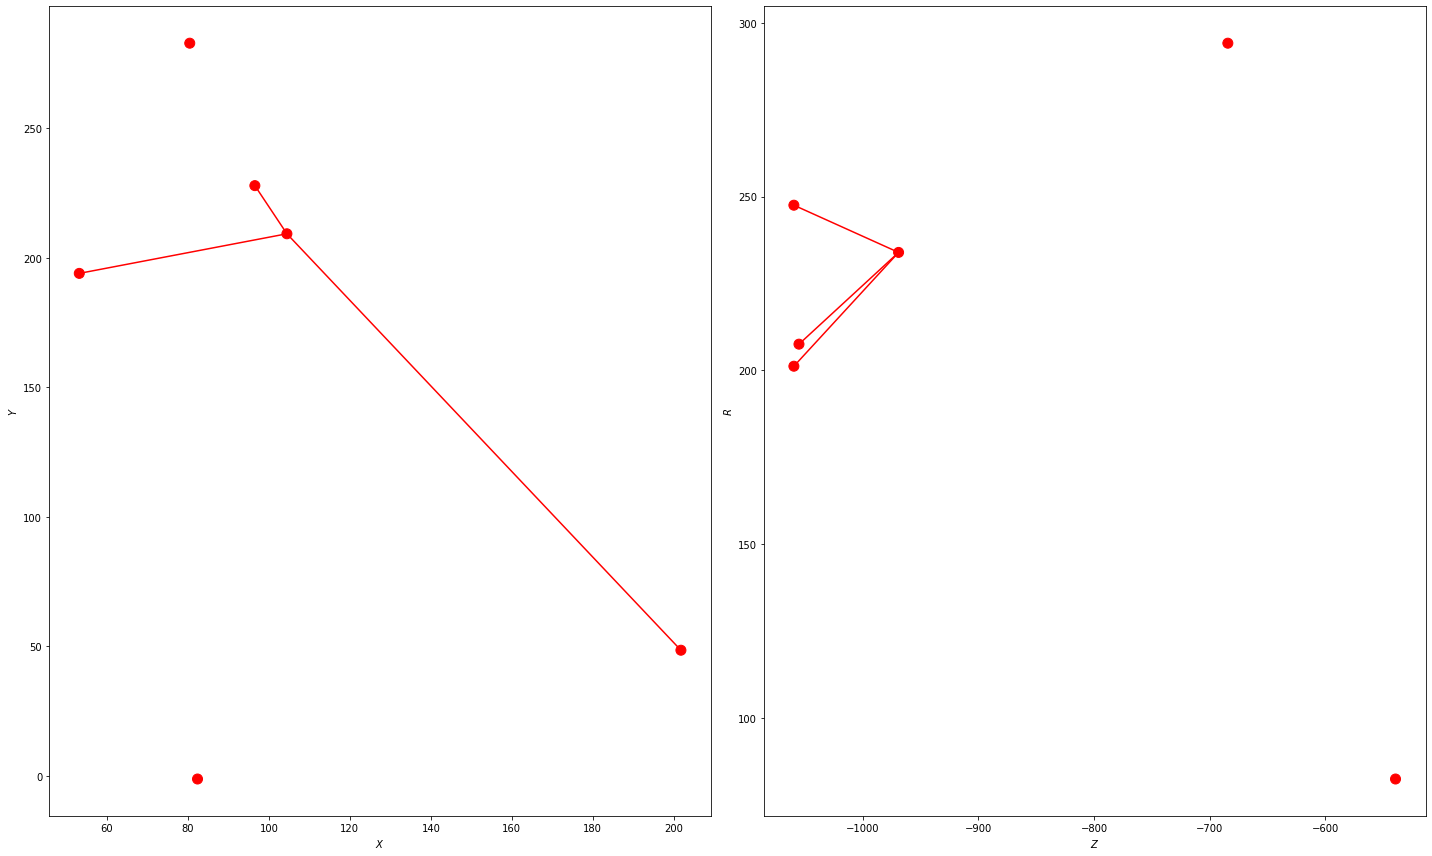

Event= 0    Sector= 2
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0       -99      0.0        2.0         1.0  447.434326  -533.325684
1         0      1.0        2.0         1.0  154.245636  -615.631409
2         0      1.0        2.0         1.0   98.584114  -615.747742
3         1      1.0        2.0         1.0  301.002869  -711.712585
4         1      1.0        2.0         1.0  294.153351  -684.285217
5         7      2.0        2.0         3.0  233.935410  -968.900024
6         7      2.0        2.0         3.0  163.932938  -968.900024
7         8      2.0        2.0         4.0  247.522552 -1059.395020
8         8      2.0        2.0         4.0  201.180313 -1059.395020
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 2
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope           z0
0        1        3           0           1  -0.244755  -514.647614
1        1   

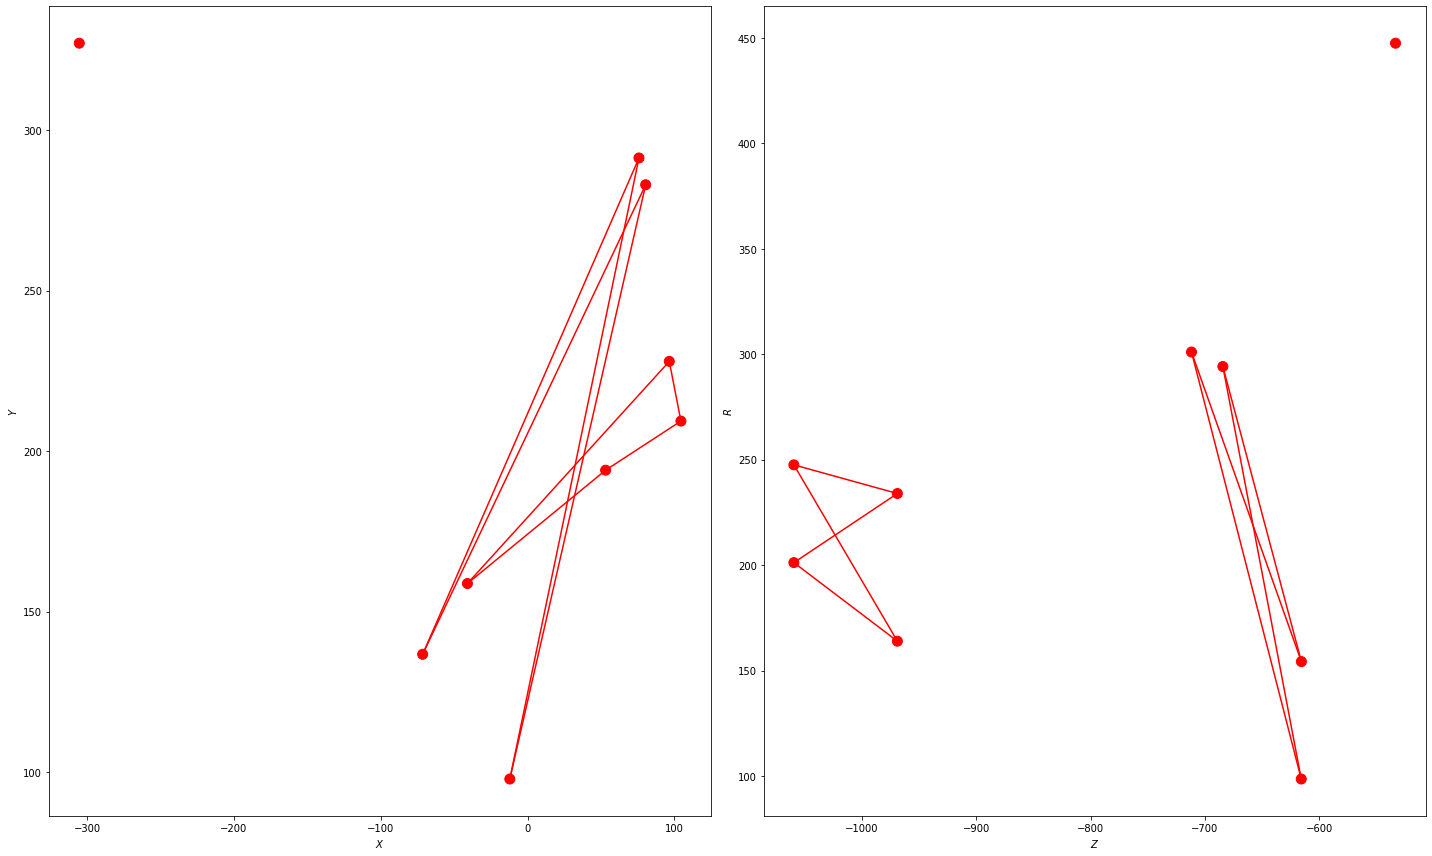

Event= 0    Sector= 3
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0       -99      0.0        3.0         1.0  447.434326 -533.325684
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 0    Sector= 4
   vh_layer  vh_type  vh_sector  vh_station   vh_sim_r    vh_sim_z
0        11      4.0        4.0         1.0  83.574287 -539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 0    Sector= 5
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        5.0         1.0  133.580124 -615.710938
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 0    Sector= 6
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        6.0         1.0  178.091965  -615.687500
1         0      1.0        6.0         1

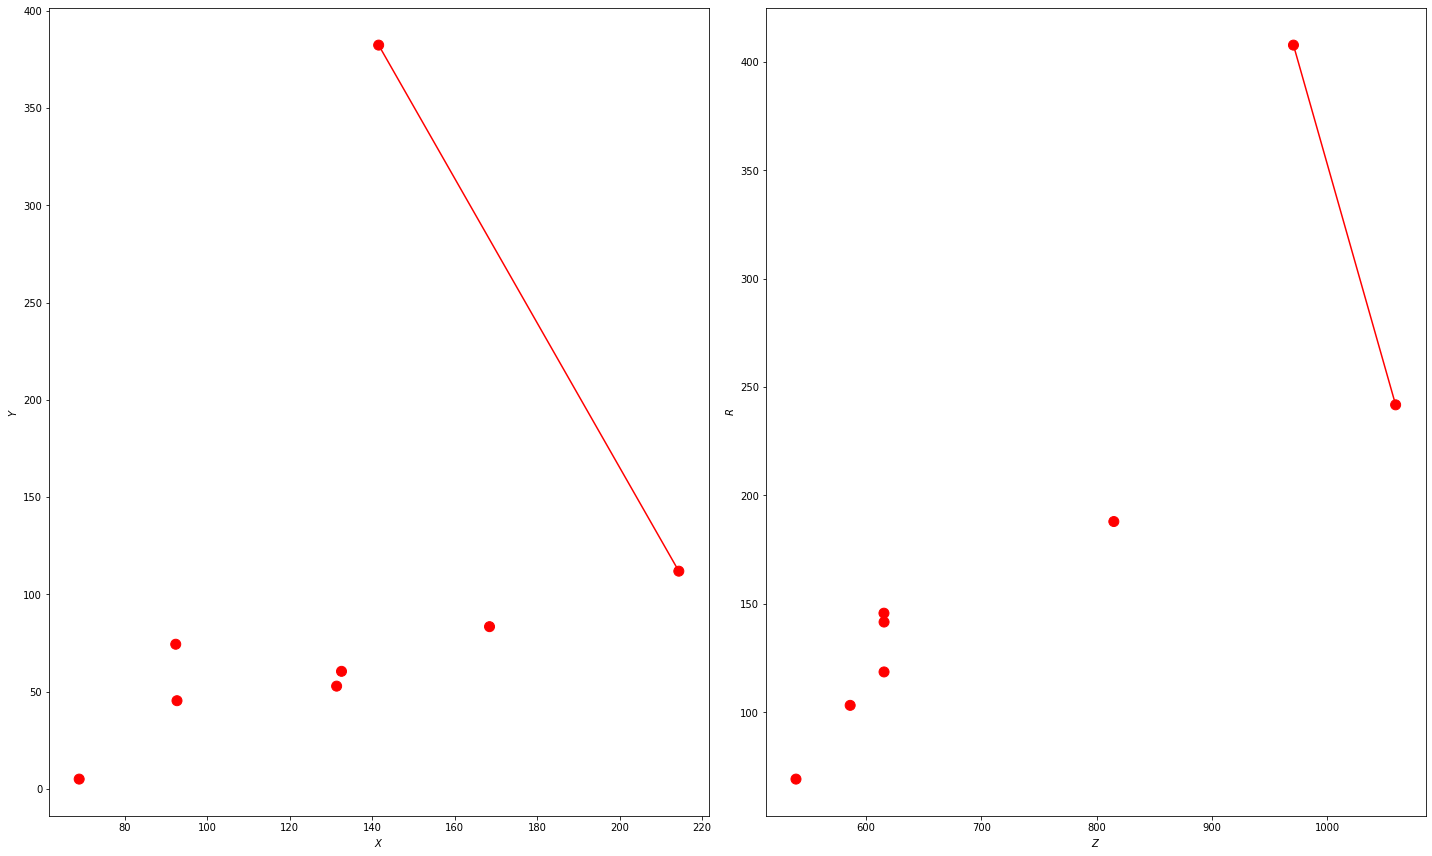

Event= 0    Sector= 8
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        2.0         1.0  199.915573   615.763672
1         0      1.0        2.0         1.0  131.674622   586.434814
2         0      1.0        2.0         1.0  128.943863   586.534119
3         0      1.0        2.0         1.0  128.902512   586.351868
4         2      1.0        2.0         2.0  220.864975   839.956360
5         7      2.0        2.0         3.0  407.756104   970.799988
6         8      2.0        2.0         4.0  356.190277  1061.295044
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 1
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope          z0
0        5        6           7           8  -0.611363  1686.38847
Event= 0    Sector= 8
Z_i= [970.79998255]
Z_o= [1061.2950325]


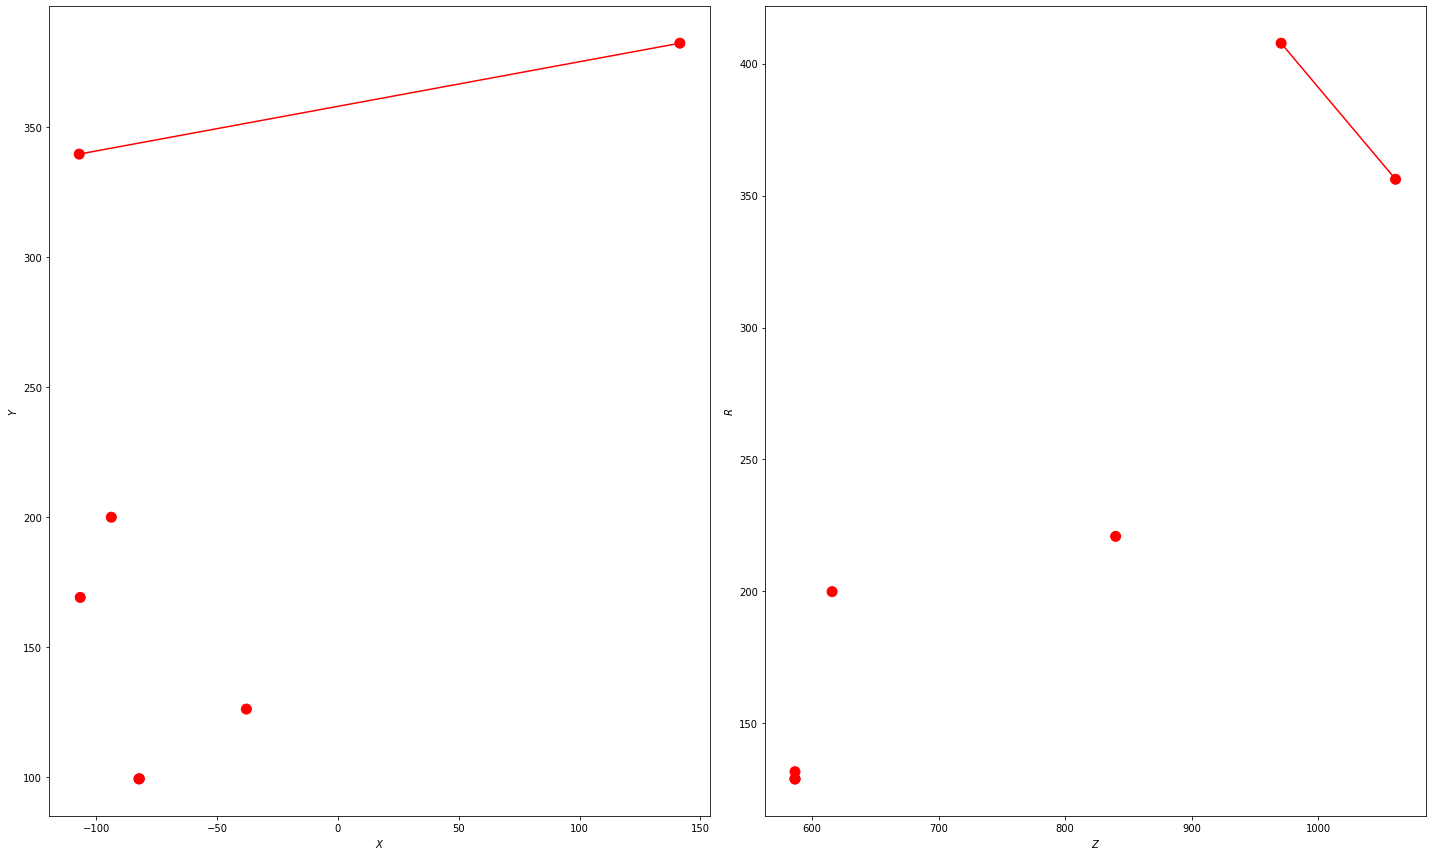

Event= 0    Sector= 9
    vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0        -99      0.0        3.0         1.0  465.266327   533.338562
1          0      1.0        3.0         1.0  128.943863   586.534119
2          0      1.0        3.0         1.0  128.902512   586.351868
3          2      1.0        3.0         2.0  220.864975   839.956360
4          2      1.0        3.0         2.0  163.034332   815.022949
5          2      1.0        3.0         2.0  147.429352   815.028748
6          3      1.0        3.0         3.0  170.488358   948.716064
7          7      2.0        3.0         3.0  175.971283   968.900024
8          7      2.0        3.0         3.0  165.256180   968.900024
9          8      2.0        3.0         4.0  188.806503  1059.395020
10        11      4.0        3.0         1.0   83.040649   539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 2
df_segments=

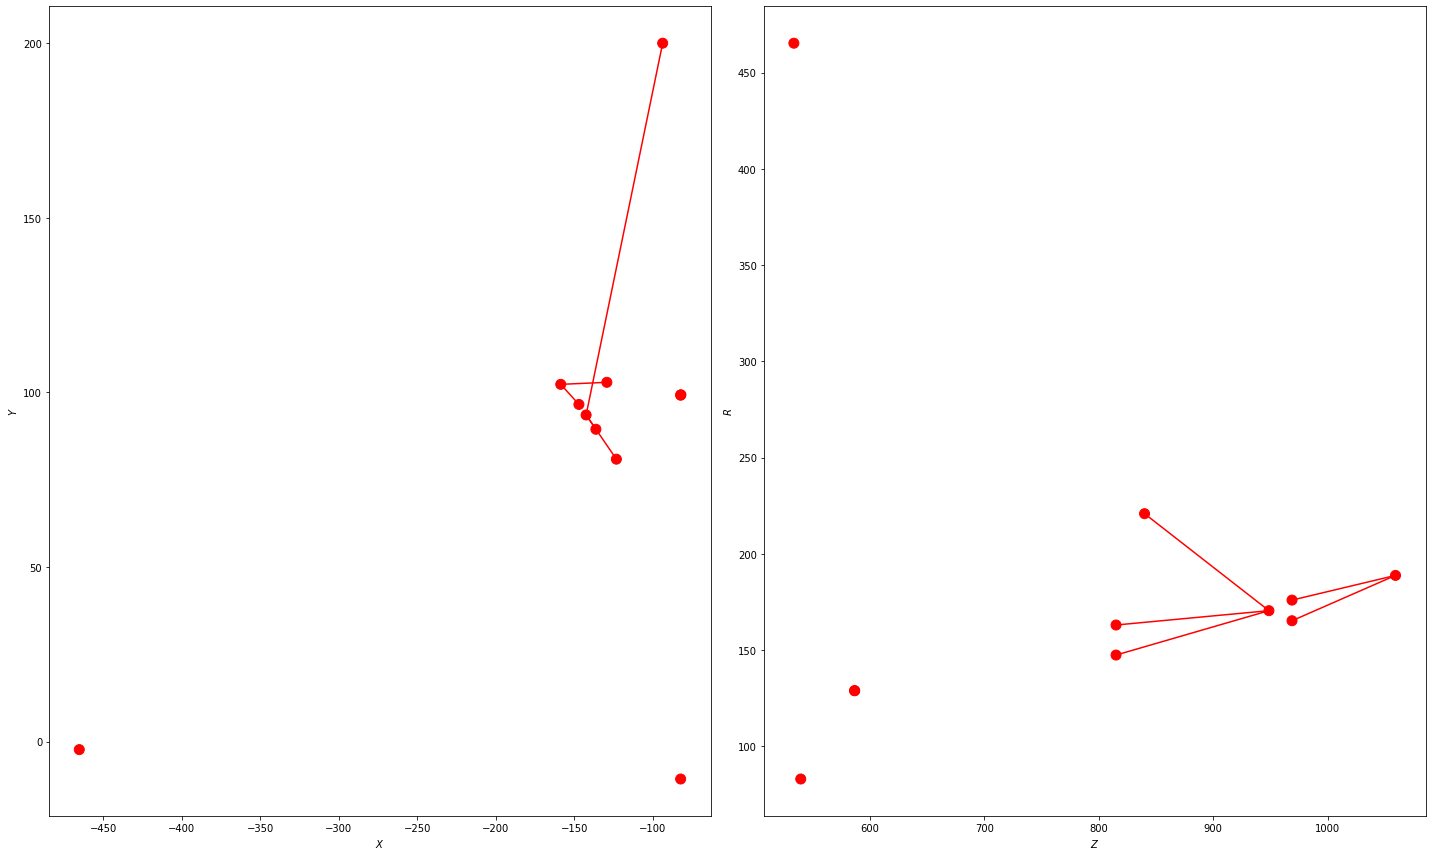

Event= 0    Sector= 10
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0       -99      0.0        4.0         1.0  465.266327  533.338562
1        11      4.0        4.0         1.0   83.040649  539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 0    Sector= 11
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        5.0         1.0  126.769089  586.353088
1         0      1.0        5.0         1.0  239.242264  615.758301
2         0      1.0        5.0         1.0  169.669510  615.799683
3         7      2.0        5.0         3.0  204.733185  964.500000
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 0    Sector= 12
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        6.0         1.0   97.576424   615.832214
1         0      1.0        6.0

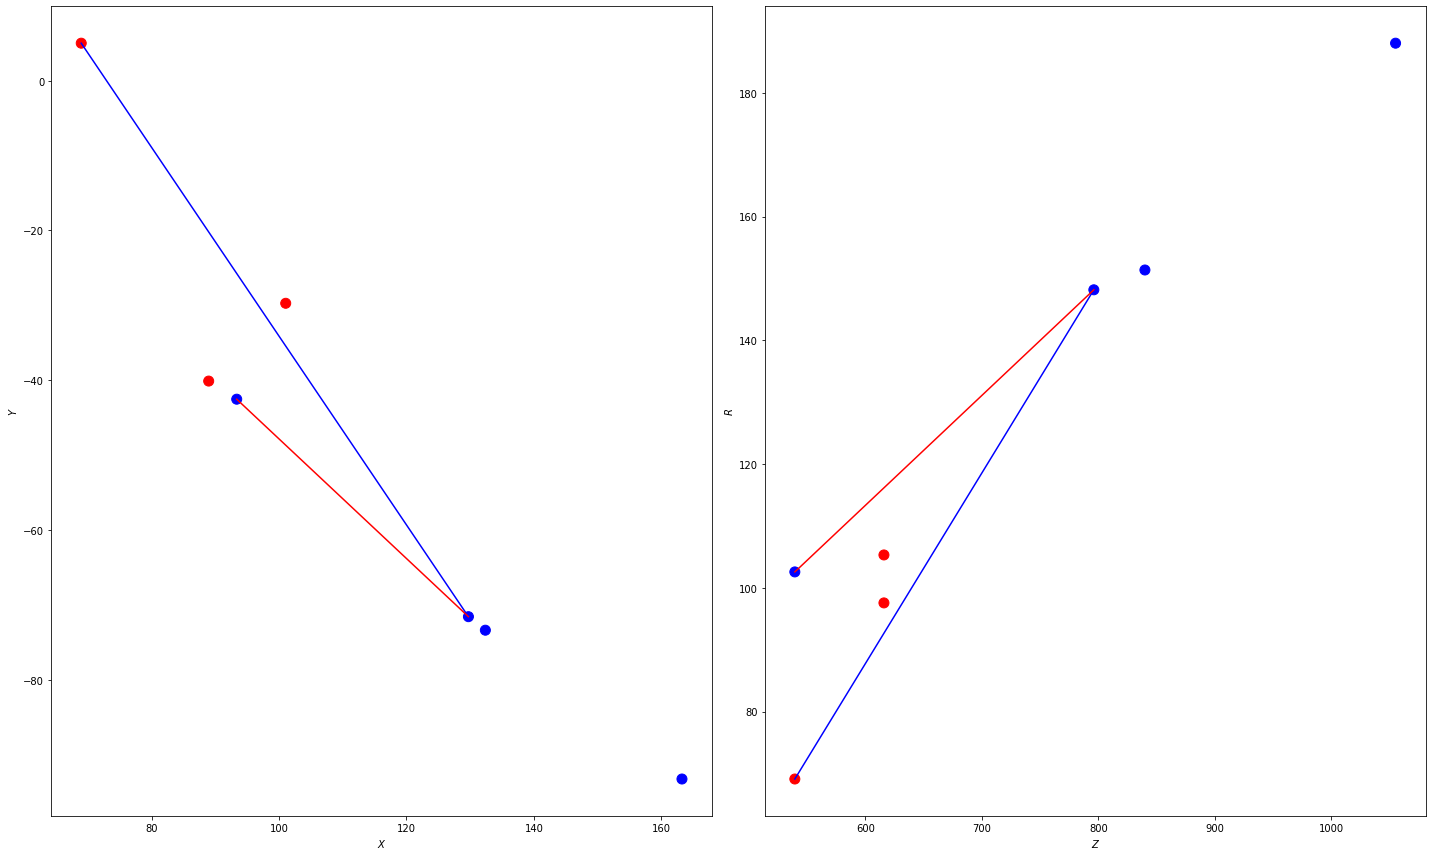

Event= 1    Sector= 1
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        1.0         1.0  152.255936  -586.445557
1         2      1.0        1.0         2.0  200.454987  -814.854553
2         3      1.0        1.0         3.0  227.343964  -948.882019
3         4      1.0        1.0         4.0  244.873901 -1038.195679
4         7      2.0        1.0         3.0  193.777954  -968.900024
5         7      2.0        1.0         3.0  178.318817  -968.900024
6         7      2.0        1.0         3.0  230.230087  -968.900024
7         8      2.0        1.0         4.0  250.055618 -1059.395020
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 3
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope          z0
0        1        2           2           3  -0.064336  184.308554
1        2        3           3           4  -0.152194  209.417668
2        4       

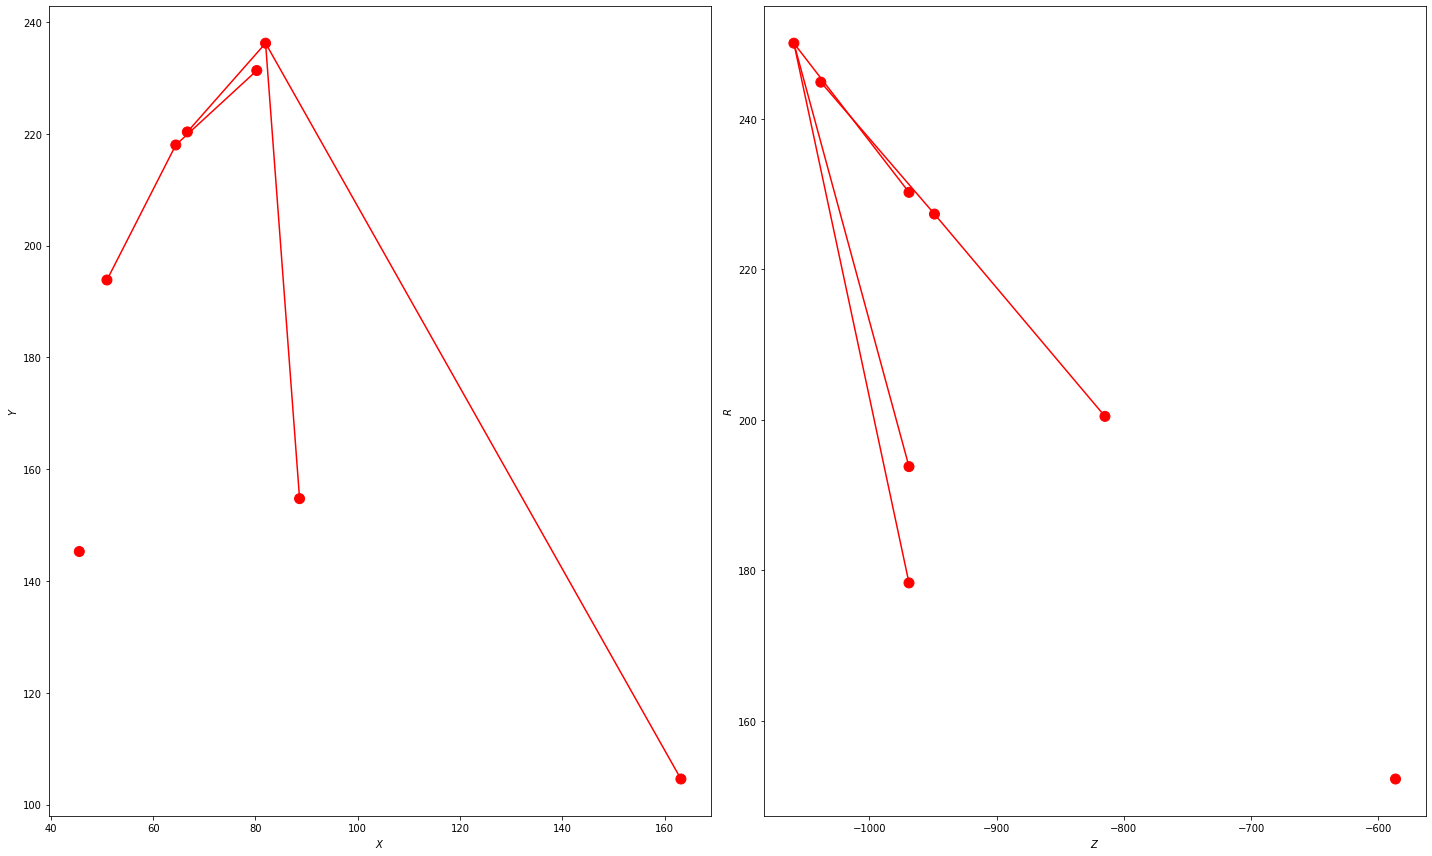

Event= 1    Sector= 2
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        2.0         1.0  152.255936  -586.445557
1         2      1.0        2.0         2.0  200.454987  -814.854553
2         3      1.0        2.0         3.0  227.343964  -948.882019
3         4      1.0        2.0         4.0  244.873901 -1038.195679
4         7      2.0        2.0         3.0  178.318817  -968.900024
5         7      2.0        2.0         3.0  230.230087  -968.900024
6         8      2.0        2.0         4.0  224.413422 -1059.395020
7         8      2.0        2.0         4.0  250.055618 -1059.395020
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 3
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope           z0
0        1        2           2           3  -0.064336   184.308554
1        2        3           3           4  -0.152194   209.417668
2        4    

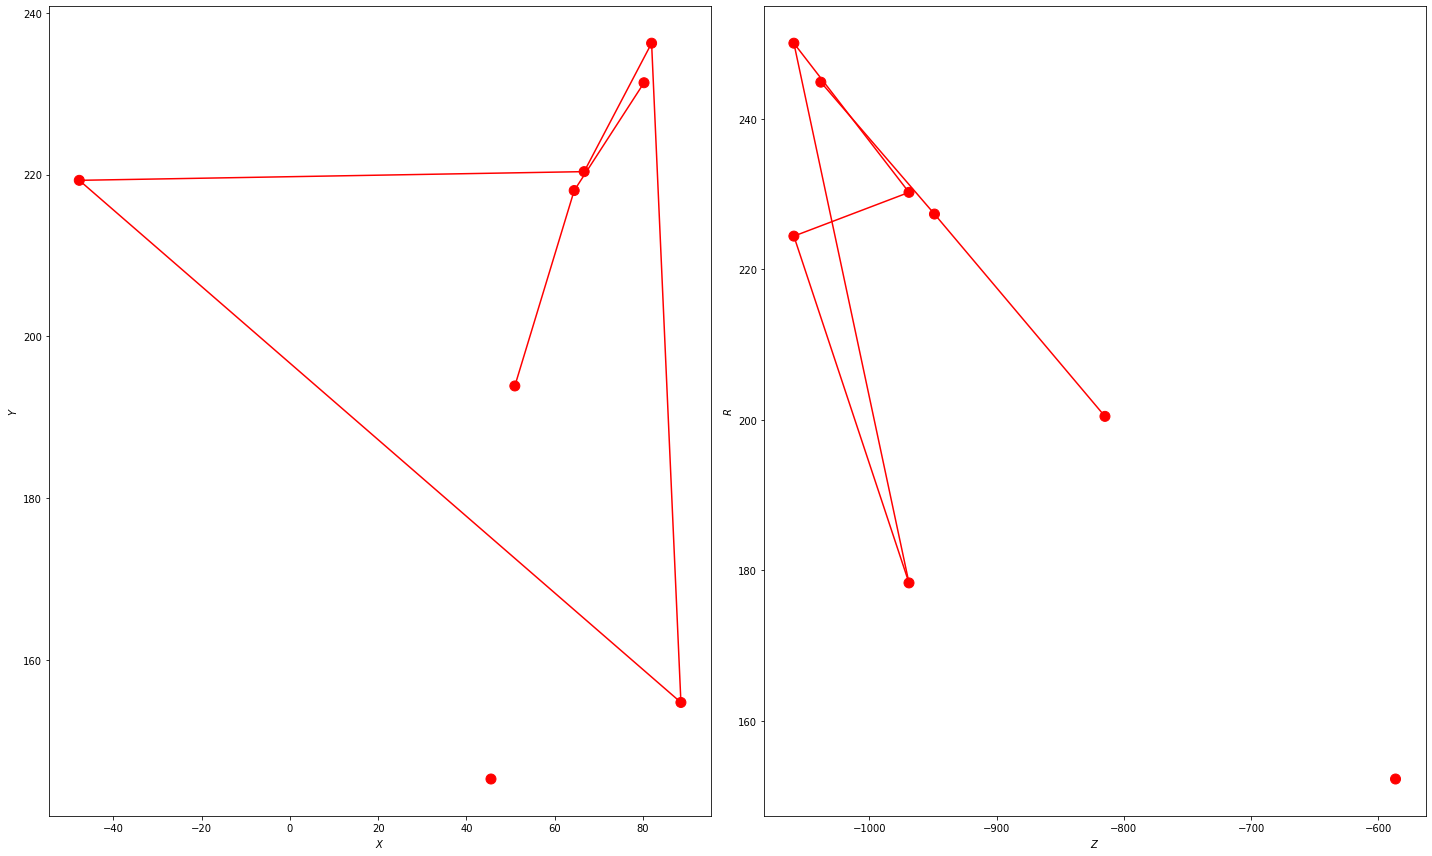

Event= 1    Sector= 3
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0       -99      0.0        3.0         1.0  447.505615 -533.421265
1         0      1.0        3.0         1.0  155.594101 -615.722839
2         0      1.0        3.0         1.0  158.630249 -615.710693
3         0      1.0        3.0         1.0  108.983376 -586.315918
4         0      1.0        3.0         1.0  105.909767 -586.434143
5        11      4.0        3.0         1.0   70.843063 -539.349976
6        11      4.0        3.0         1.0   66.260963 -539.349976
7        11      4.0        3.0         1.0   82.389709 -539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 1    Sector= 4
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0       -99      0.0        4.0         2.0  544.406738 -533.271912
1         0      1.0        4.0         1.0  154.517853 -586.375488
2         3      1.0        4.0

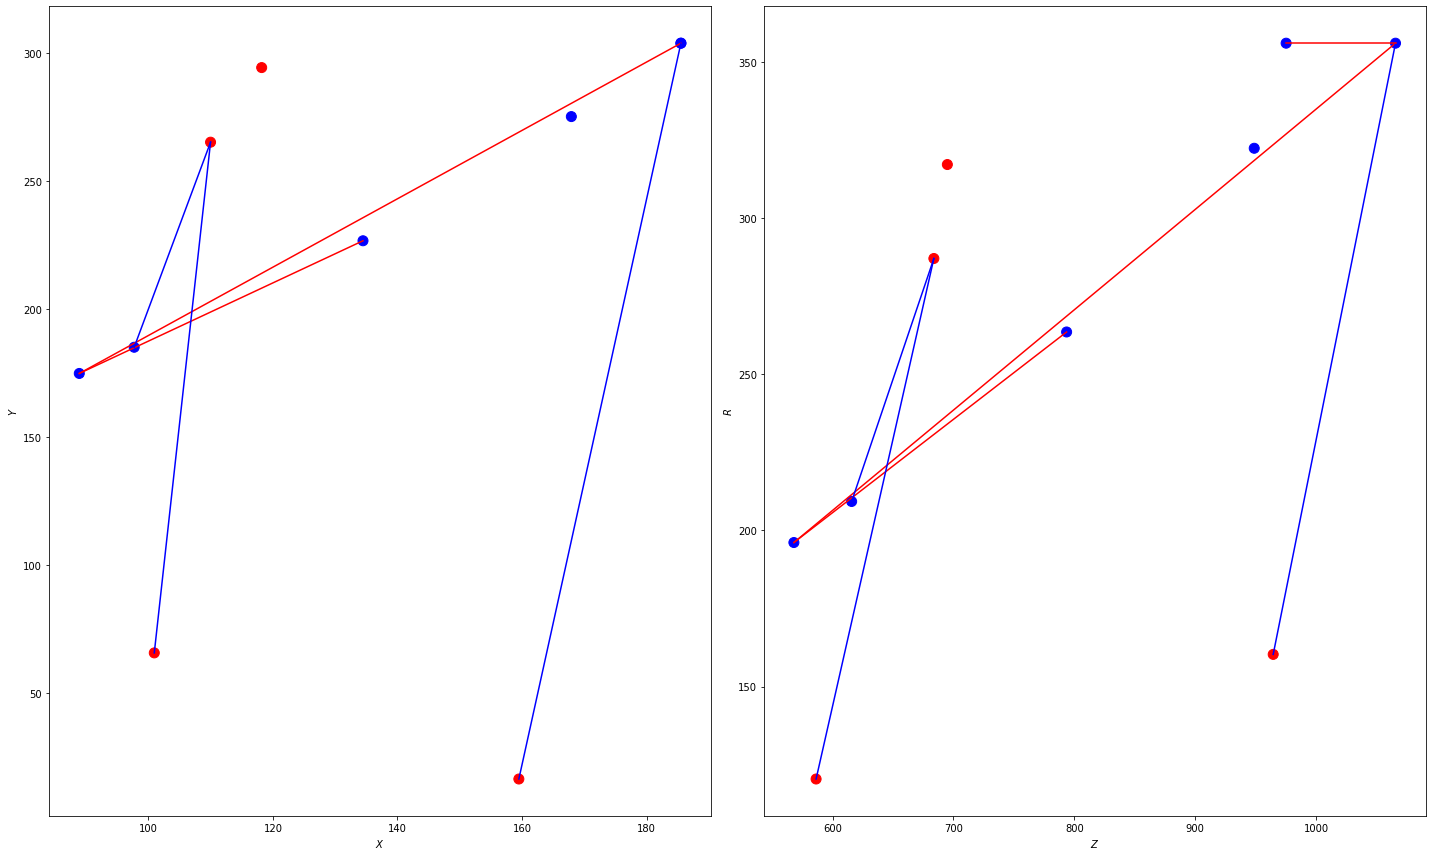

Event= 1    Sector= 8
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        2.0         1.0  135.761200  586.425049
1         0      1.0        2.0         1.0  215.549637  615.677063
2         1      1.0        2.0         1.0  287.047119  683.775574
3         2      1.0        2.0         2.0  152.496368  815.087830
4         3      1.0        2.0         3.0  322.326843  948.810364
5         5      2.0        2.0         1.0  317.121246  694.934570
6        10      3.0        2.0         2.0  263.528809  793.598755
7        11      4.0        2.0         1.0  102.638786  539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 4
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope          z0
0        0        2           0           1  -0.224563  499.064479
1        1        2           0           1  -0.588184  410.374599
2        2        3       

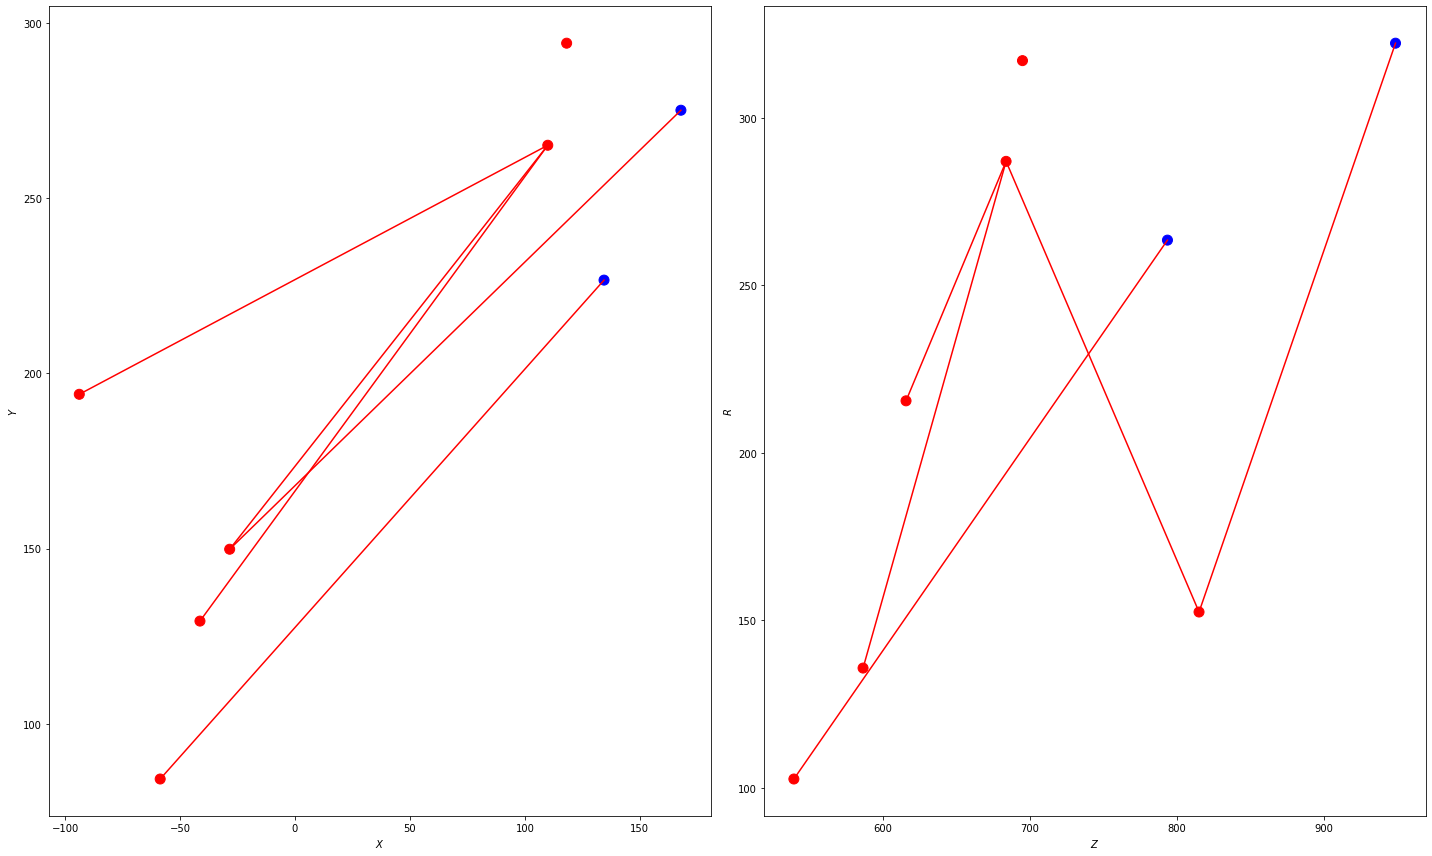

Event= 1    Sector= 9
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0        11      4.0        3.0         1.0  102.638786  539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 1    Sector= 10
   vh_layer  vh_type  vh_sector  vh_station   vh_sim_r    vh_sim_z
0         0      1.0        4.0         1.0  176.29155  586.488647
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 1    Sector= 11
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        5.0         1.0  126.548332  615.697266
1         0      1.0        5.0         1.0  131.066071  615.650635
2         0      1.0        5.0         1.0  124.677338  586.362000
3         2      1.0        5.0         2.0  160.654083  814.967407
4        11      4.0        5.0         1.0  114.121857  539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2

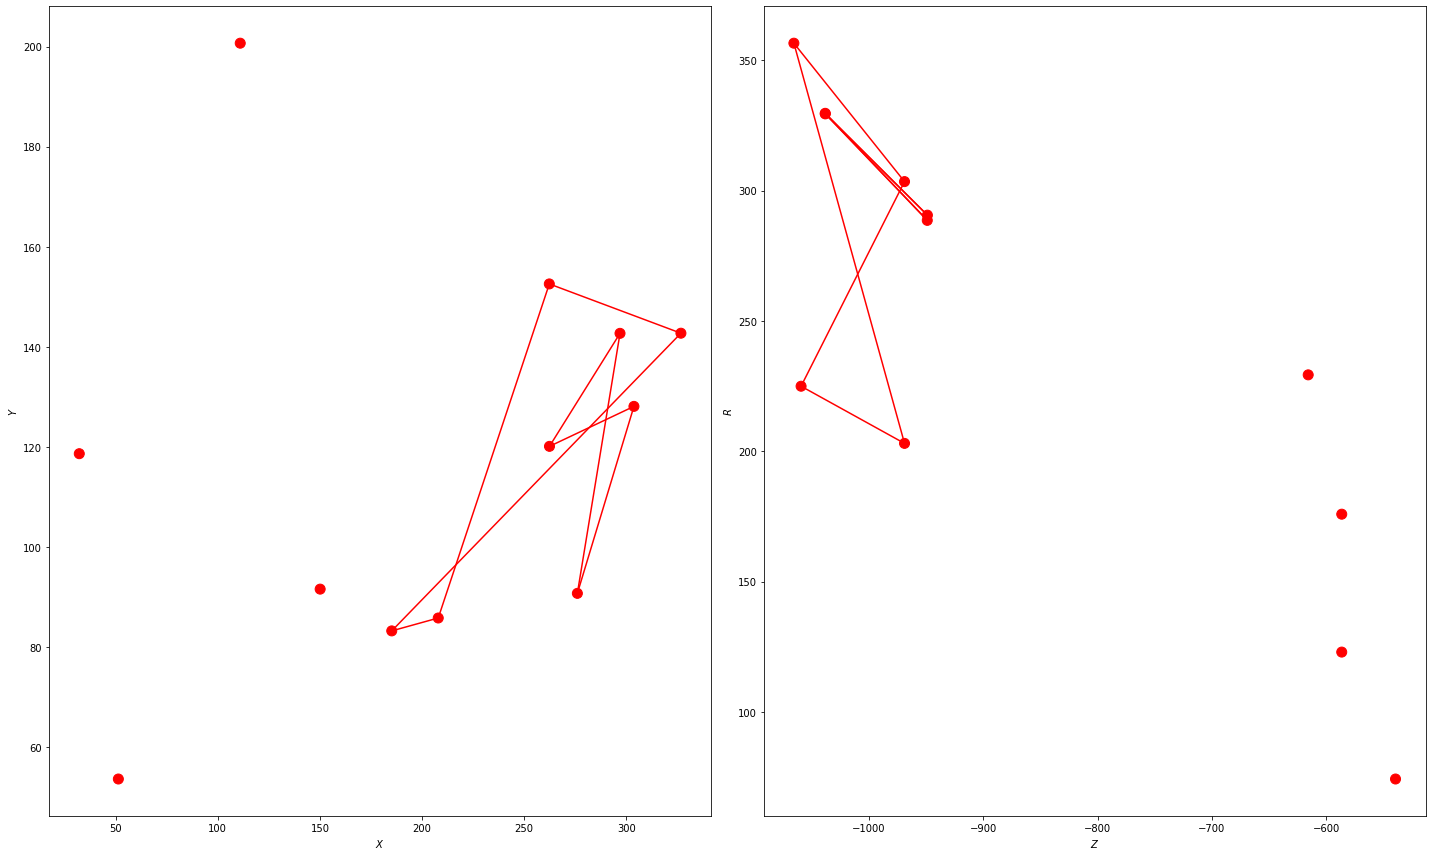

Event= 2    Sector= 2
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        2.0         1.0  122.954094  -586.40387
1         8      2.0        2.0         4.0  241.817368 -1059.39502
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 2    Sector= 3
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        3.0         1.0  184.502747 -586.351135
1         0      1.0        3.0         1.0   99.483139 -586.482788
2        11      4.0        3.0         1.0  102.835663 -539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 2    Sector= 4
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        4.0         1.0   99.483139 -586.482788
1         0      1.0        4.0         1.0  179.180130 -586.412048
2         0      1.0        4.0     

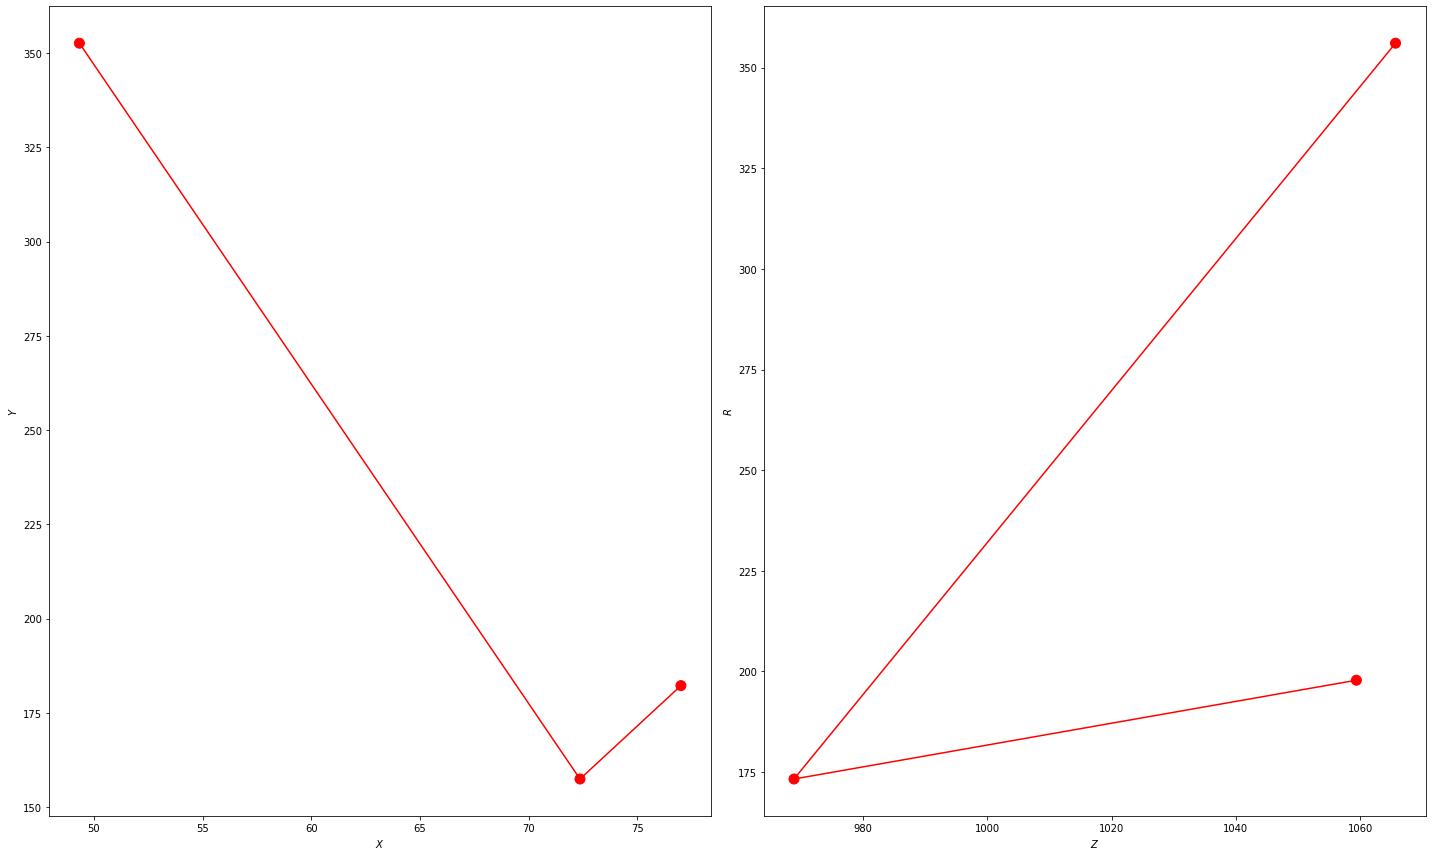

Event= 2    Sector= 9
    vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0          0      1.0        3.0         1.0  223.676468   586.325073
1          0      1.0        3.0         1.0  217.639969   586.332214
2          0      1.0        3.0         1.0  159.012573   586.455078
3          1      1.0        3.0         1.0  433.000946   711.265564
4          2      1.0        3.0         2.0  312.941040   815.135132
5          2      1.0        3.0         2.0  219.717407   839.858521
6          4      1.0        3.0         4.0  392.127838  1038.379761
7          4      1.0        3.0         4.0  266.840424  1013.733826
8          7      2.0        3.0         3.0  356.493073   970.799988
9          7      2.0        3.0         3.0  249.748352   964.500000
10         8      2.0        3.0         4.0  408.421478  1061.295044
11         8      2.0        3.0         4.0  283.092804  1054.994995
12         9      3.0        3.0         1.0  222.753204   565.36877

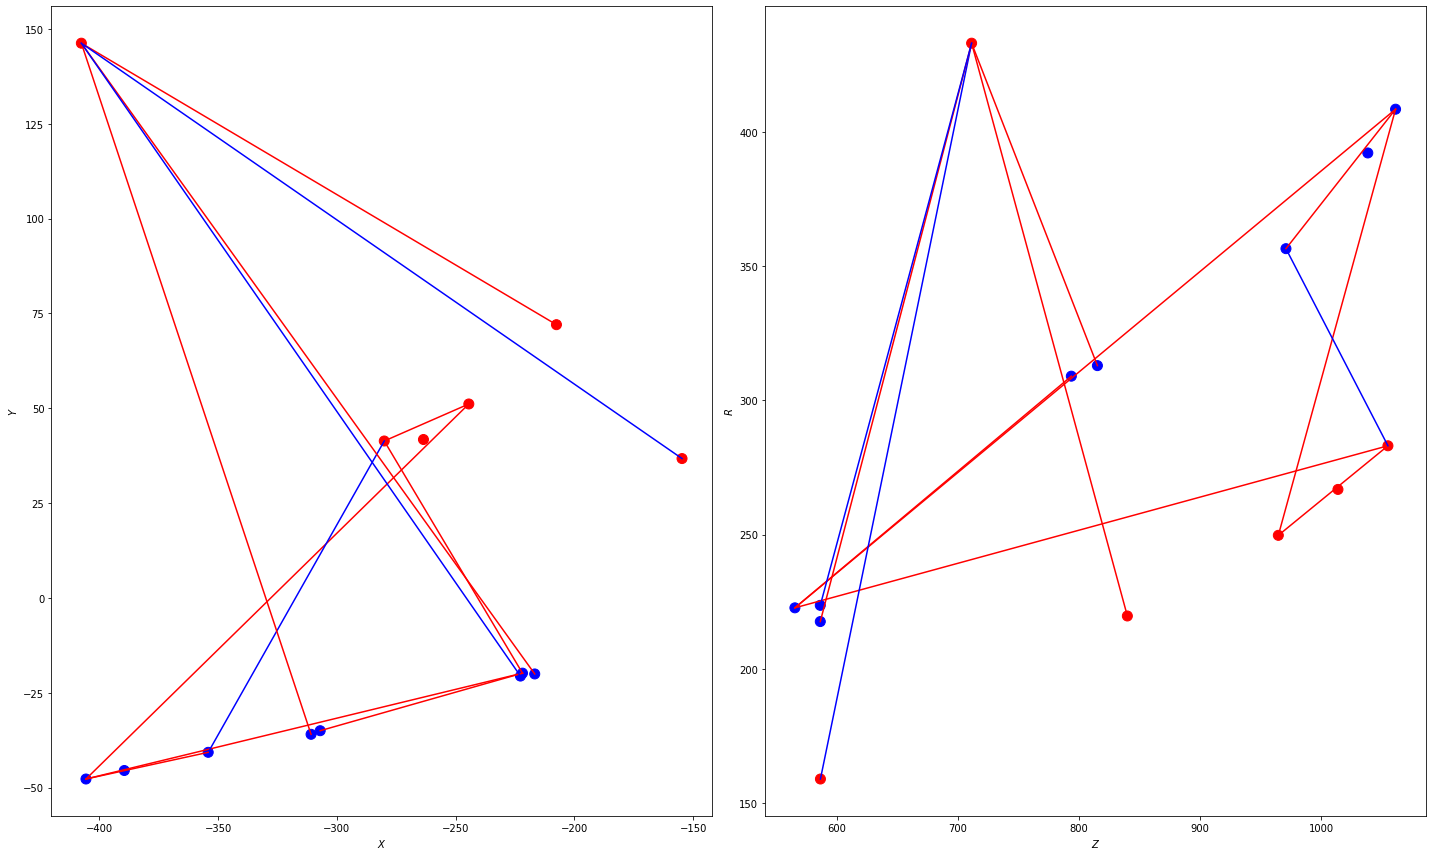

Event= 2    Sector= 10
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        4.0         1.0  223.676468   586.325073
1         0      1.0        4.0         1.0  217.639969   586.332214
2         0      1.0        4.0         1.0  246.270065   615.790344
3         2      1.0        4.0         2.0  312.941040   815.135132
4         4      1.0        4.0         4.0  392.127838  1038.379761
5         7      2.0        4.0         3.0  356.493073   970.799988
6         8      2.0        4.0         4.0  408.421478  1061.295044
7         9      3.0        4.0         1.0  222.753204   565.368774
8        10      3.0        4.0         2.0  309.011810   793.598755
9        11      4.0        4.0         1.0   82.392845   539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 4
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope          z0
0        5  

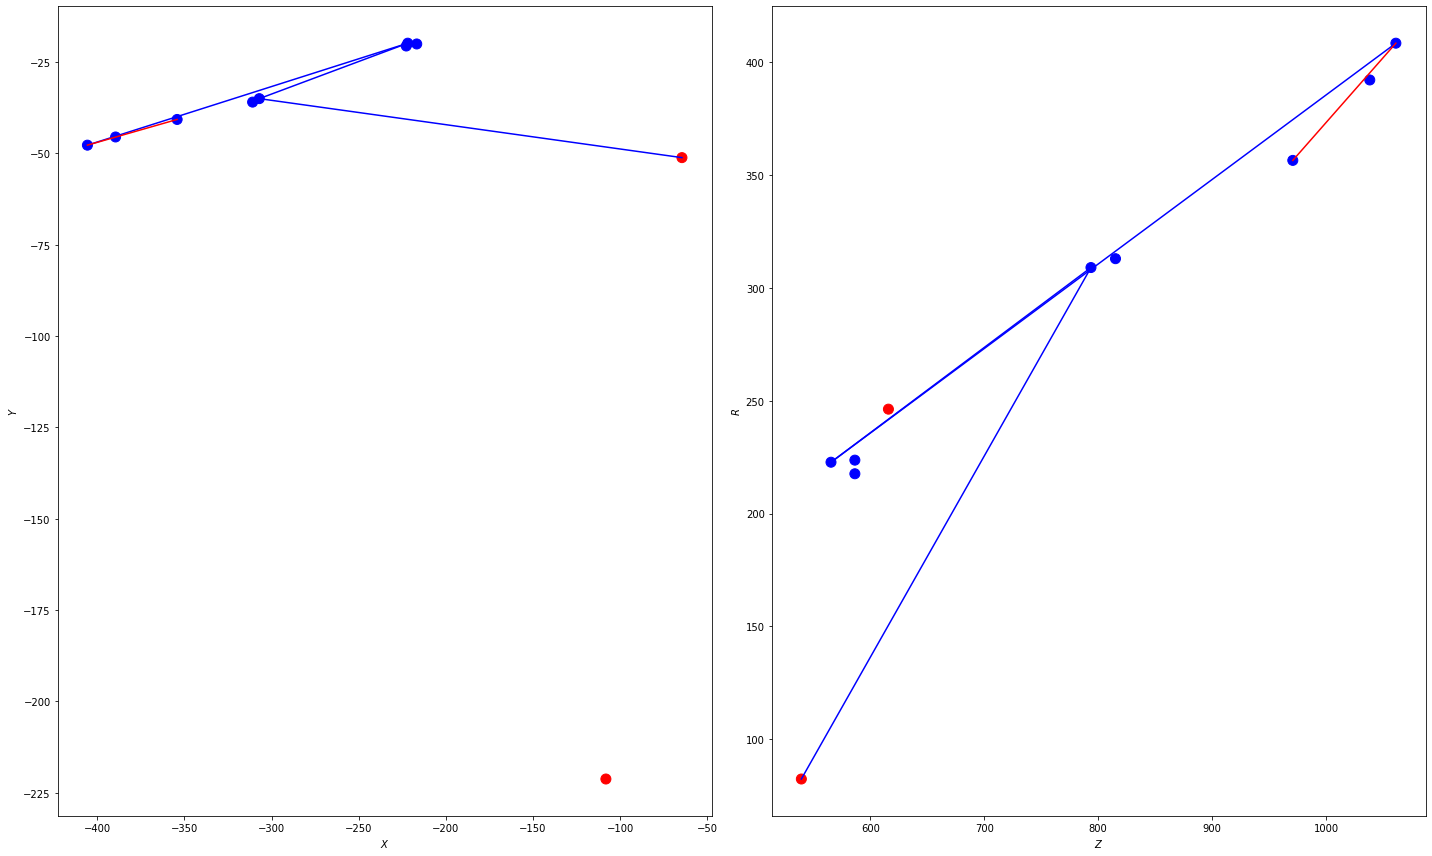

Event= 2    Sector= 12
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         6      2.0        6.0         2.0  356.149109  793.200012
1        11      4.0        6.0         1.0   65.870407  539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 3    Sector= 1
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        1.0         1.0  157.437943 -615.691650
1         0      1.0        1.0         1.0  149.529816 -586.324829
2         7      2.0        1.0         3.0  212.435333 -968.900024
3        11      4.0        1.0         1.0   92.184250 -539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 3    Sector= 2
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        2.0         1.0  188.167709 -615.684326
1         5      2.0        2.0    

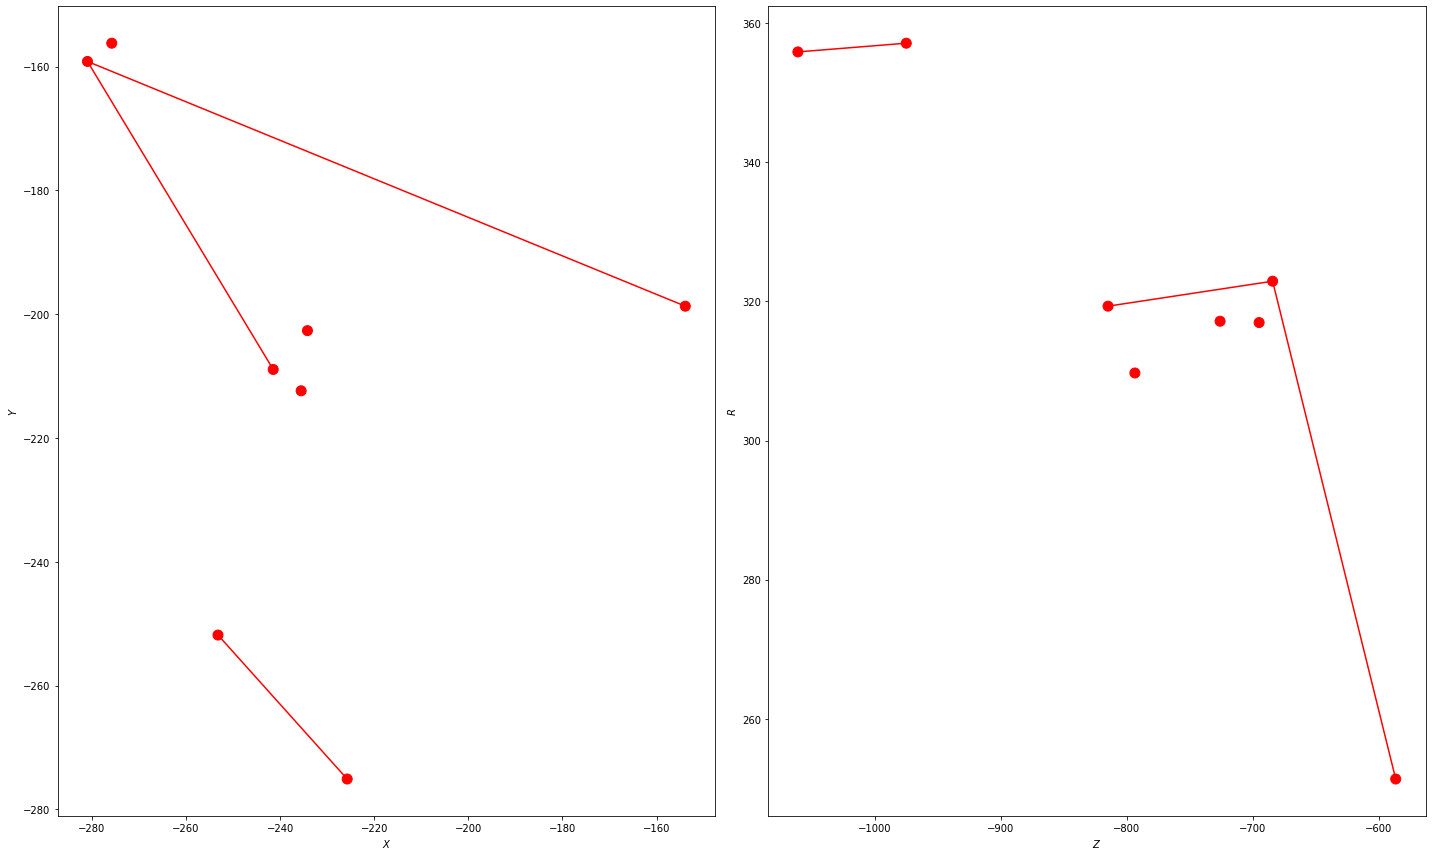

Event= 3    Sector= 5
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        5.0         1.0  119.898468 -615.711121
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 3    Sector= 6
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        6.0         1.0  149.529816  -586.324829
1         3      1.0        6.0         3.0  376.579620  -948.920959
2         4      1.0        6.0         4.0  401.714905 -1038.429077
3         5      2.0        6.0         1.0  317.093903  -694.934570
4         6      2.0        6.0         2.0  356.010895  -788.799988
5         7      2.0        6.0         3.0  407.902344  -970.799988
6         8      2.0        6.0         4.0  407.763733 -1061.295044
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 5
df_segments=    index_1  index_2 

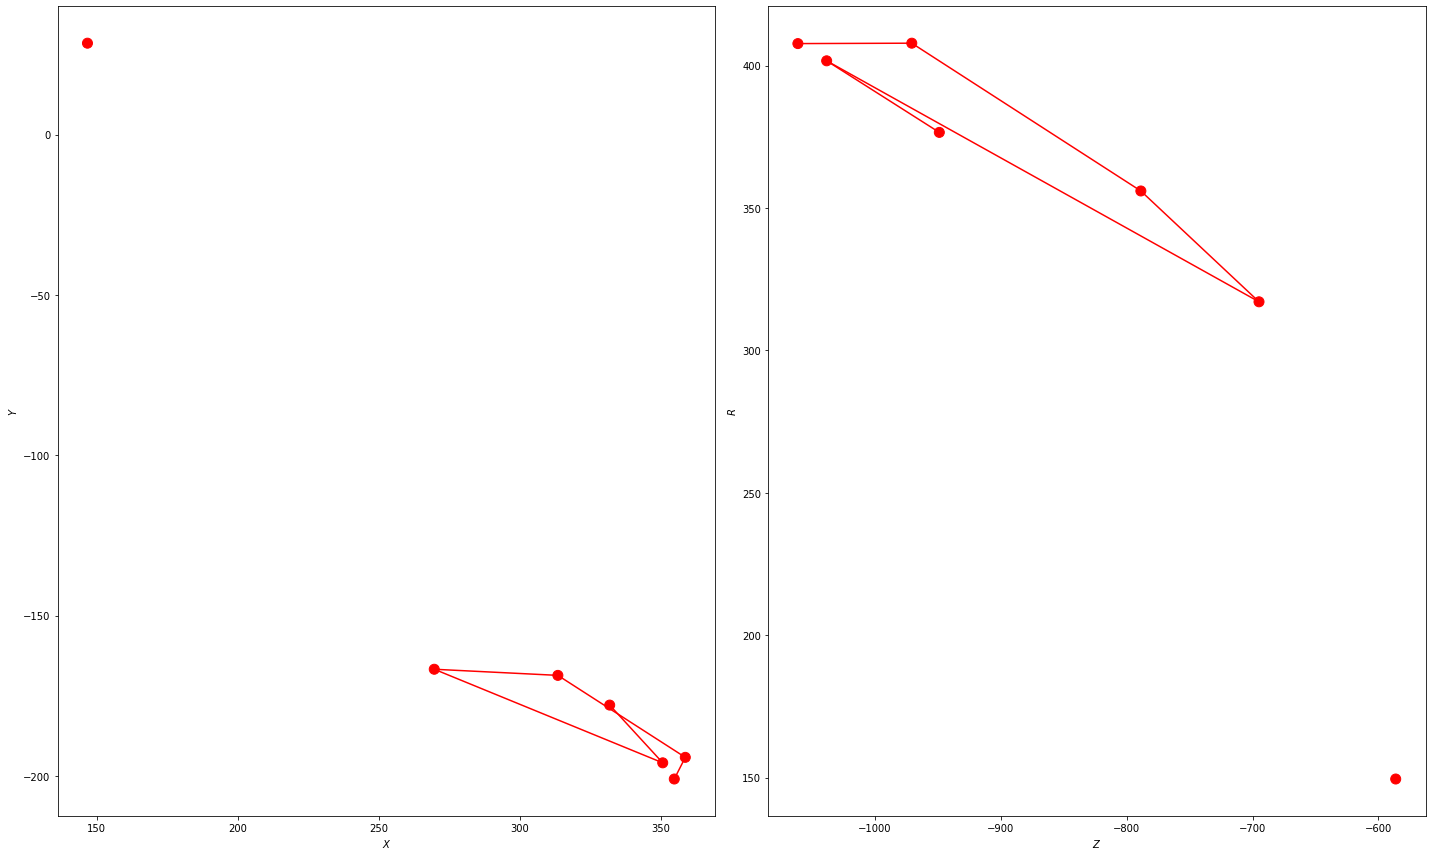

Event= 3    Sector= 7
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        1.0         1.0  114.450043  586.317932
1        11      4.0        1.0         1.0  102.272690  539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 3    Sector= 8
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        2.0         1.0  140.401489   586.390808
1         0      1.0        2.0         1.0  114.450043   586.317932
2         1      1.0        2.0         1.0  429.828217   683.791199
3         2      1.0        2.0         2.0  508.756226   814.876526
4         3      1.0        2.0         3.0  594.231506   949.052734
5         4      1.0        2.0         4.0  649.957092  1038.379761
6         5      2.0        2.0         1.0  434.634430   694.934570
7         7      2.0        2.0         3.0  603.256653   970.799988
8         8      2.0  

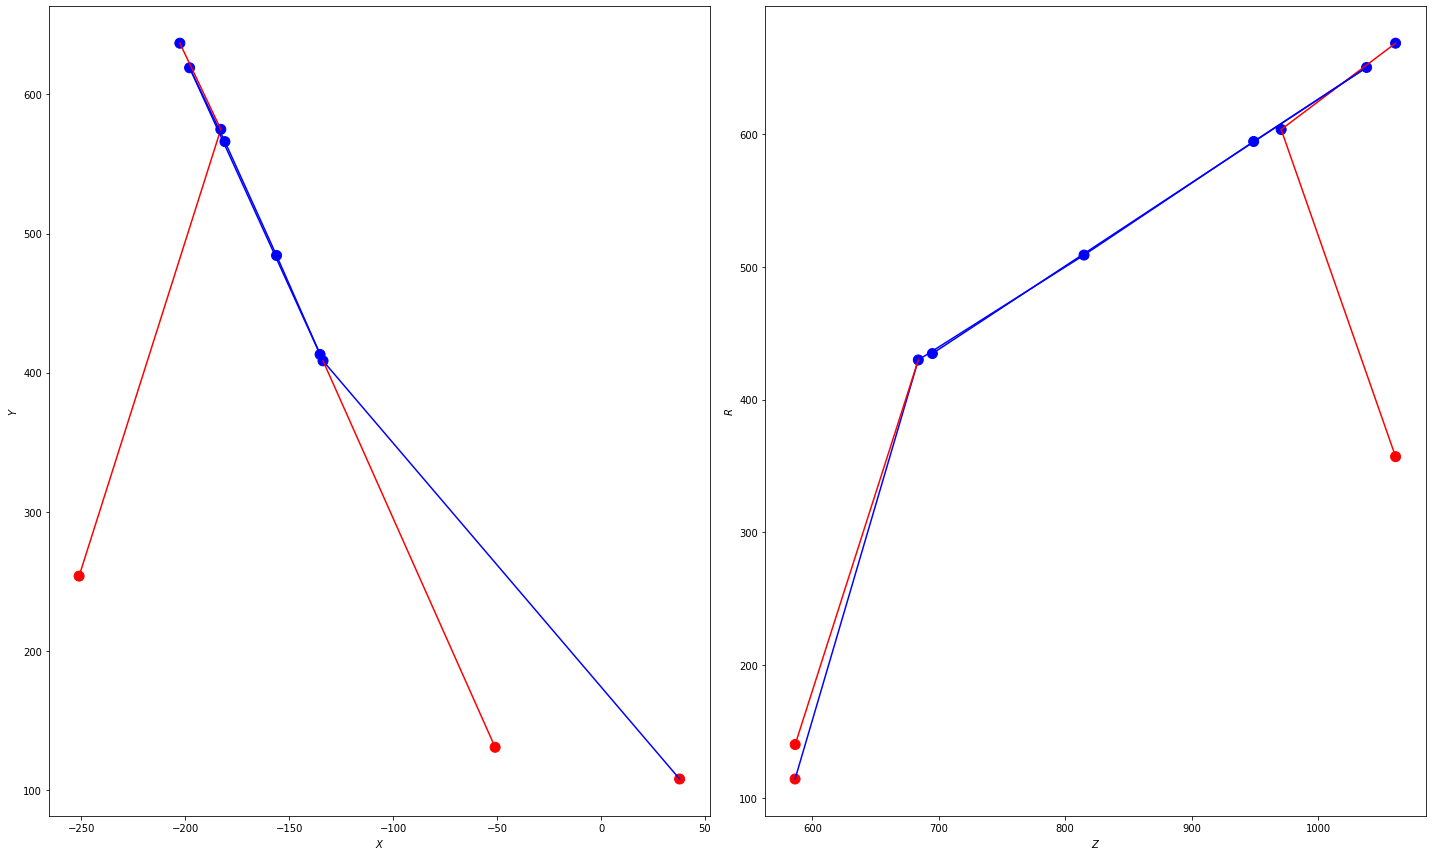

Event= 3    Sector= 9
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        3.0         1.0  123.373680   615.643005
1         0      1.0        3.0         1.0  148.310364   586.467712
2         1      1.0        3.0         1.0  340.603943   711.325012
3         2      1.0        3.0         2.0  386.593933   839.721558
4         3      1.0        3.0         3.0  421.855652   924.372009
5         6      2.0        3.0         2.0  356.149109   793.200012
6         8      2.0        3.0         4.0  467.819366  1065.694946
7         8      2.0        3.0         4.0  357.044891  1061.295044
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 3
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope          z0
0        0        2           0           1  -0.013081  561.301400
1        1        2           0           1  -0.025559  490.168961
2        2       

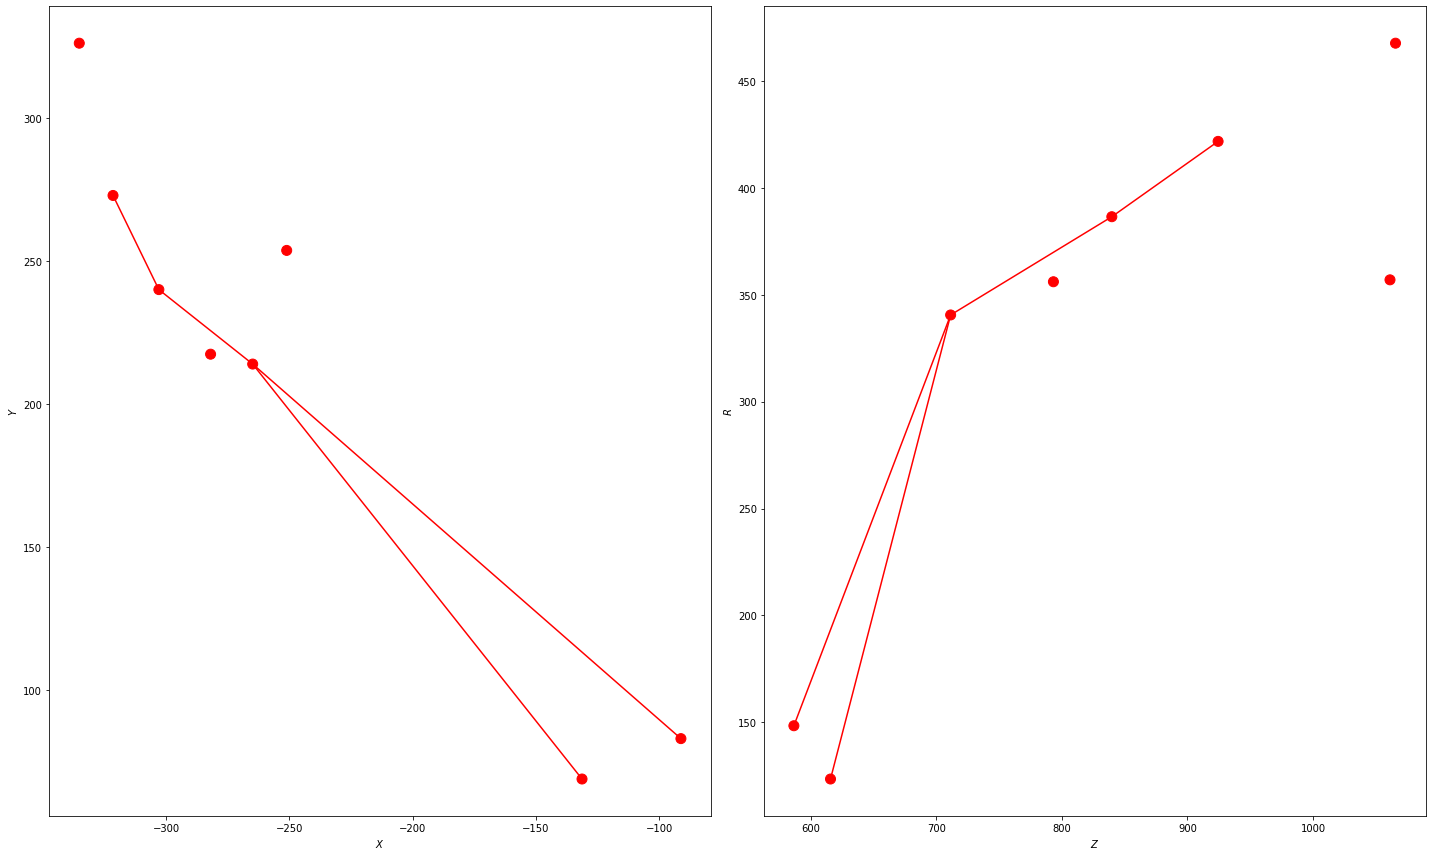

Event= 3    Sector= 11
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        5.0         1.0  126.265038  615.760864
1         0      1.0        5.0         1.0  217.522446  615.738403
2         0      1.0        5.0         1.0  242.083618  586.394409
3         0      1.0        5.0         1.0  258.439148  586.232727
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 3    Sector= 12
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        6.0         1.0  115.932602  586.454590
1         0      1.0        6.0         1.0  117.786522  586.354614
2         2      1.0        6.0         2.0  272.235992  815.004761
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 4    Sector= 1
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0        11      4.0        1.0   

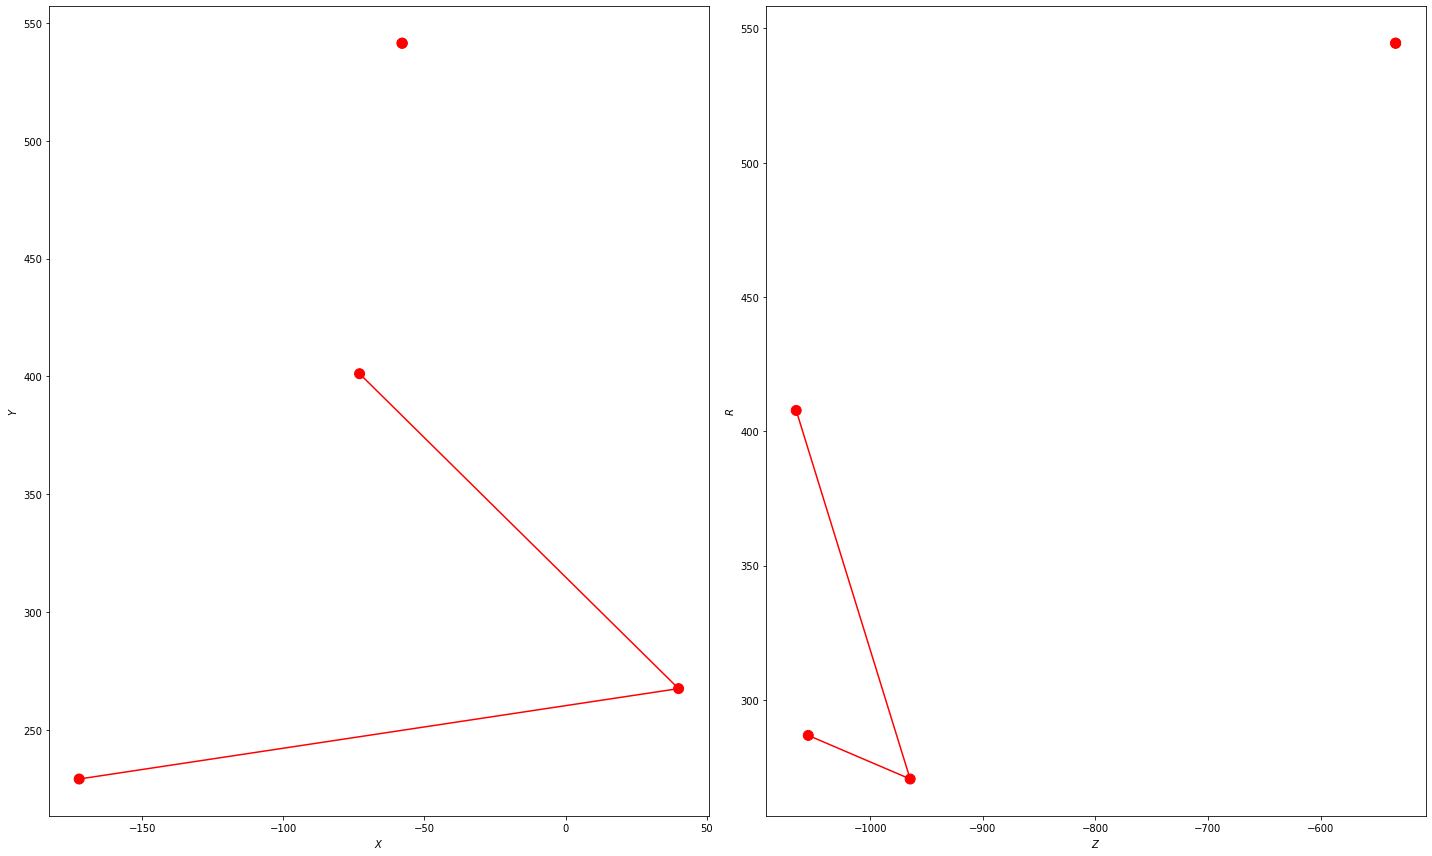

Event= 4    Sector= 3
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        3.0         1.0  104.717834  -586.423157
1         0      1.0        3.0         1.0  139.471664  -586.359985
2         8      2.0        3.0         4.0  286.752075 -1054.994995
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 4    Sector= 4
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        4.0         1.0  139.471664 -586.359985
1        11      4.0        4.0         1.0   66.553047 -539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 4    Sector= 5
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        5.0         1.0  121.280518 -615.754395
1         0      1.0        5.0         1.0  120.499756 -586.440247
2         0      1.0        5.0 

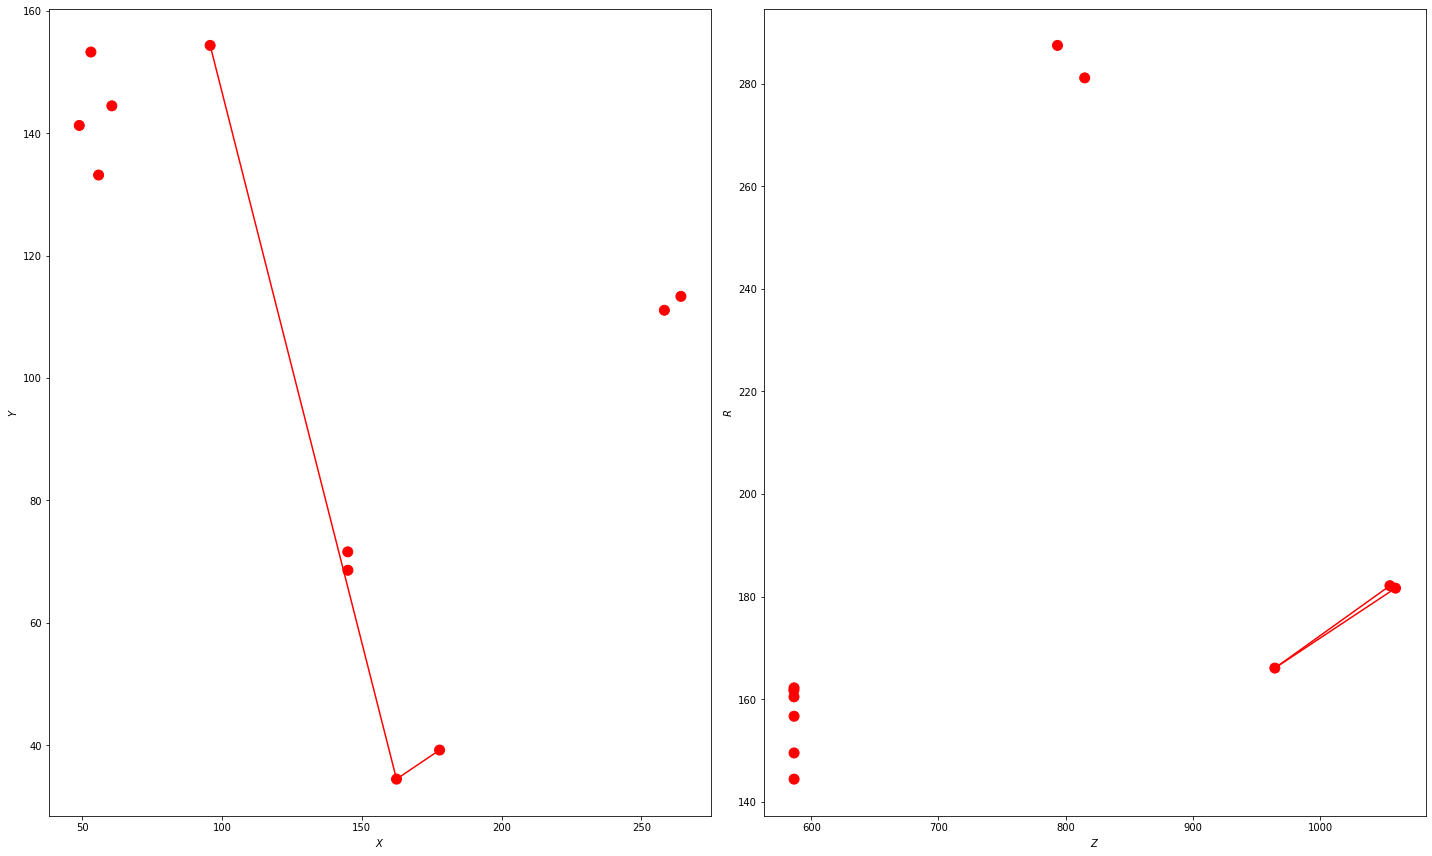

Event= 4    Sector= 8
    vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0          0      1.0        2.0         1.0  115.847740   615.662842
1          0      1.0        2.0         1.0  149.501785   586.471008
2          0      1.0        2.0         1.0  144.398560   586.474243
3          0      1.0        2.0         1.0  162.194809   586.461243
4          0      1.0        2.0         1.0  156.658493   586.464783
5          1      1.0        2.0         1.0  440.281006   683.863220
6          2      1.0        2.0         2.0  153.831131   815.090332
7          2      1.0        2.0         2.0  244.700333   815.012756
8          3      1.0        2.0         3.0  178.385529   948.719666
9          4      1.0        2.0         4.0  193.961502  1038.667480
10         4      1.0        2.0         4.0  293.861694  1038.593262
11         5      2.0        2.0         1.0  434.596985   694.934570
12         7      2.0        2.0         3.0  183.791473   968.90002

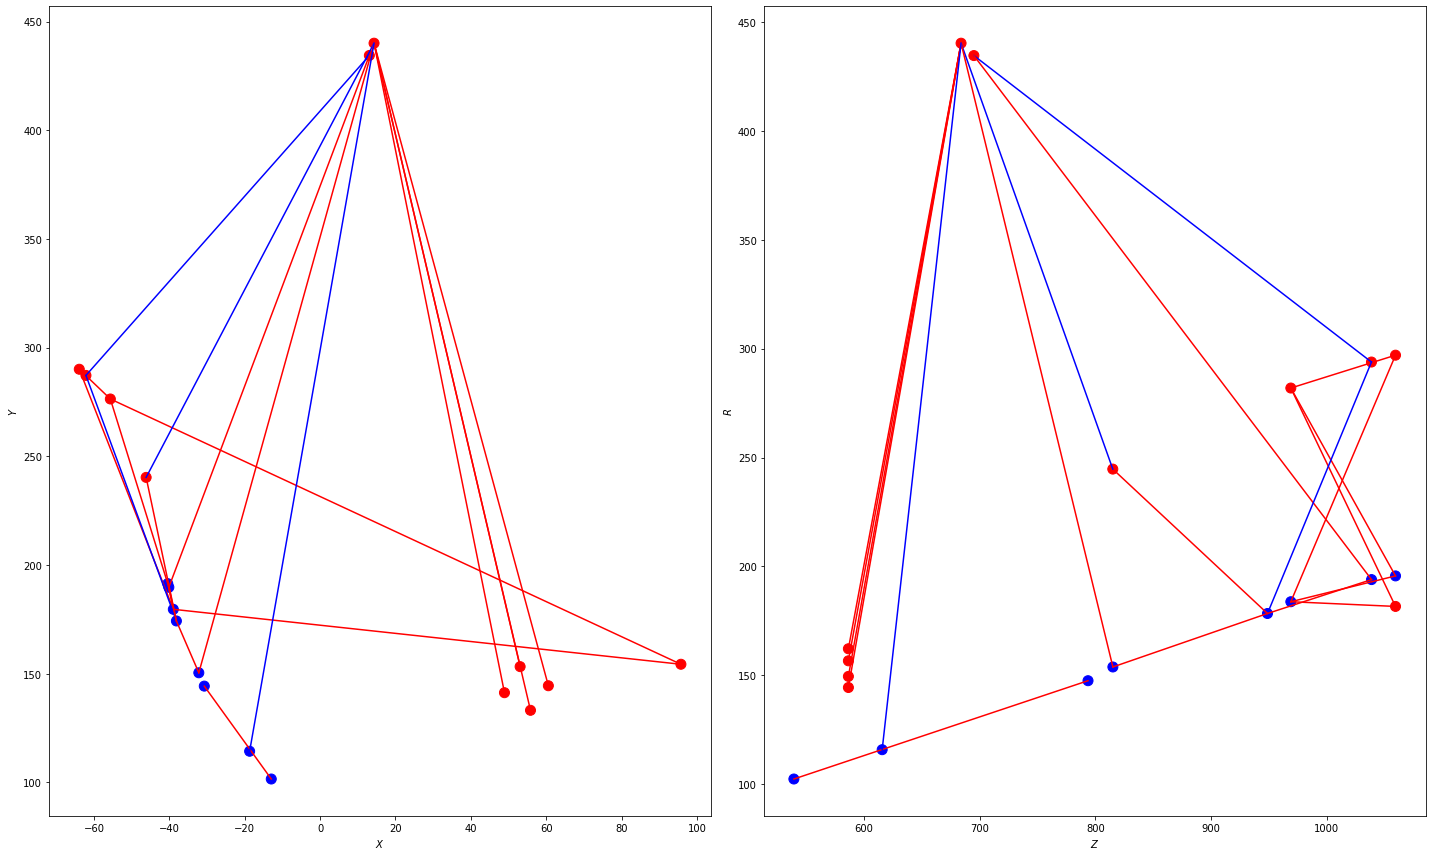

Event= 4    Sector= 9
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        3.0         1.0  138.602997  615.740723
1         7      2.0        3.0         3.0  199.673492  964.500000
2         9      3.0        3.0         1.0  211.269455  567.971252
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 4    Sector= 10
   vh_layer  vh_type  vh_sector  vh_station  vh_sim_r    vh_sim_z
0         0      1.0        4.0         1.0   194.097  586.470642
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 4    Sector= 11
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0       -99      2.0        5.0         2.0  533.761475  793.200012
1       -99      0.0        5.0         2.0  534.246216  533.478699
2         0      1.0        5.0         1.0  194.097000  586.470642
adj_layer_pairs= [[0, 1], [1, 2], [2, 

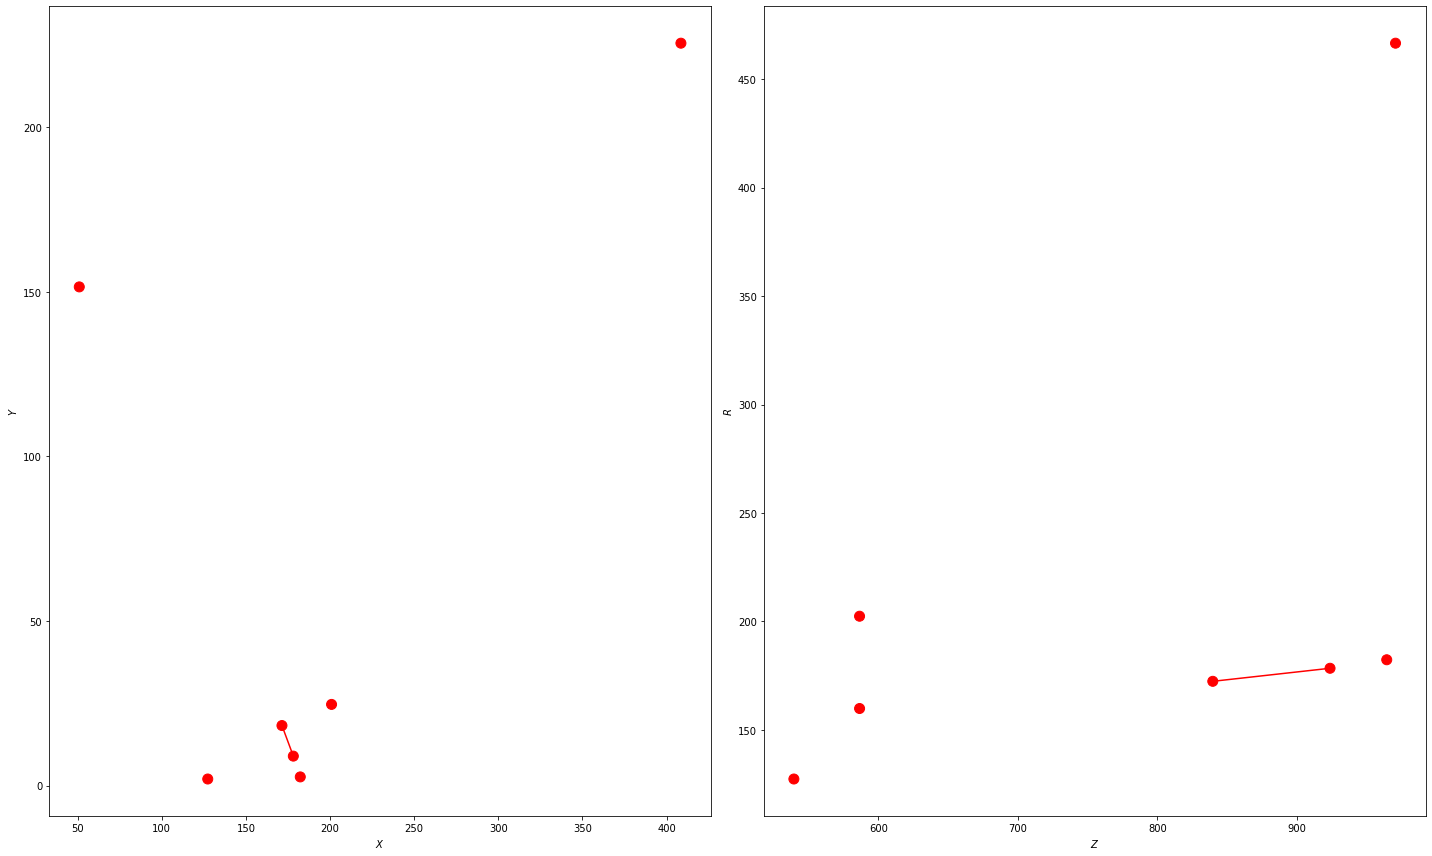

Event= 5    Sector= 8
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        2.0         1.0  103.814621  615.679993
1         0      1.0        2.0         1.0  106.117065  615.679565
2         0      1.0        2.0         1.0  159.844849  586.463196
3         2      1.0        2.0         2.0  152.048462  839.811829
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 5    Sector= 9
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        3.0         1.0  223.070190  615.825623
1         0      1.0        3.0         1.0  225.194580  615.810425
2         0      1.0        3.0         1.0  146.103363  586.498230
3         2      1.0        3.0         2.0  152.048462  839.811829
4         5      2.0        3.0         1.0  317.217529  694.934570
5         9      3.0        3.0         1.0  228.443024  567.971252
6        11      4.0        3.0

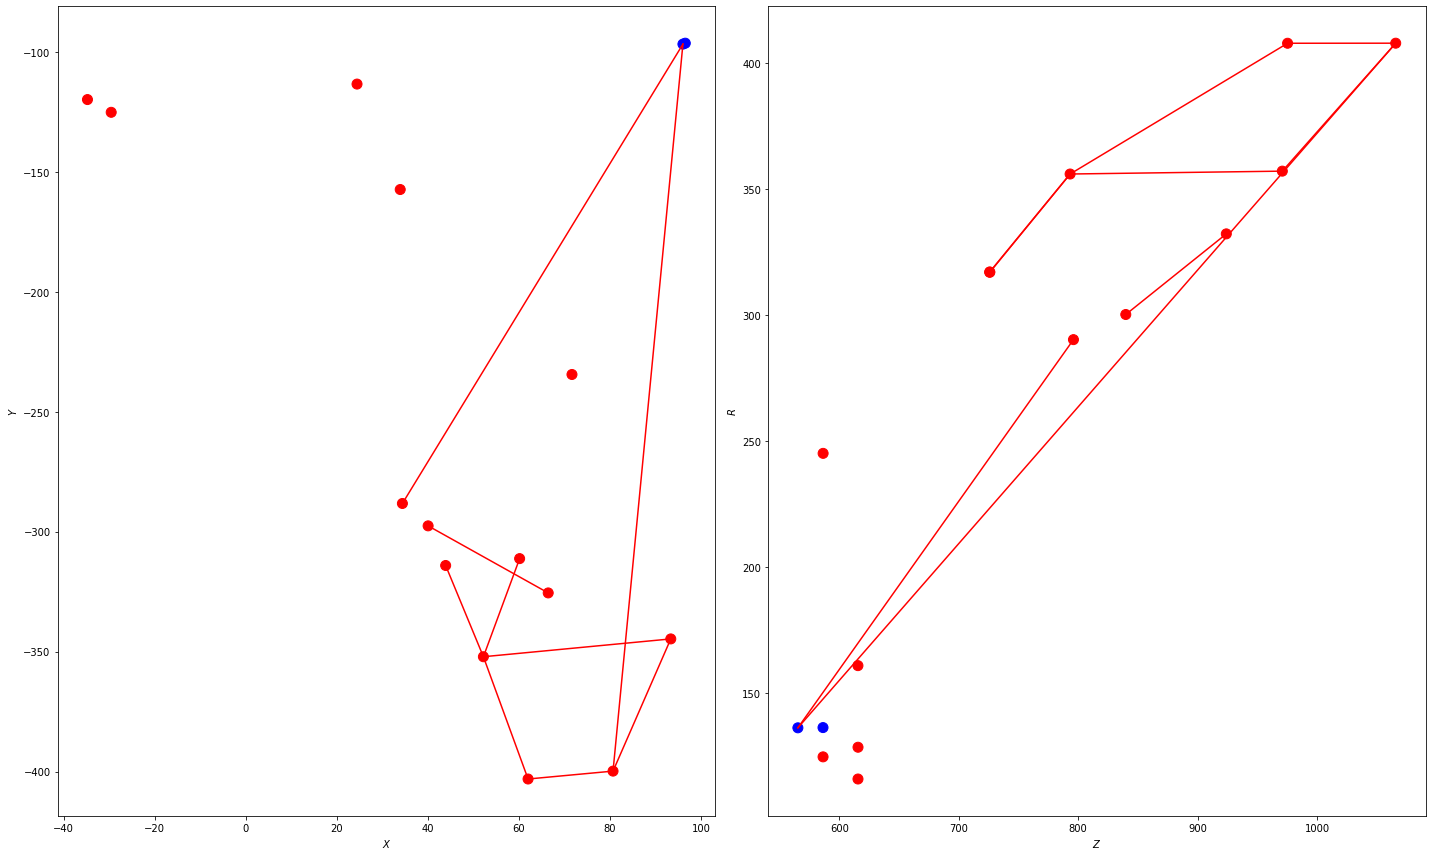

Event= 5    Sector= 12
    vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0          0      1.0        6.0         1.0  142.425705   615.699524
1          0      1.0        6.0         1.0  202.400360   586.444519
2          0      1.0        6.0         1.0  136.422958   586.396179
3          0      1.0        6.0         1.0  138.370483   615.637756
4          2      1.0        6.0         2.0  172.383728   839.755859
5          2      1.0        6.0         2.0  195.648636   839.706360
6          3      1.0        6.0         3.0  178.400467   923.842712
7          3      1.0        6.0         3.0  214.049103   923.831177
8          4      1.0        6.0         4.0  232.661026  1013.774780
9          7      2.0        6.0         3.0  223.158020   964.500000
10         7      2.0        6.0         3.0  182.325653   964.500000
11         8      2.0        6.0         4.0  243.239822  1054.994995
12         8      2.0        6.0         4.0  181.537445  1059.3950

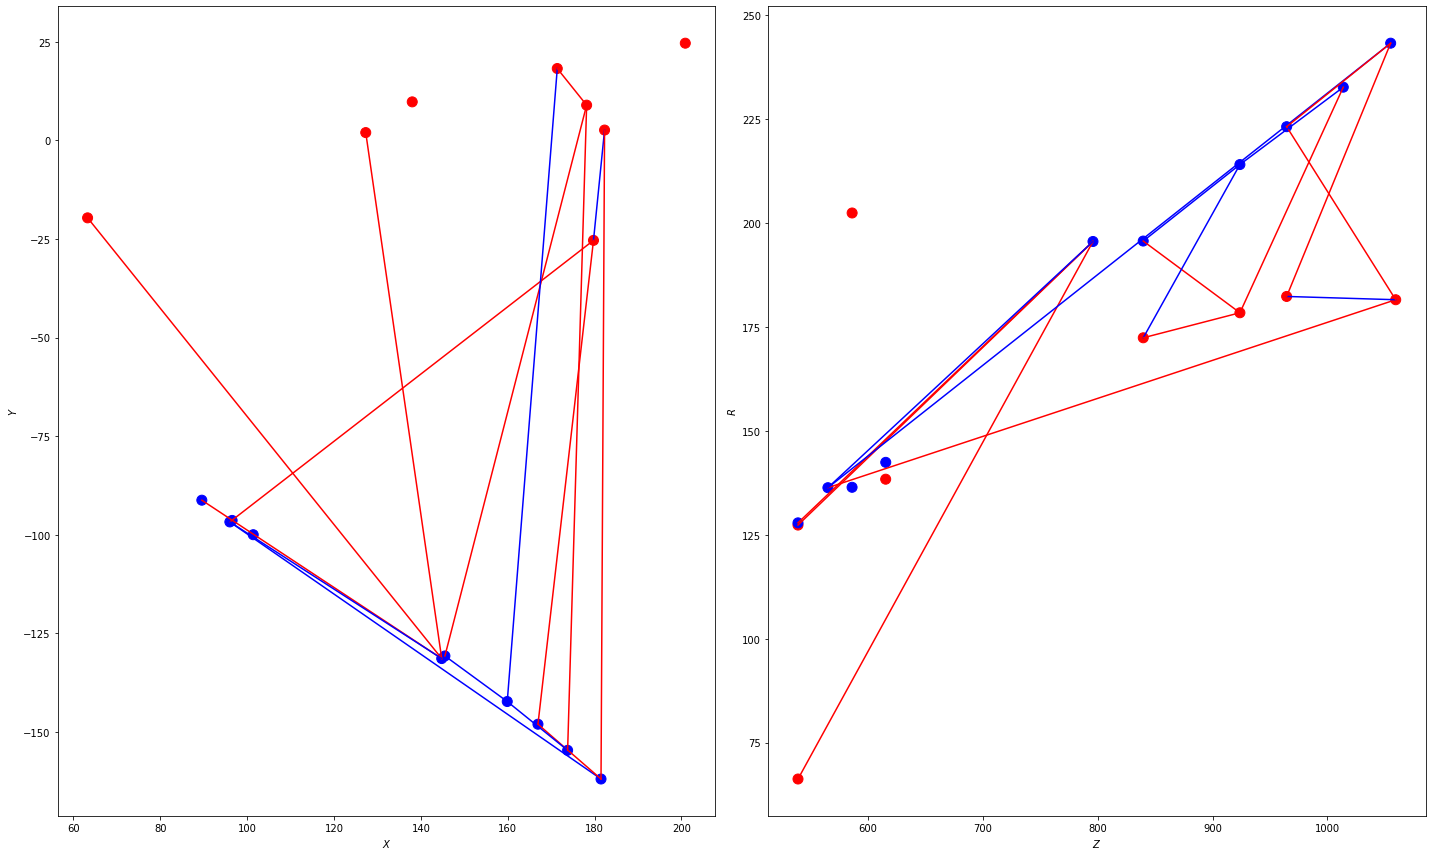

Event= 6    Sector= 1
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         5      2.0        1.0         1.0  382.563934 -725.950012
1         7      2.0        1.0         3.0  466.942139 -975.200012
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 6    Sector= 2
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        2.0         1.0  139.002274  -586.427002
1         0      1.0        2.0         1.0  149.221817  -615.701904
2         0      1.0        2.0         1.0  139.104492  -615.681885
3         2      1.0        2.0         2.0  164.584396  -814.864563
4         3      1.0        2.0         3.0  195.360870  -948.993835
5         7      2.0        2.0         3.0  202.260223  -968.900024
6         8      2.0        2.0         4.0  223.361069 -1059.395020
7        11      4.0        2.0         1.0  108.085831  -539.349976
adj_layer_pairs= [[0, 

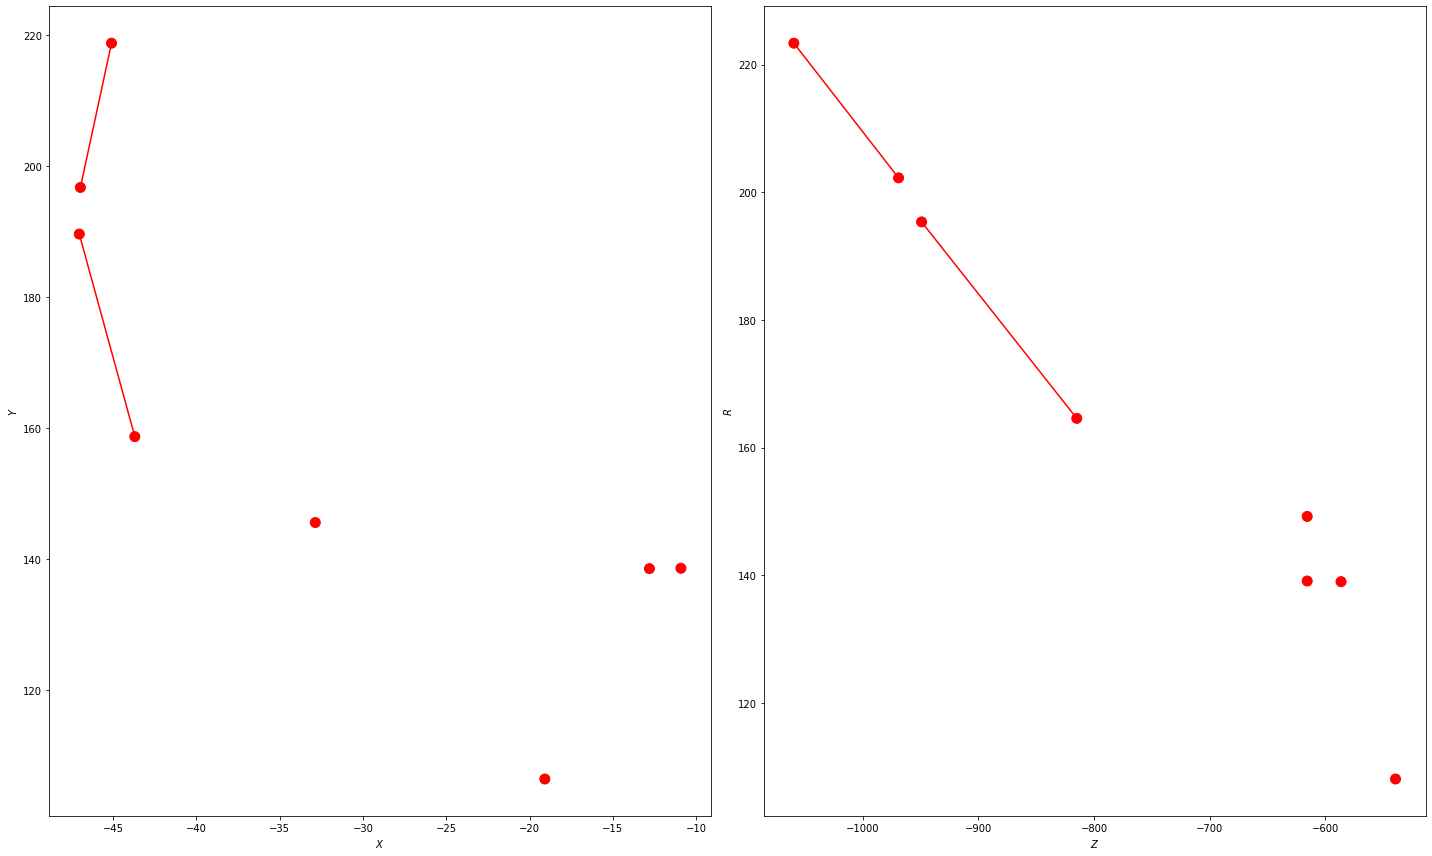

Event= 6    Sector= 3
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0       -99      2.0        3.0         2.0  535.274536 -793.200012
1         1      1.0        3.0         1.0  376.068085 -711.699829
2         5      2.0        3.0         1.0  382.666992 -725.950012
3         6      2.0        3.0         2.0  408.190155 -793.200012
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 1
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope          z0
0        2        3           5           6   0.012443  282.324526
Event= 6    Sector= 3
Z_i= [-725.95000267]
Z_o= [-793.20001602]


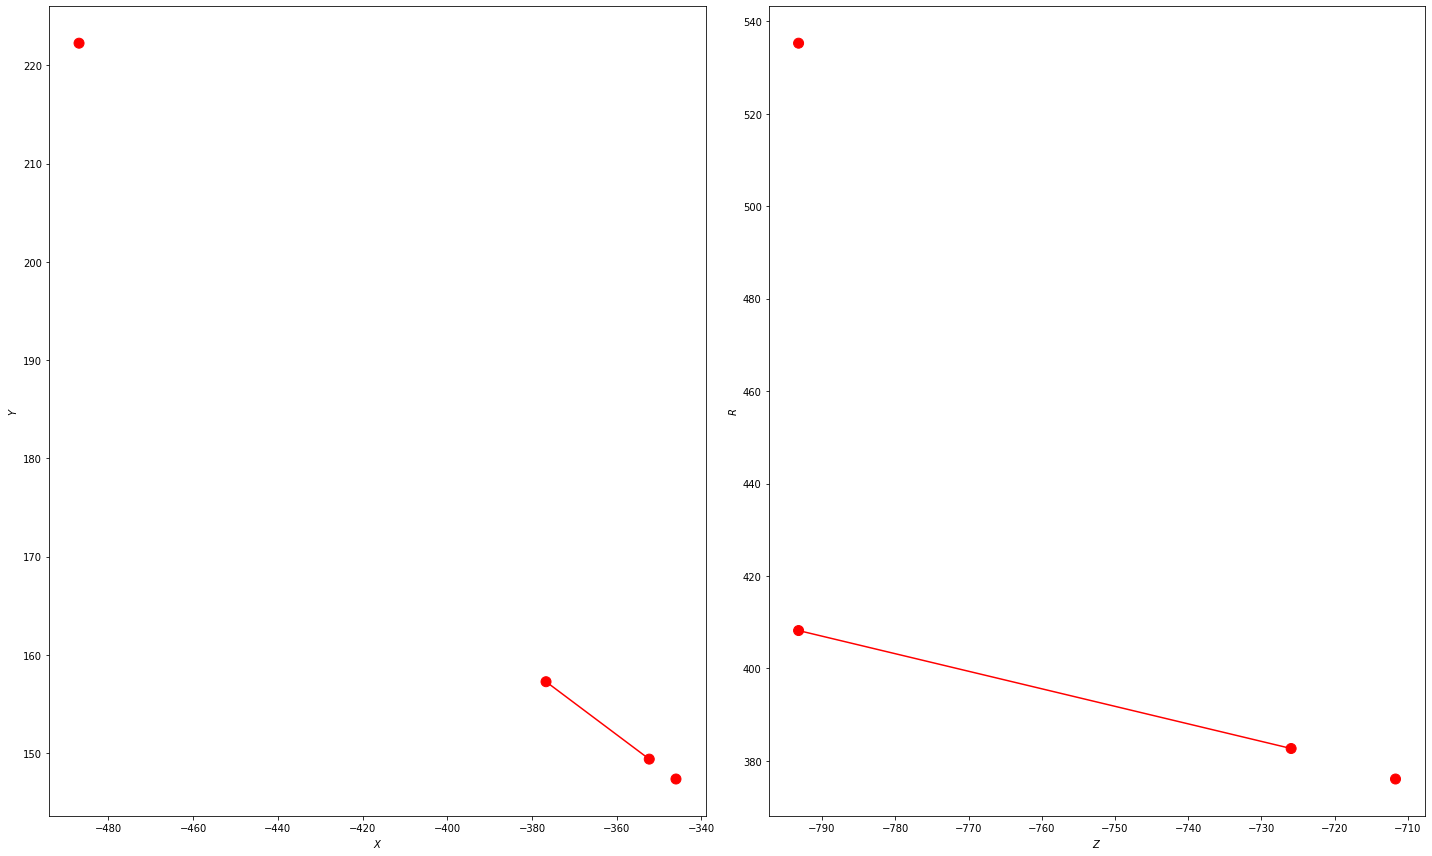

Event= 6    Sector= 4
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        4.0         1.0  118.416061 -615.627380
1         0      1.0        4.0         1.0  116.823578 -615.642151
2         2      1.0        4.0         2.0  246.463516 -839.648560
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 6    Sector= 5
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        5.0         1.0  197.321014 -615.674133
1        11      4.0        5.0         1.0   66.204826 -539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 6    Sector= 6
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        6.0         1.0  243.904541 -615.682922
1         2      1.0        6.0         2.0  287.083496 -814.858765
2        11      4.0        6.0     

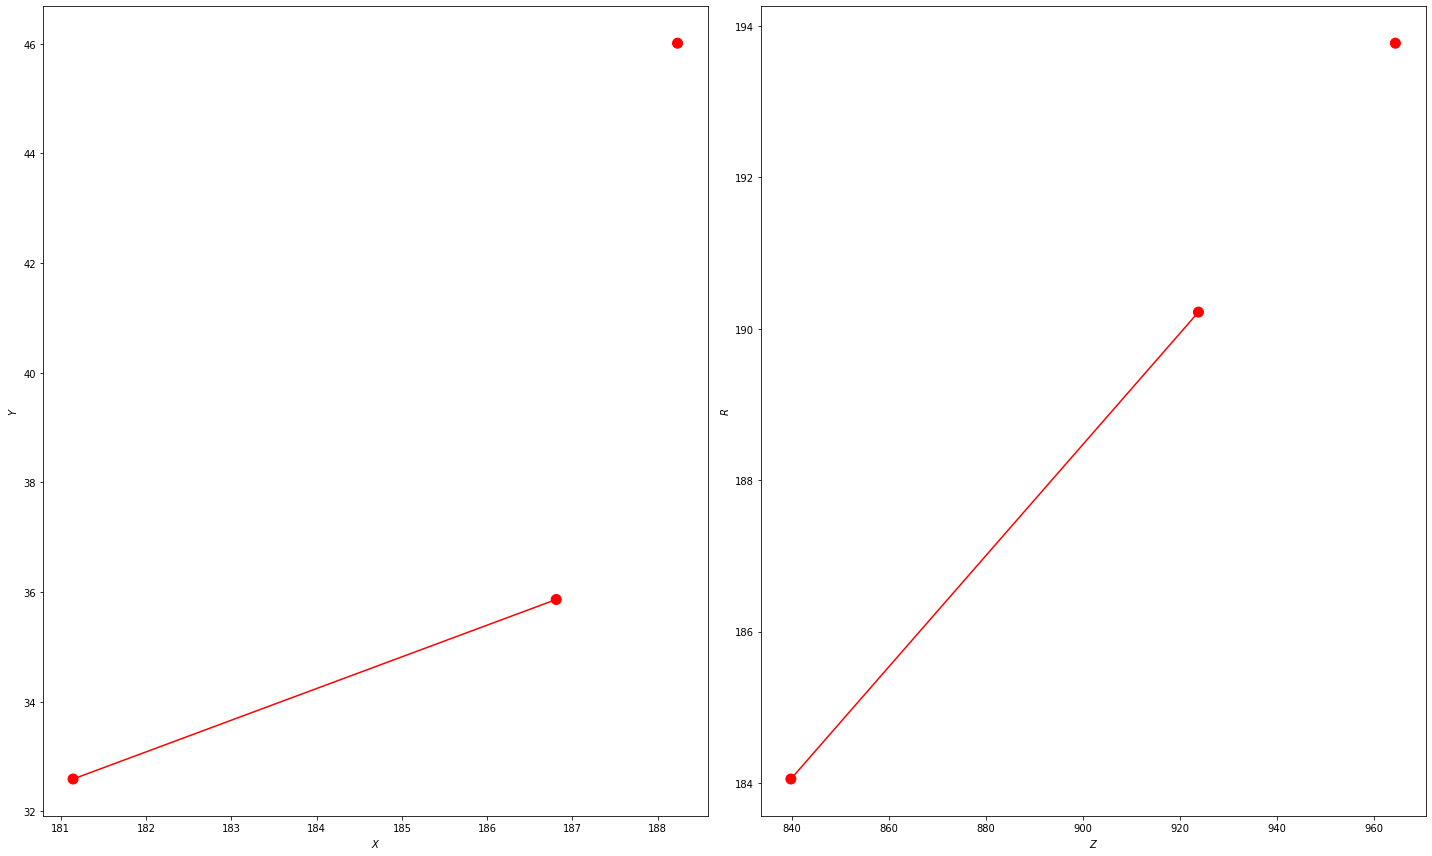

Event= 6    Sector= 8
    vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0          0      1.0        2.0         1.0  115.667473   615.652710
1          0      1.0        2.0         1.0  116.072144   615.675110
2          0      1.0        2.0         1.0  109.952835   615.640503
3          0      1.0        2.0         1.0  115.192101   586.586914
4          0      1.0        2.0         1.0  143.594879   615.686035
5          0      1.0        2.0         1.0  139.114990   615.651001
6          0      1.0        2.0         1.0  114.951698   615.679626
7          0      1.0        2.0         1.0  111.364807   615.651611
8          2      1.0        2.0         2.0  158.169113   839.772095
9          3      1.0        2.0         3.0  175.182861   923.791809
10         4      1.0        2.0         4.0  192.437241  1013.881226
11         7      2.0        2.0         3.0  182.554733   964.500000
12         8      2.0        2.0         4.0  198.092682  1054.99499

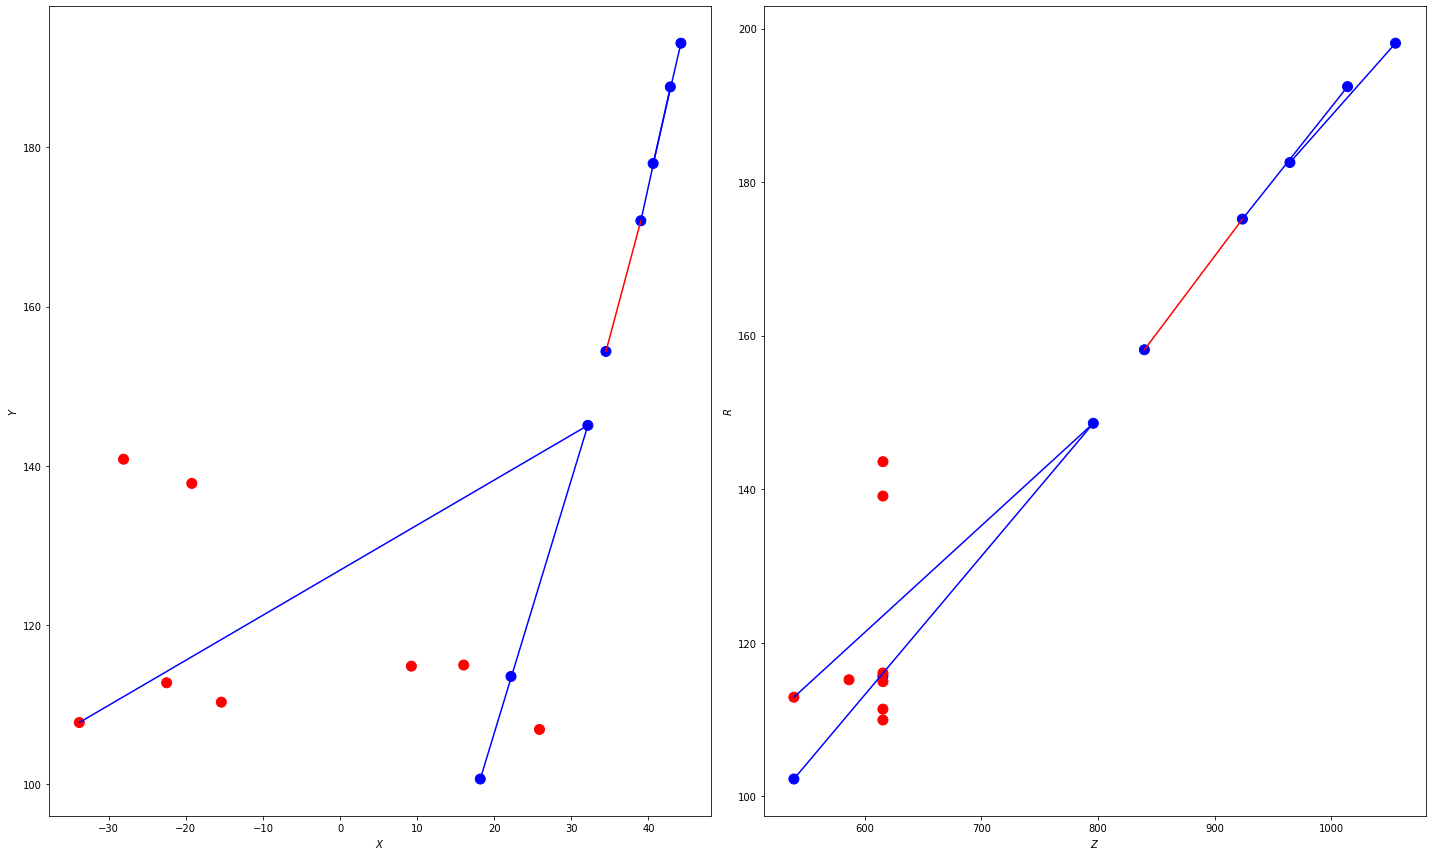

Event= 6    Sector= 10
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0       -99      0.0        4.0         2.0  519.356445   468.190155
1         0      1.0        4.0         1.0  126.997643   586.350159
2         0      1.0        4.0         1.0  128.567734   586.360657
3         1      1.0        4.0         1.0  308.998657   711.313538
4         2      1.0        4.0         2.0  157.554855   839.771851
5         2      1.0        4.0         2.0  332.871033   815.121765
6         5      2.0        4.0         1.0  317.068939   725.950012
7         7      2.0        4.0         3.0  167.259613   964.500000
8         7      2.0        4.0         3.0  356.747864   975.200012
9         8      2.0        4.0         4.0  407.763733  1061.295044
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 3
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope          z0
0        1  

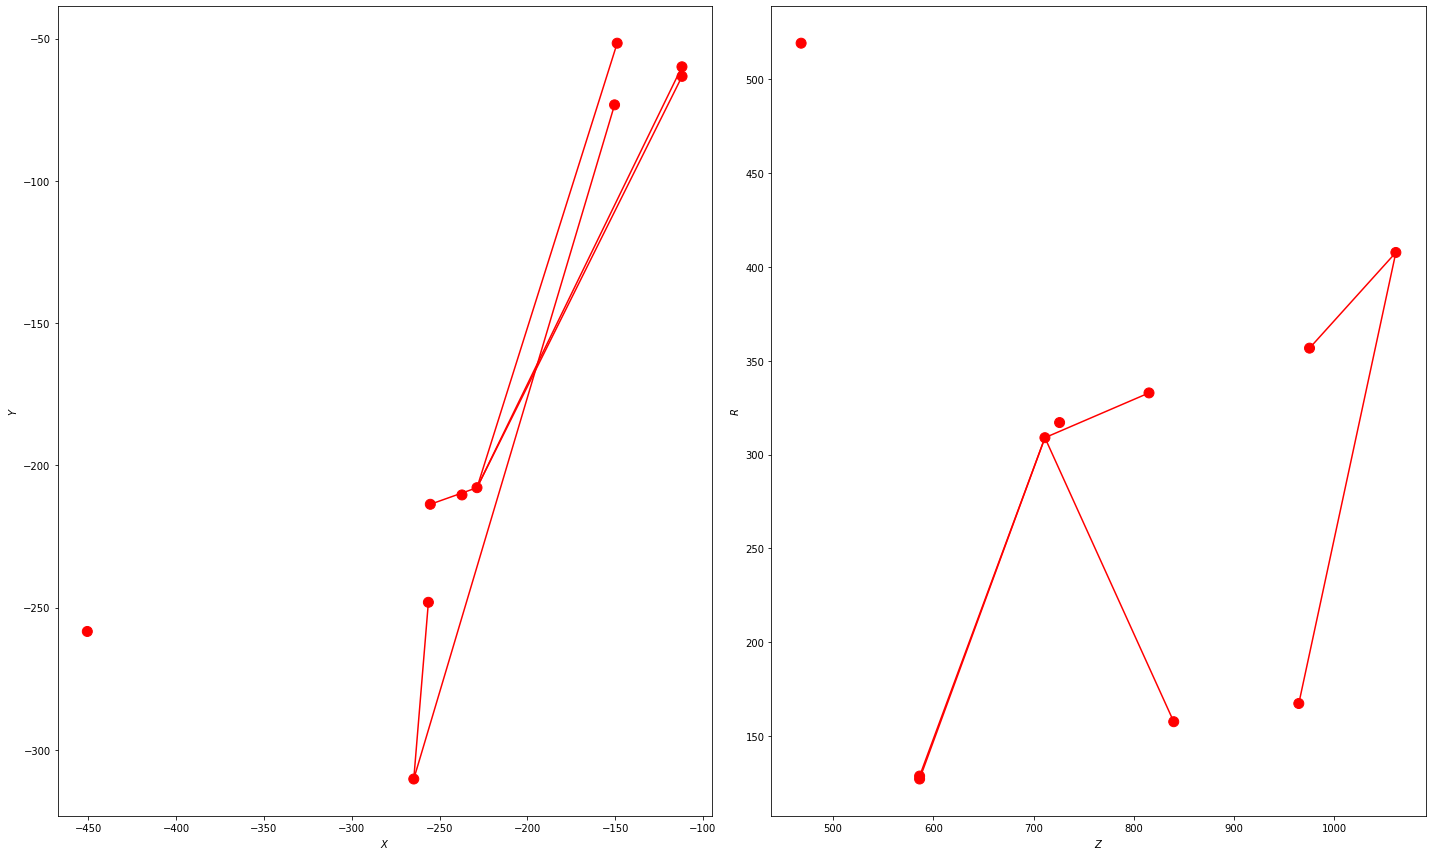

Event= 6    Sector= 11
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        5.0         1.0  237.747299   586.485840
1         0      1.0        5.0         1.0  104.715721   615.752441
2         7      2.0        5.0         3.0  292.049377   968.900024
3         7      2.0        5.0         3.0  276.968445   964.500000
4         8      2.0        5.0         4.0  319.607269  1059.395020
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 1
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope          z0
0        2        4           7           8   -0.09086    9.864147
1        3        4           7           8   -0.04289  348.091684
Event= 6    Sector= 11
Z_i= [964.50001001 968.90002489]
Z_o= [1059.39507484 1059.39507484]


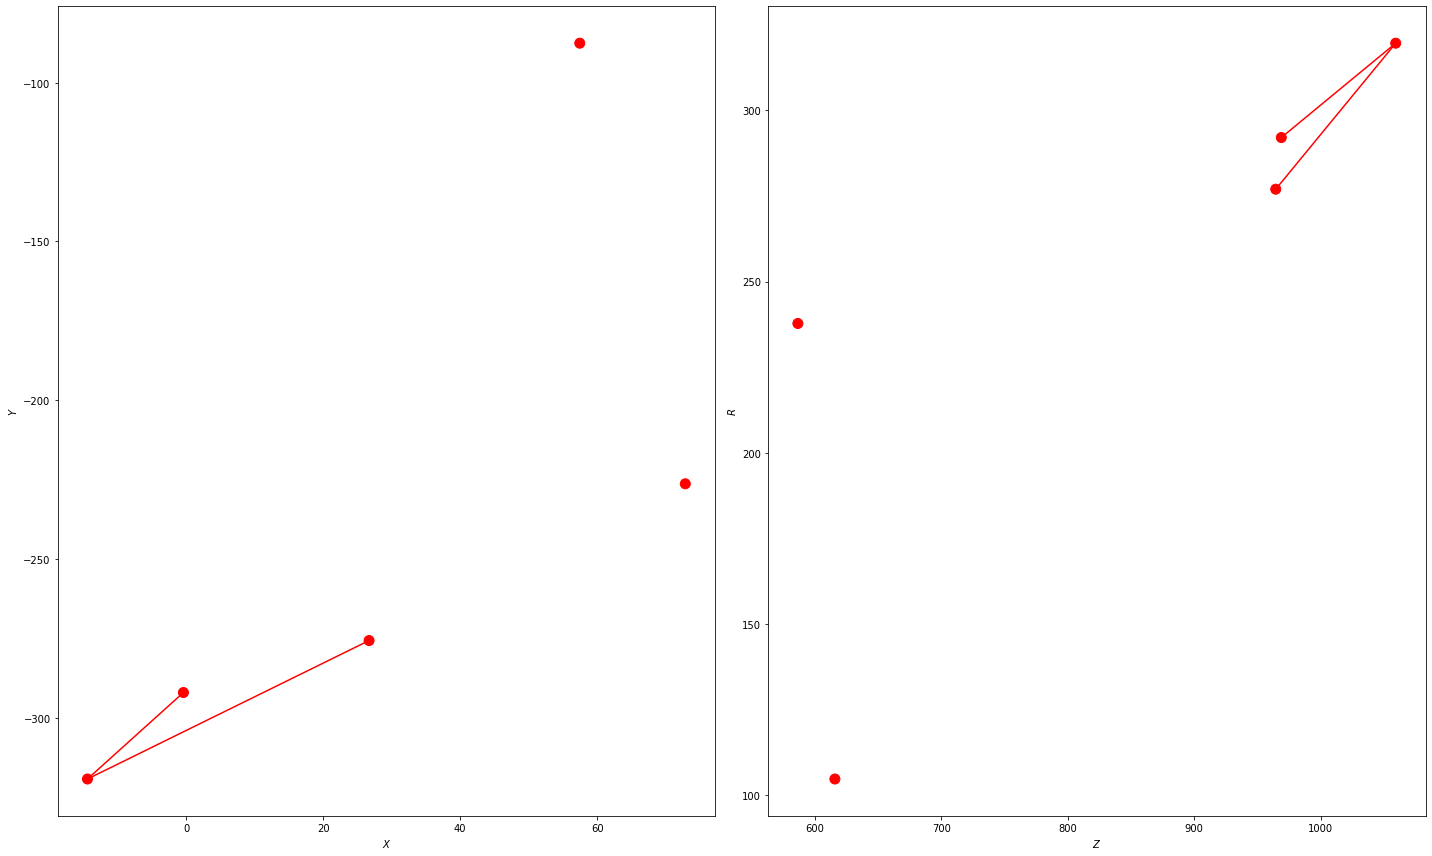

Event= 6    Sector= 12
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        6.0         1.0  126.634575  615.660217
1         0      1.0        6.0         1.0  195.358459  586.454590
2         2      1.0        6.0         2.0  184.052094  839.736023
3         3      1.0        6.0         3.0  190.221603  923.853271
4         7      2.0        6.0         3.0  193.774490  964.500000
5         7      2.0        6.0         3.0  166.202133  968.900024
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 1
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope           z0
0        2        3           2           3   0.108302 -1669.694382
Event= 6    Sector= 12
Z_i= [839.73604441]
Z_o= [923.85327816]


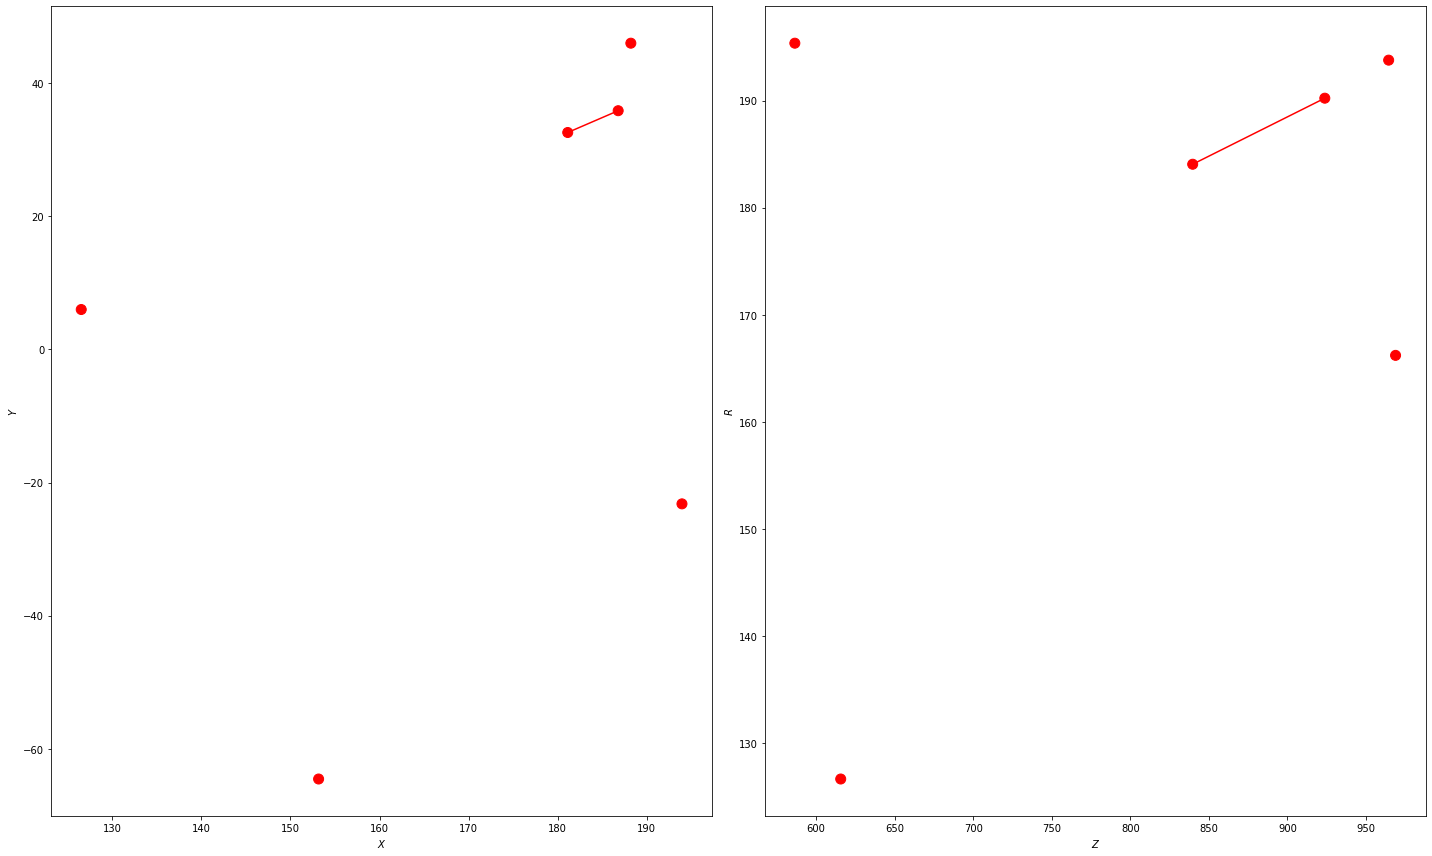

Event= 7    Sector= 1
    vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0          0      1.0        1.0         1.0  229.314499  -615.739136
1          0      1.0        1.0         1.0  175.858337  -586.395996
2          0      1.0        1.0         1.0  122.954094  -586.403870
3          3      1.0        1.0         3.0  290.579559  -948.888672
4          3      1.0        1.0         3.0  288.579071  -949.002258
5          4      1.0        1.0         4.0  329.650269 -1038.260864
6          4      1.0        1.0         4.0  329.432739 -1038.239136
7          7      2.0        1.0         3.0  203.021240  -968.900024
8          7      2.0        1.0         3.0  303.454285  -968.900024
9          8      2.0        1.0         4.0  224.951492 -1059.395020
10         8      2.0        1.0         4.0  356.552795 -1065.694946
11        11      4.0        1.0         1.0   74.262878  -539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6

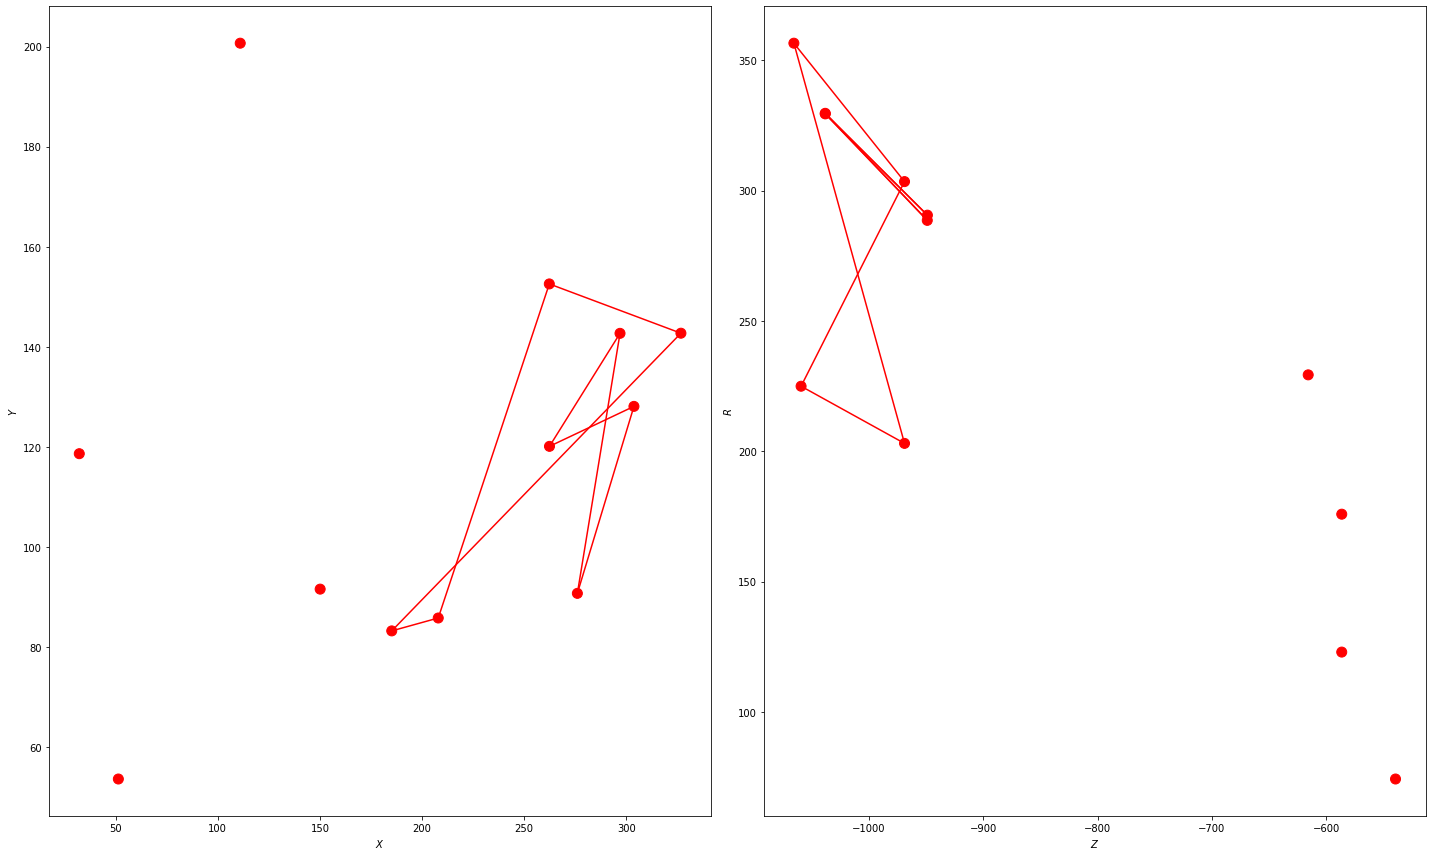

Event= 7    Sector= 2
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        2.0         1.0  122.954094  -586.40387
1         8      2.0        2.0         4.0  241.817368 -1059.39502
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 7    Sector= 3
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        3.0         1.0  184.502747 -586.351135
1         0      1.0        3.0         1.0   99.483139 -586.482788
2        11      4.0        3.0         1.0  102.835663 -539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 7    Sector= 4
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        4.0         1.0   99.483139 -586.482788
1         0      1.0        4.0         1.0  179.180130 -586.412048
2         0      1.0        4.0     

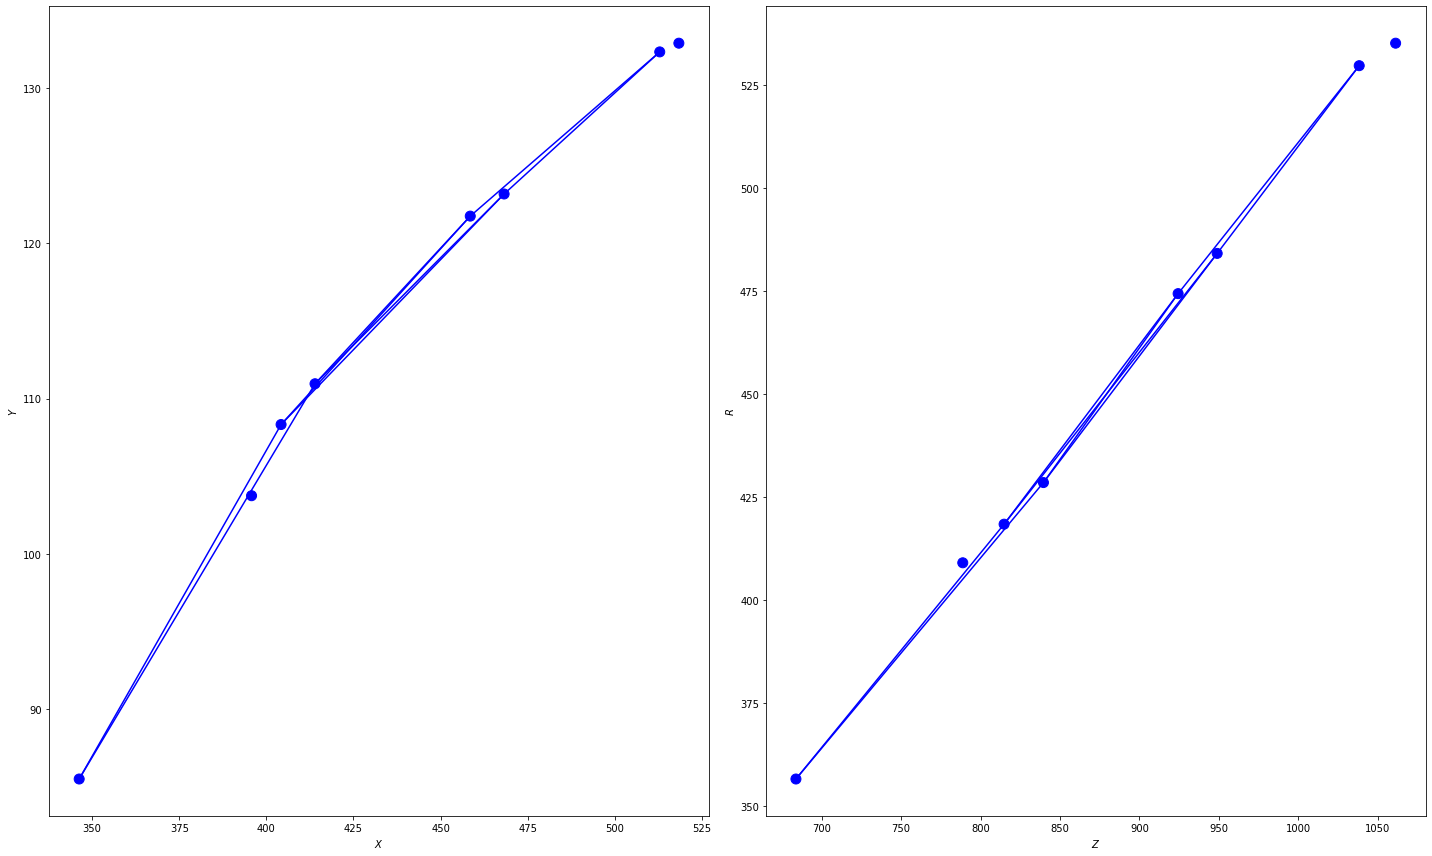

Event= 7    Sector= 8
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         7      2.0        2.0         3.0  173.259979   968.900024
1         8      2.0        2.0         4.0  197.805069  1059.395020
2         8      2.0        2.0         4.0  356.074677  1065.694946
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 1
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope          z0
0        0        1           7           8   0.072353  330.109898
1        0        2           7           8   0.057098  877.164040
Event= 7    Sector= 8
Z_i= [968.90002489 968.90002489]
Z_o= [1065.69492817 1059.39507484]


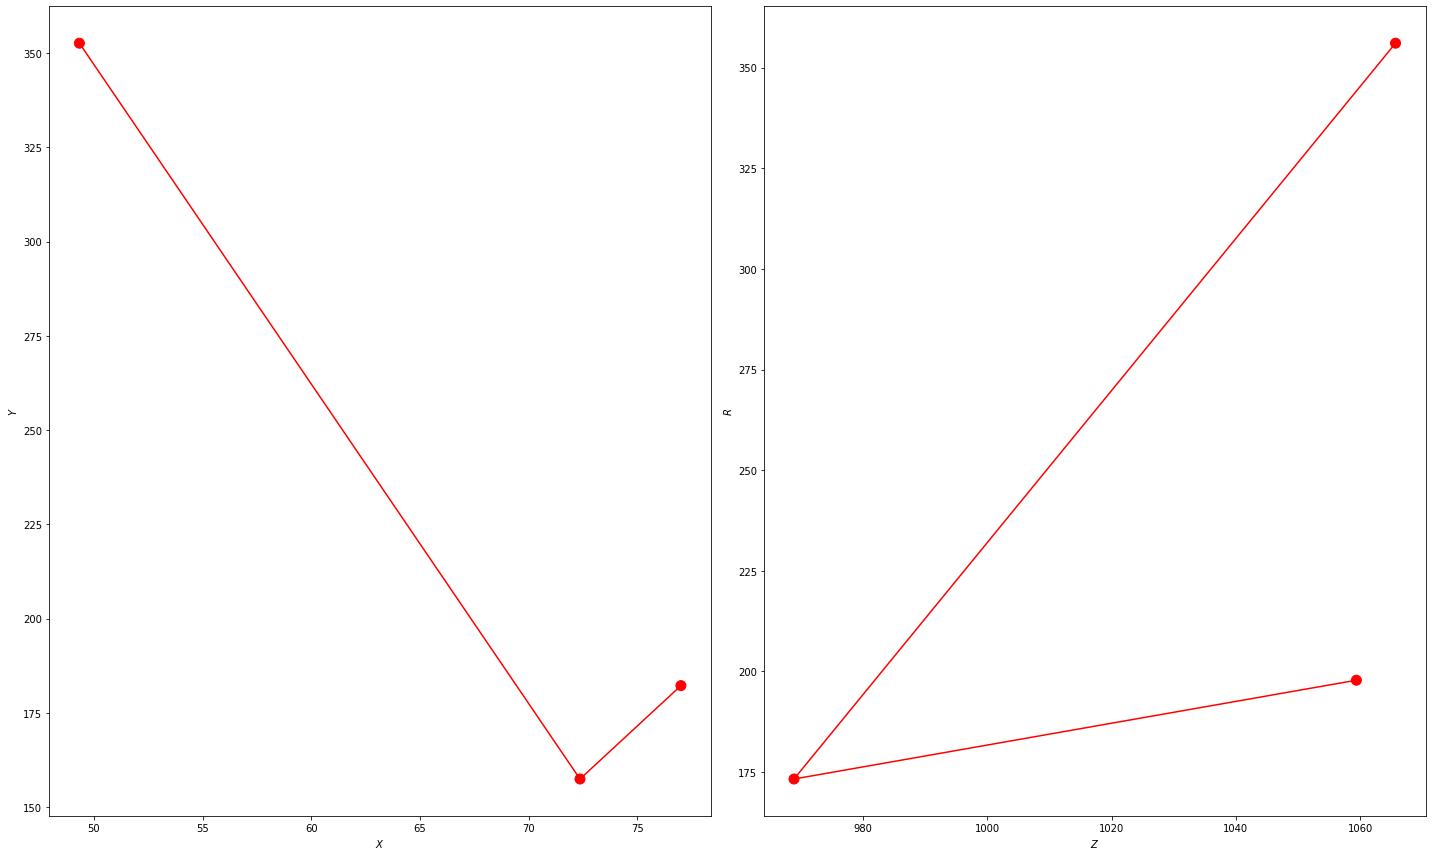

Event= 7    Sector= 9
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        3.0         1.0  159.012573   586.455078
1         1      1.0        3.0         1.0  433.000946   711.265564
2         2      1.0        3.0         2.0  219.717407   839.858521
3         4      1.0        3.0         4.0  266.840424  1013.733826
4         7      2.0        3.0         3.0  249.748352   964.500000
5         8      2.0        3.0         4.0  283.092804  1054.994995
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 3
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope          z0
0        0        1           0           1  -0.000362  514.019754
1        1        2           1           2  -0.002824  972.330586
2        4        5           7           8  -0.086162  286.696809
Event= 7    Sector= 9
Z_i= [964.50001001 711.26556396 586.45510674]
Z_o= [1054.99494076 

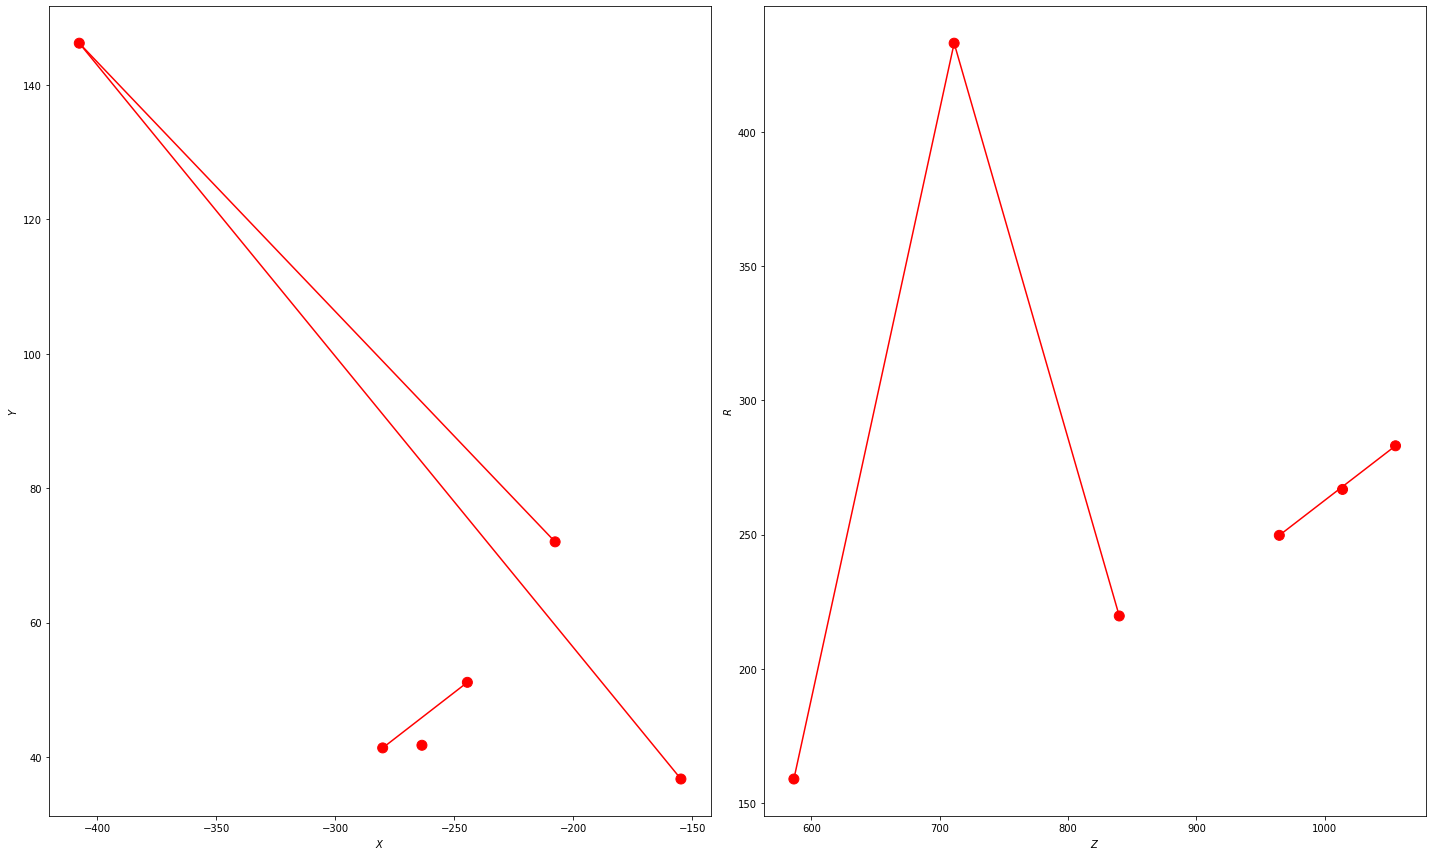

Event= 7    Sector= 10
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        4.0         1.0  246.270065  615.790344
1        11      4.0        4.0         1.0   82.392845  539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 7    Sector= 12
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         1      1.0        6.0         1.0  356.667999   683.776917
1         2      1.0        6.0         2.0  418.485352   814.815979
2         3      1.0        6.0         3.0  484.169128   948.965759
3         4      1.0        6.0         4.0  529.705566  1038.379761
4         6      2.0        6.0         2.0  409.119171   788.799988
5         6      2.0        6.0         2.0  356.149109   793.200012
6         8      2.0        6.0         4.0  535.161133  1061.295044
7        11      4.0        6.0         1.0   65.870407   539.349976
adj_layer_pairs= [[0

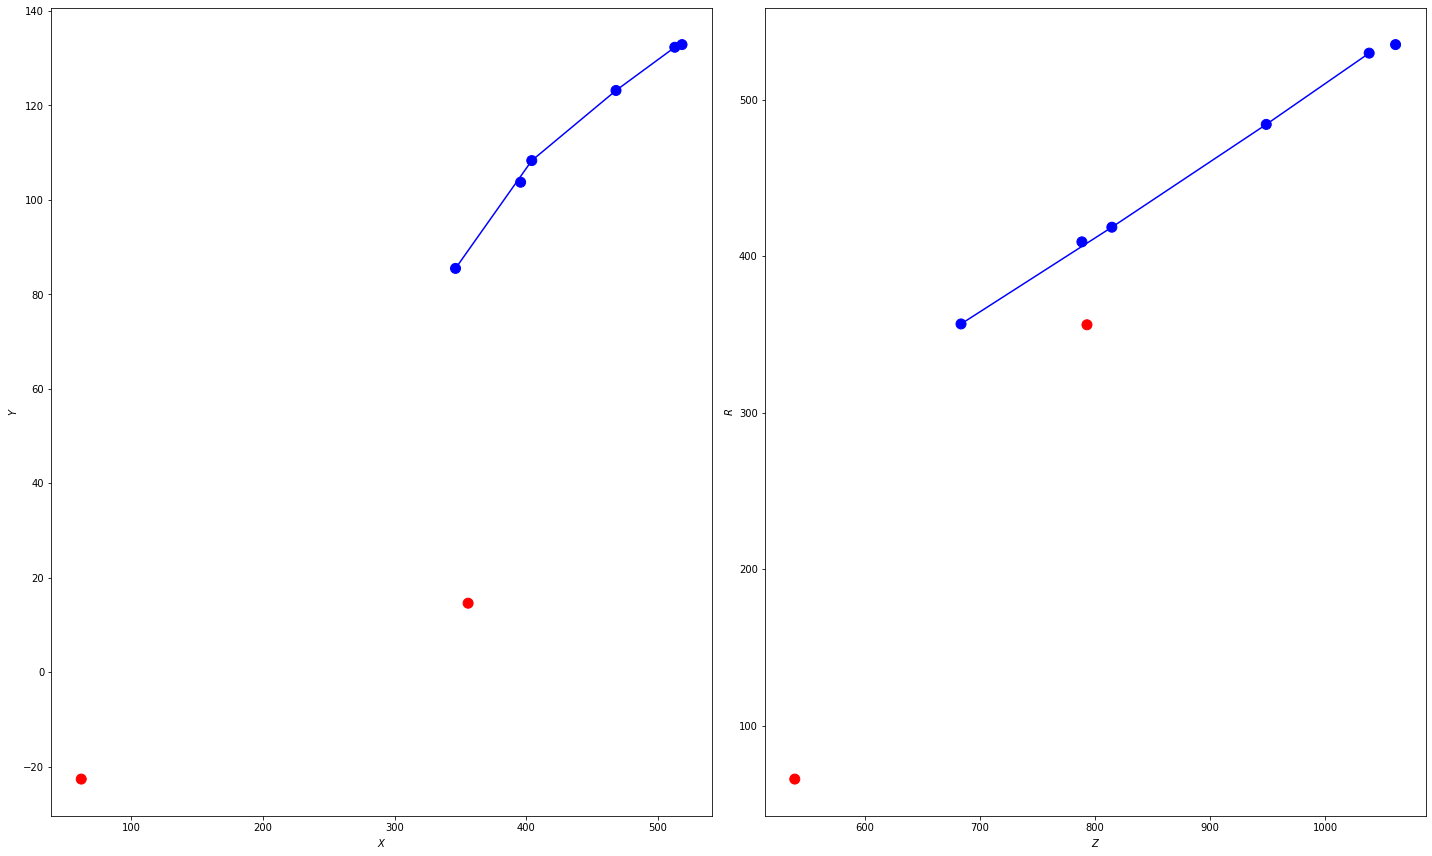

Event= 8    Sector= 1
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0       -99      0.0        1.0         1.0  447.300873  -533.237610
1         0      1.0        1.0         1.0  200.713242  -586.439270
2         0      1.0        1.0         1.0  192.704041  -586.398560
3         1      1.0        1.0         1.0  330.925568  -684.290588
4         2      1.0        1.0         2.0  251.306900  -814.990295
5         5      2.0        1.0         1.0  317.335175  -694.934570
6         7      2.0        1.0         3.0  180.969269  -968.900024
7         8      2.0        1.0         4.0  198.351425 -1059.395020
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 3
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope           z0
0        1        3           0           1  -0.092480  -435.608270
1        2        3           0           1  -0.055249  -449.920618
2        3    

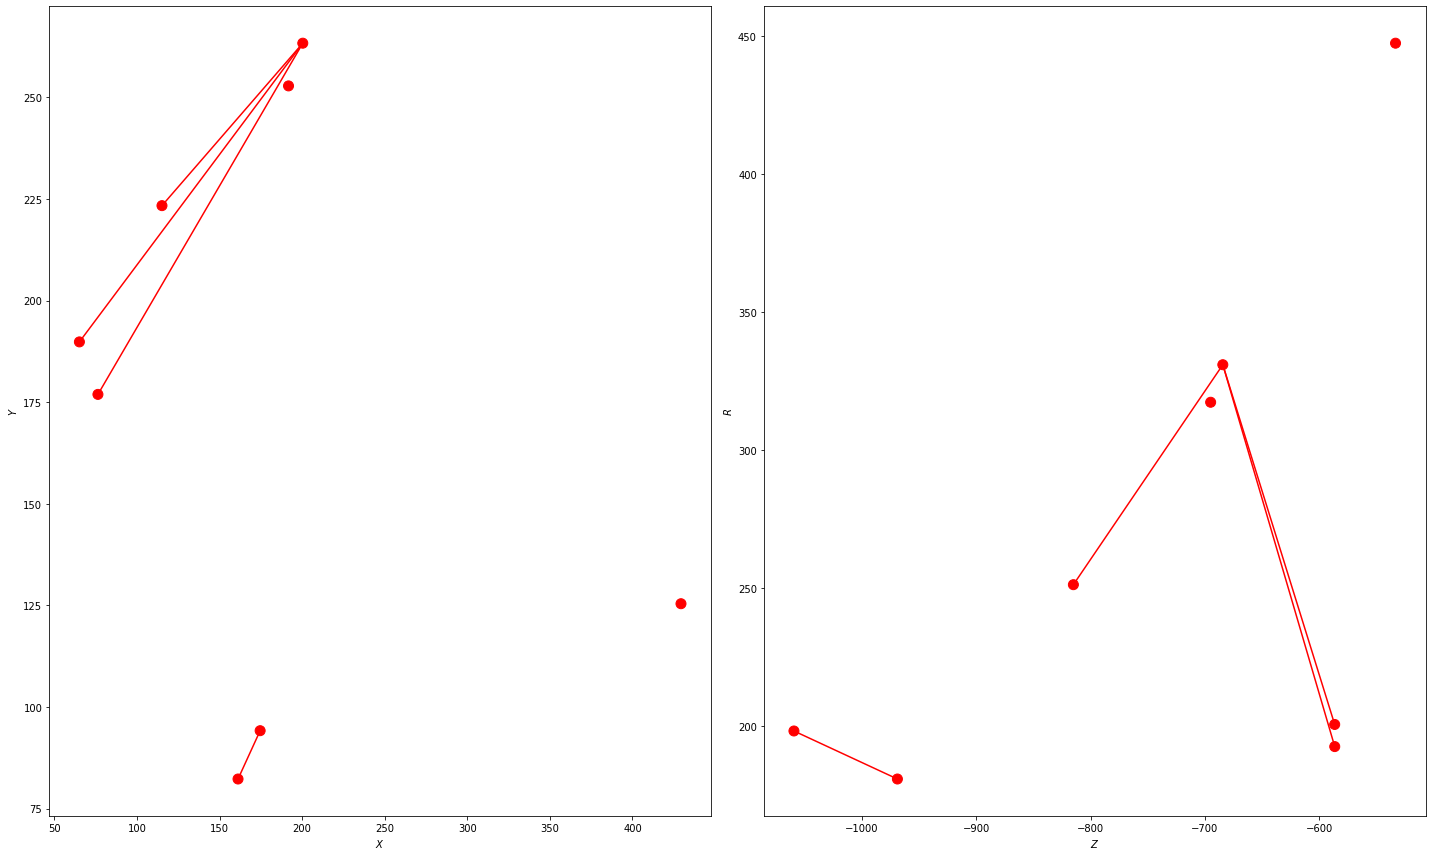

Event= 8    Sector= 2
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        2.0         1.0  200.713242 -586.439270
1         0      1.0        2.0         1.0  192.704041 -586.398560
2         2      1.0        2.0         2.0  251.306900 -814.990295
3         7      2.0        2.0         3.0  407.750000 -970.799988
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 8    Sector= 3
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        3.0         1.0  221.980652  -615.720337
1         2      1.0        3.0         2.0  289.727844  -814.870361
2         3      1.0        3.0         3.0  332.653107  -949.186707
3         5      2.0        3.0         1.0  316.960724  -694.934570
4         7      2.0        3.0         3.0  356.966644  -975.200012
5         8      2.0        3.0         4.0  356.329742 -1065.694946
6         9      3.0    

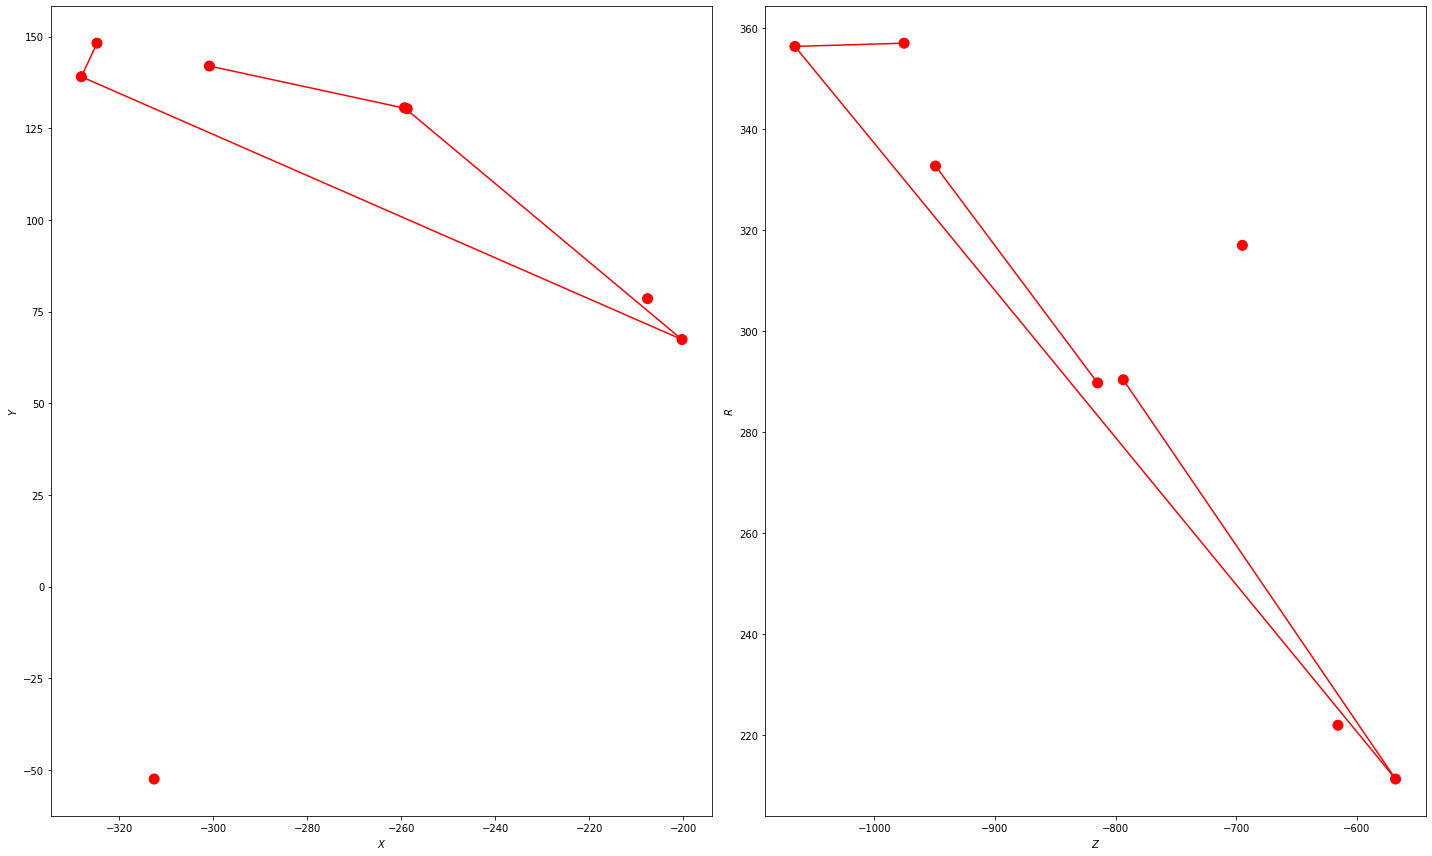

Event= 8    Sector= 4
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         4      1.0        4.0         4.0  218.215271 -1013.585815
1         5      2.0        4.0         1.0  316.960724  -694.934570
2         7      2.0        4.0         3.0  170.434372  -968.900024
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 1
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope           z0
0        0        1           4           5  -0.151112 -1717.765763
Event= 8    Sector= 4
Z_i= [-1013.58580589]
Z_o= [-694.93454695]


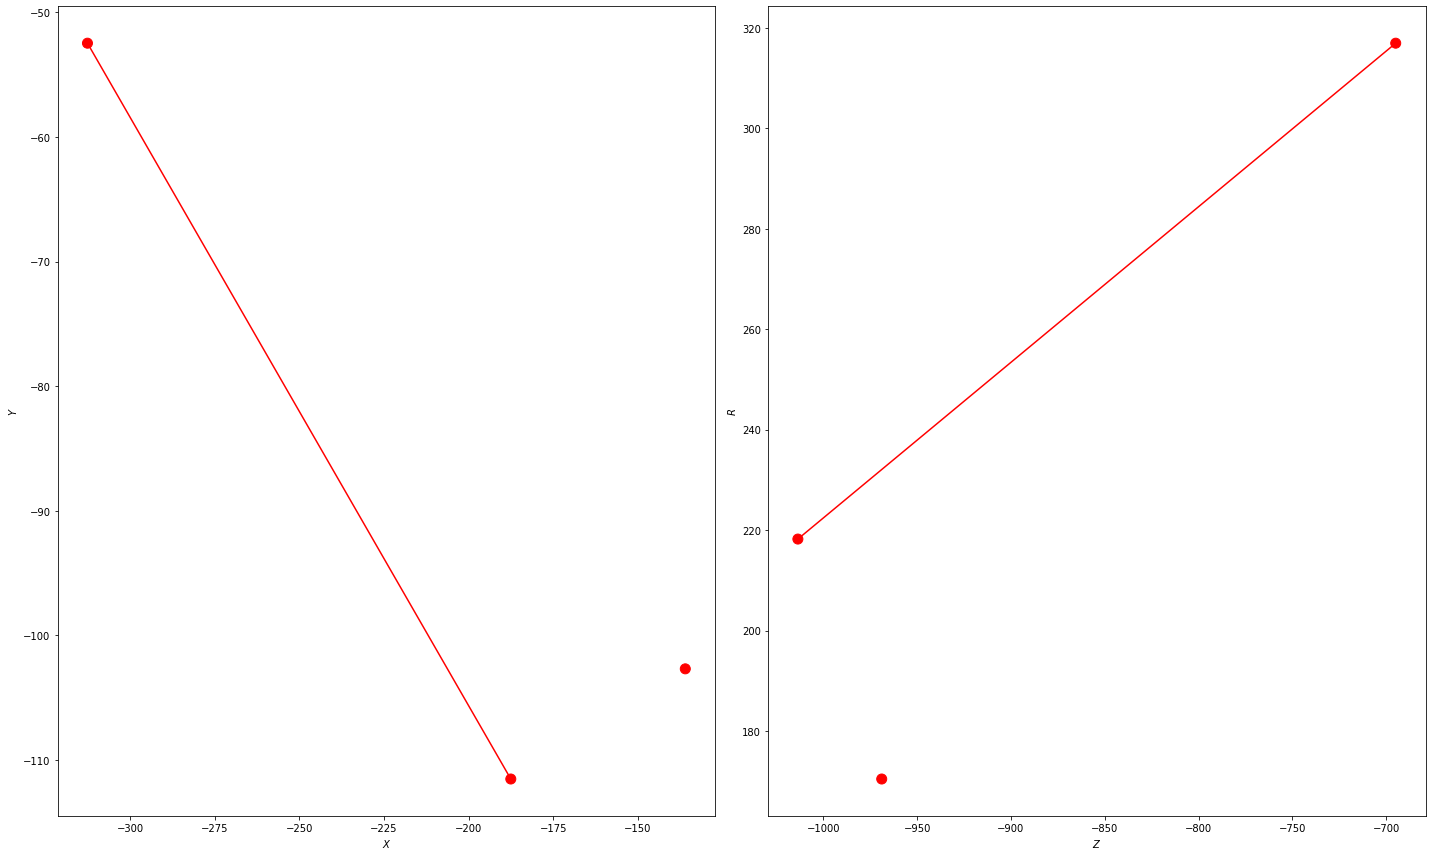

Event= 8    Sector= 5
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0       -99      0.0        5.0         1.0  447.343262  -533.243469
1         0      1.0        5.0         1.0  142.297058  -615.699646
2         0      1.0        5.0         1.0  129.388321  -615.711914
3         1      1.0        5.0         1.0  298.597626  -711.718506
4         5      2.0        5.0         1.0  317.753113  -725.950012
5         7      2.0        5.0         3.0  210.909241  -968.900024
6         8      2.0        5.0         4.0  194.829239 -1059.395020
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 2
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope           z0
0        1        3           0           1  -0.076456  -528.283449
1        2        3           0           1  -0.070634  -542.299097
2        5        6           7           8  -2.488739 -2155.854535
Event= 8    Sec

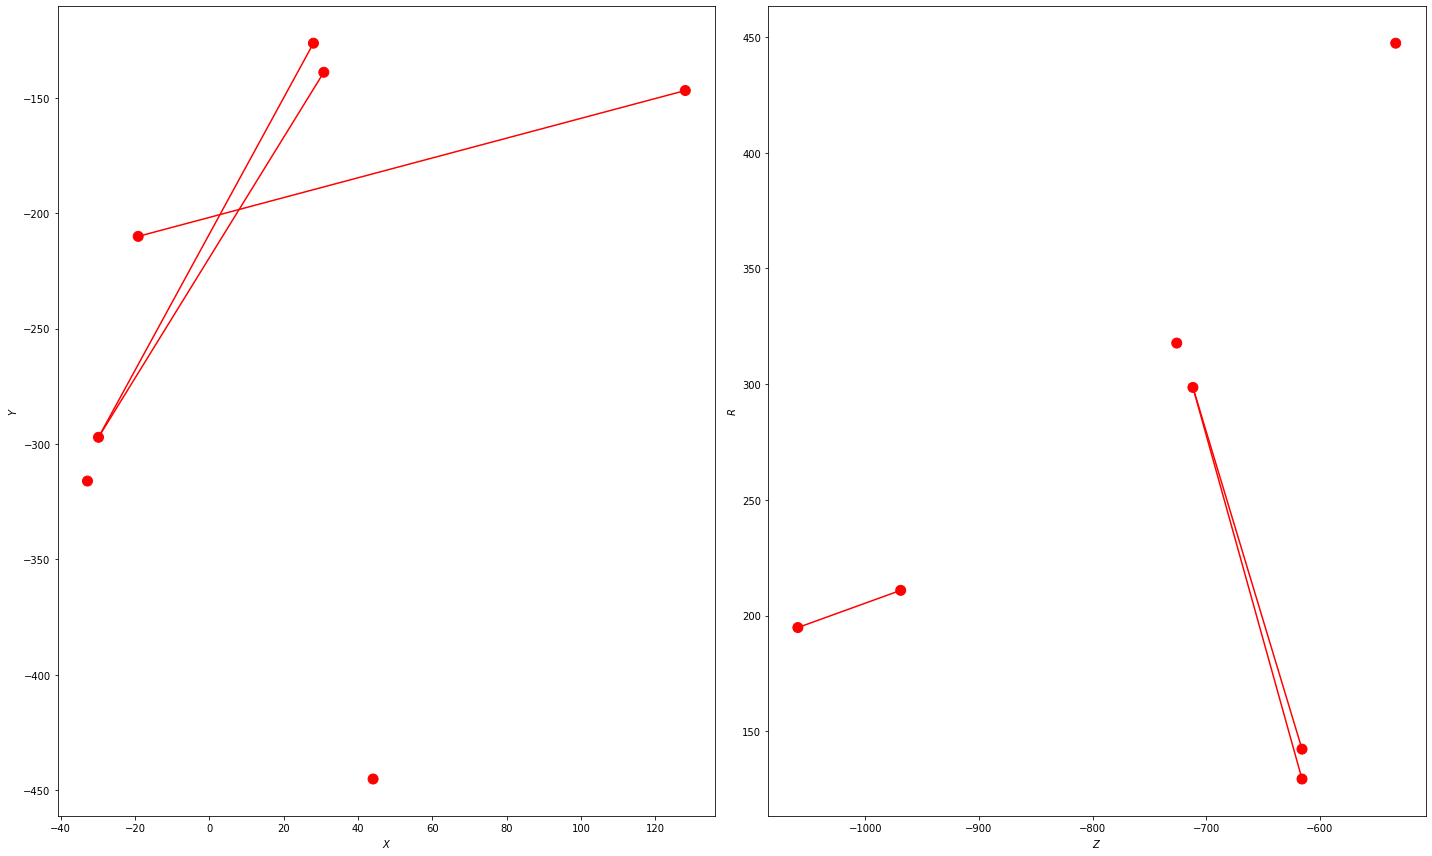

Event= 8    Sector= 6
    vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0        -99      0.0        6.0         1.0  447.300873  -533.237610
1          0      1.0        6.0         1.0  136.870987  -586.350342
2          2      1.0        6.0         2.0  192.137527  -814.876282
3          3      1.0        6.0         3.0  214.547363  -924.107178
4          3      1.0        6.0         3.0  221.415680  -948.921082
5          4      1.0        6.0         4.0  232.247314 -1013.595642
6          7      2.0        6.0         3.0  171.660950  -964.500000
7          7      2.0        6.0         3.0  228.921616  -964.500000
8          8      2.0        6.0         4.0  194.829239 -1059.395020
9          8      2.0        6.0         4.0  242.056686 -1054.994995
10        11      4.0        6.0         1.0  128.179489  -539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 3
df_segments=

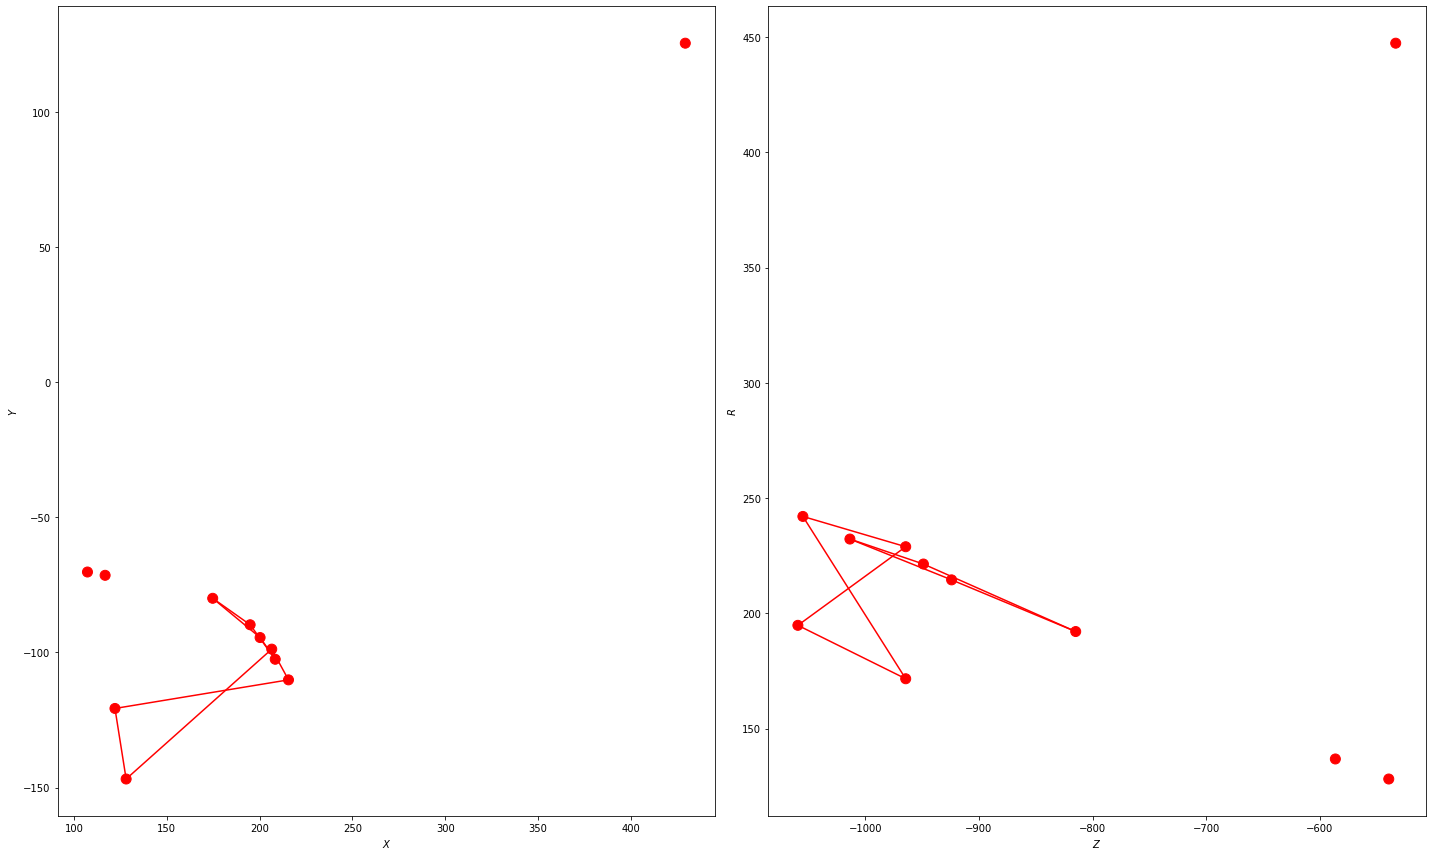

Event= 8    Sector= 7
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        1.0         1.0  172.139191  615.759216
1         0      1.0        1.0         1.0  105.042473  586.354065
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 8    Sector= 8
   vh_layer  vh_type  vh_sector  vh_station   vh_sim_r    vh_sim_z
0        11      4.0        2.0         1.0  66.211082  539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 8    Sector= 9
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r   vh_sim_z
0         0      1.0        3.0         1.0  118.337418  615.74585
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 8    Sector= 10
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        4.0         1.0 

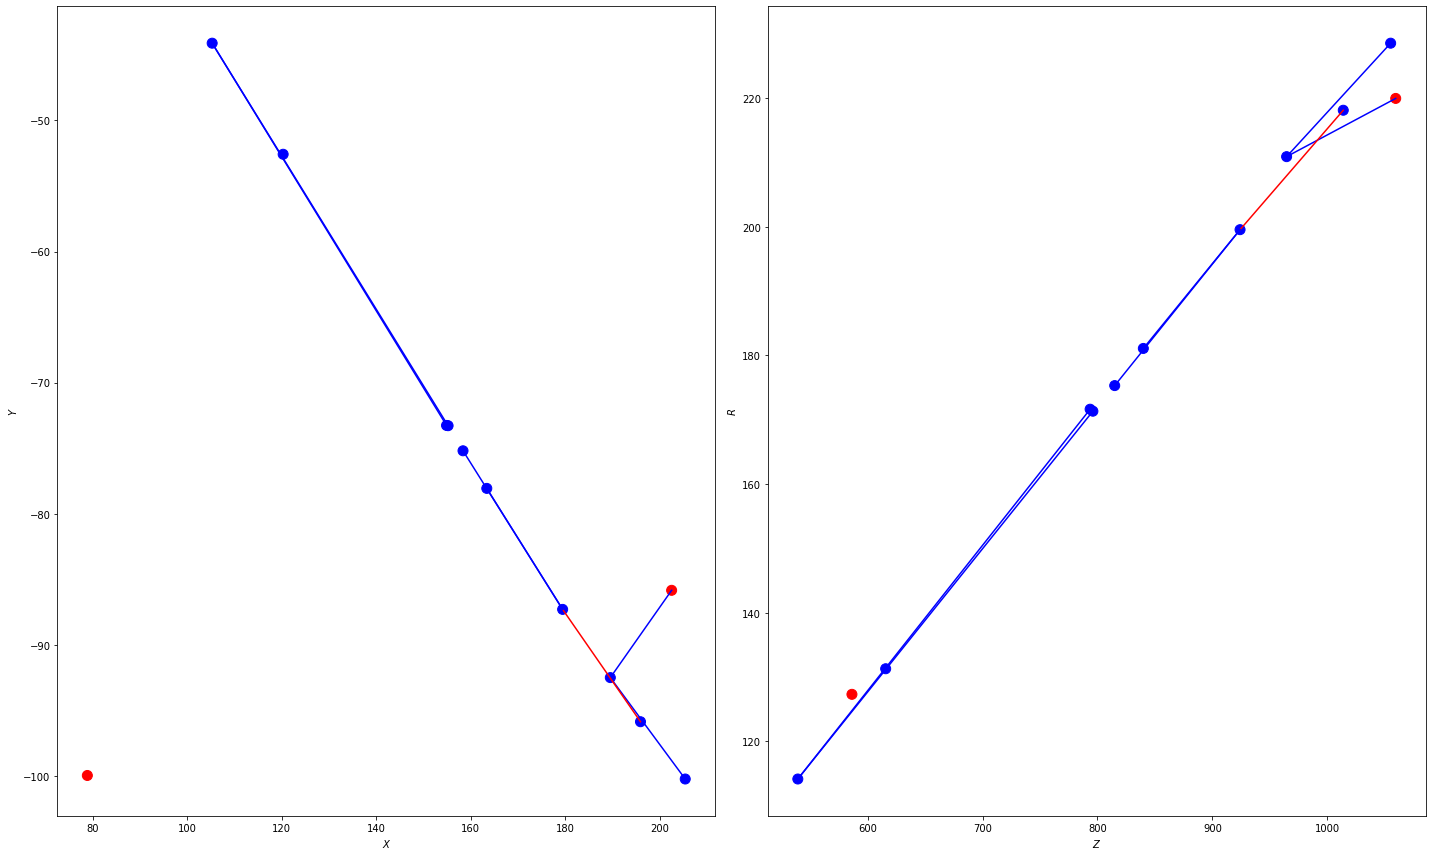

Event= 9    Sector= 1
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        1.0         1.0  124.553436 -615.722351
1        11      4.0        1.0         1.0   66.500801 -539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 9    Sector= 2
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        2.0         1.0  127.221924  -586.401367
1         8      2.0        2.0         4.0  245.719666 -1059.395020
2         8      2.0        2.0         4.0  200.445709 -1054.994995
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 9    Sector= 3
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0       -99      2.0        3.0         2.0  604.156311  -788.799988
1         0      1.0        3.0         1.0  138.597214  -615.722656
2         8      2.0        3

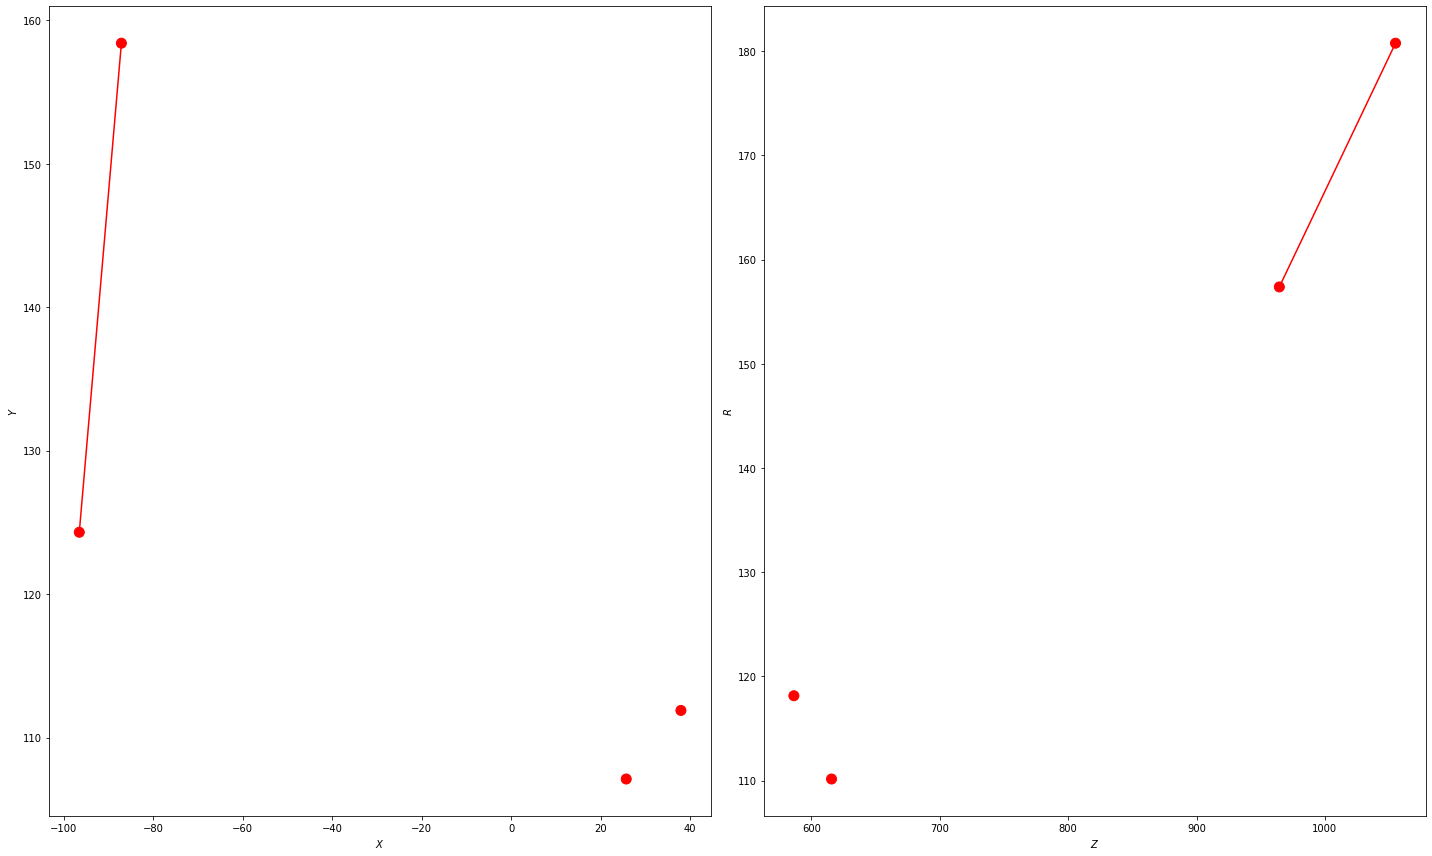

Event= 9    Sector= 9
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        3.0         1.0  222.056381   615.746094
1         0      1.0        3.0         1.0  245.227524   615.734497
2         7      2.0        3.0         3.0  157.377045   964.500000
3         8      2.0        3.0         4.0  224.637161  1059.395020
4         8      2.0        3.0         4.0  180.766800  1054.994995
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 1
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope          z0
0        2        3           7           8  -4.341982  742.462060
1        2        4           7           8  -0.116975  355.607998
Event= 9    Sector= 9
Z_i= [964.50001001 964.50001001]
Z_o= [1054.99494076 1059.39507484]


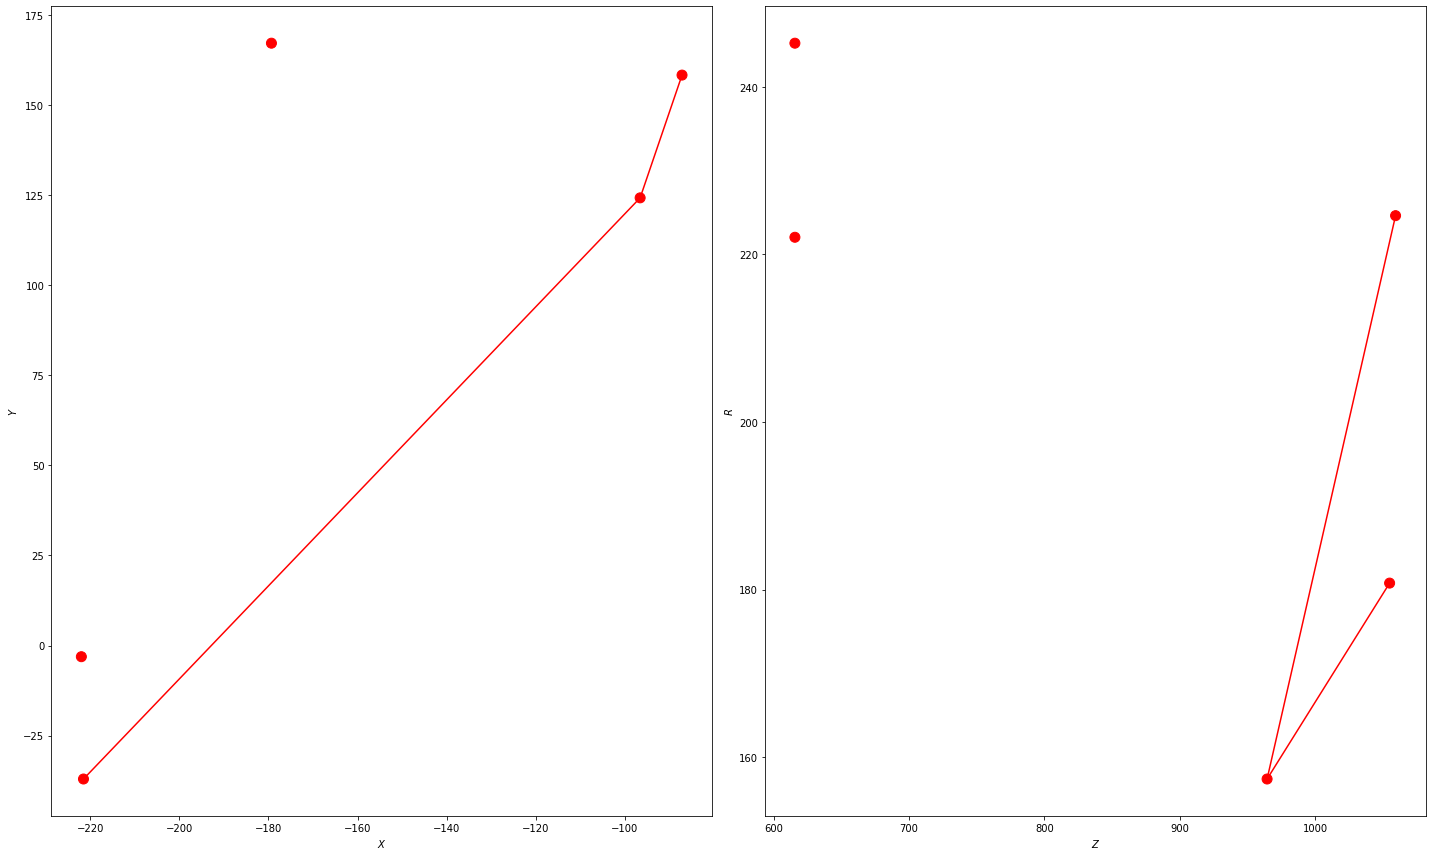

Event= 9    Sector= 10
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        4.0         1.0  189.511322   586.477966
1         2      1.0        4.0         2.0  150.814850   839.791565
2         3      1.0        4.0         3.0  265.027863   923.946533
3         7      2.0        4.0         3.0  277.251953   964.500000
4         8      2.0        4.0         4.0  293.453857  1054.994995
5         8      2.0        4.0         4.0  224.637161  1059.395020
6         9      3.0        4.0         1.0  222.468765   565.368774
7        10      3.0        4.0         2.0  241.752090   796.001221
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 4
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope            z0
0        1        2           2           3  -0.369967    728.667459
1        3        4           7           8   0.168252   -584.078098
2        3

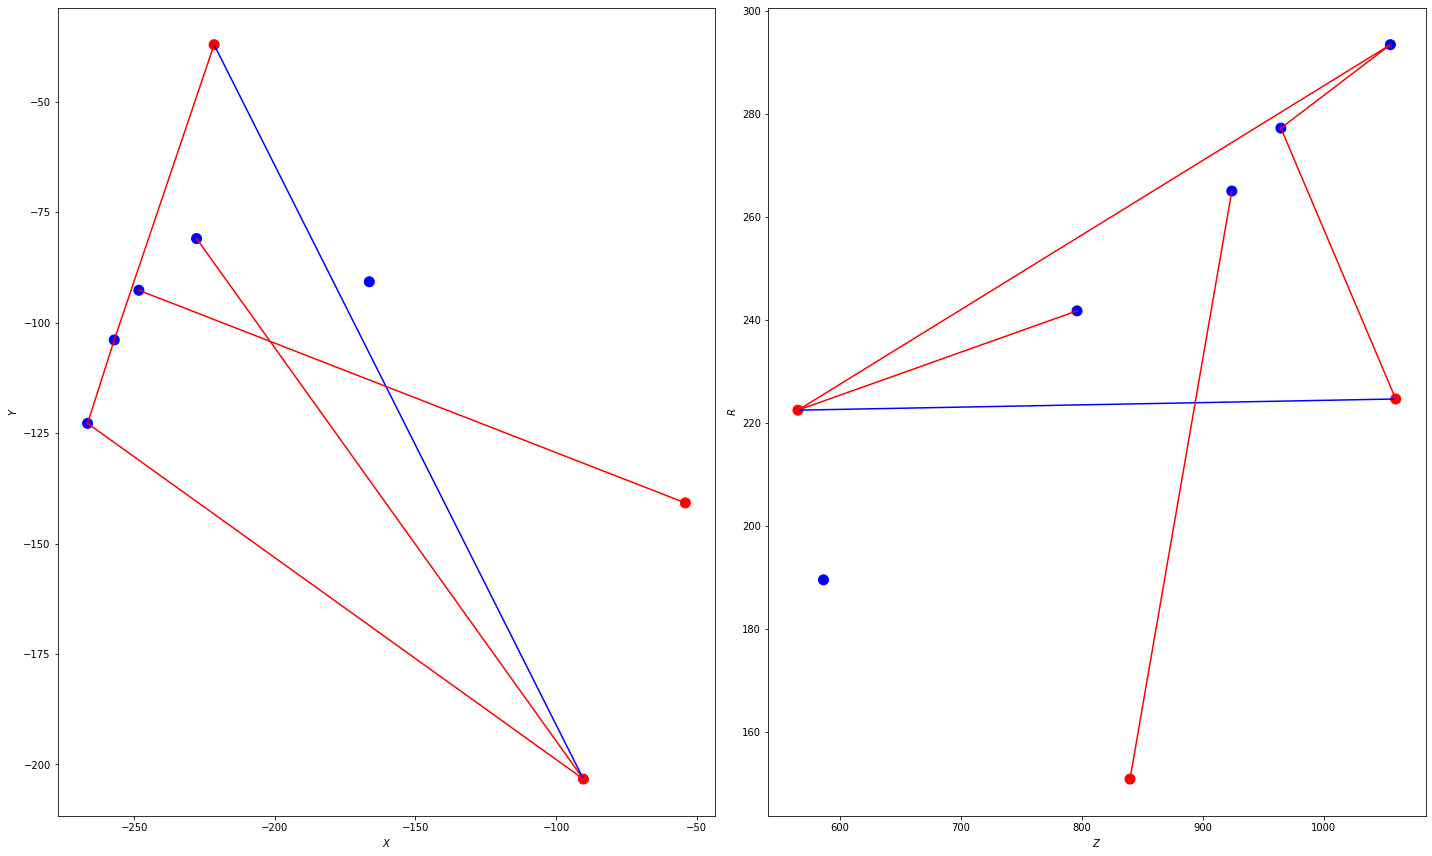

Event= 9    Sector= 11
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         2      1.0        5.0         2.0  150.497925   839.791626
1         2      1.0        5.0         2.0  150.814850   839.791565
2         3      1.0        5.0         3.0  166.566544   923.859863
3         7      2.0        5.0         3.0  176.118073   964.500000
4         8      2.0        5.0         4.0  194.756775  1054.994995
5         9      3.0        5.0         1.0  222.468765   565.368774
6        11      4.0        5.0         1.0   93.052162   539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 3
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope           z0
0        0        2           2           3  -0.033125    52.412484
1        1        2           2           3   1.767736    34.878264
2        3        4           7           8  -0.030678   109.408064
3        4    

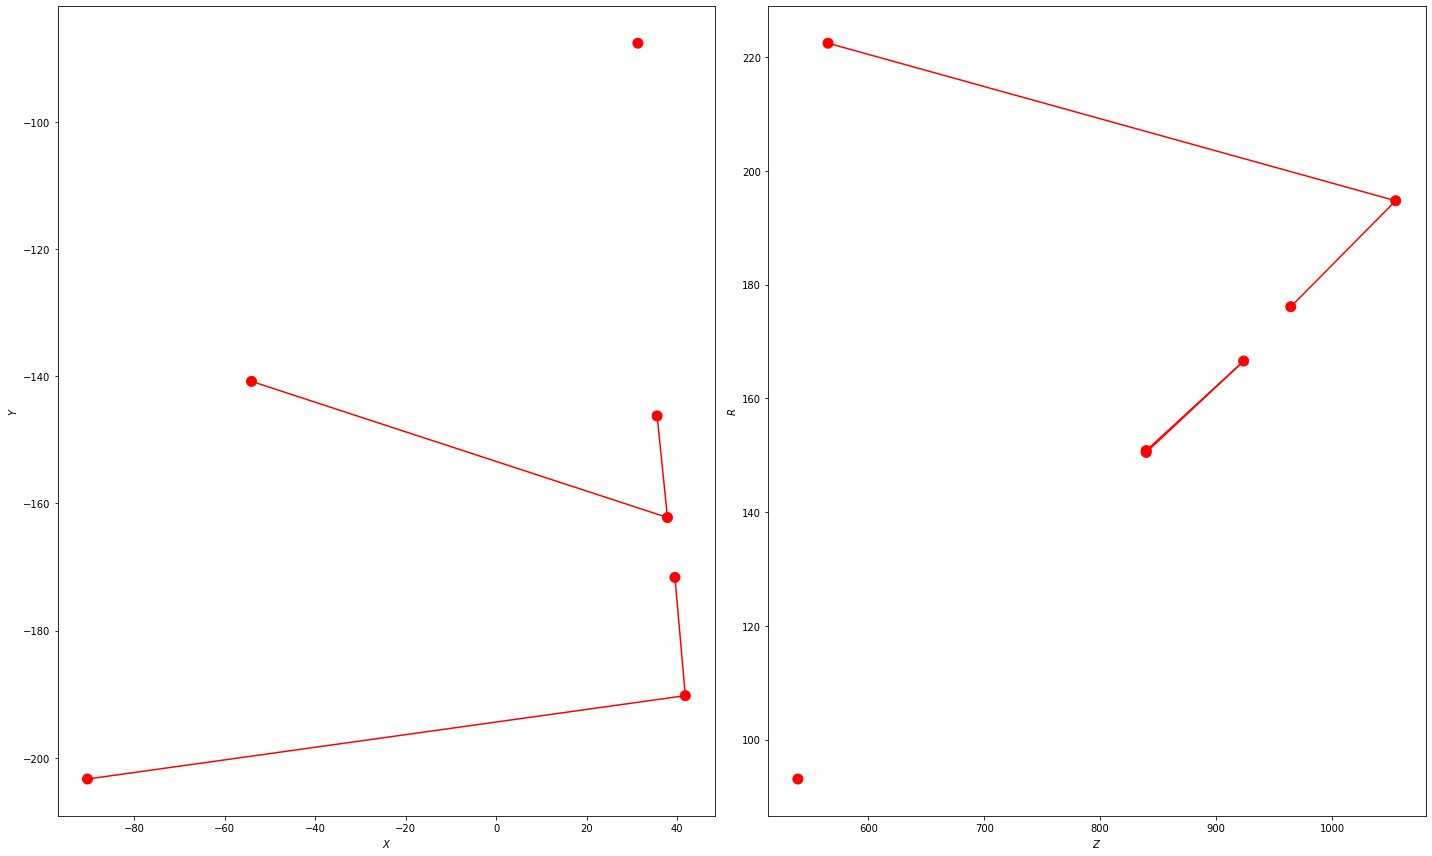

Event= 9    Sector= 12
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        6.0         1.0  175.144302  615.758179
1         0      1.0        6.0         1.0  180.057816  615.803650
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 10    Sector= 1
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        1.0         1.0  209.261642 -586.386719
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 10    Sector= 2
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0       -99      0.0        2.0         1.0  447.434326  -533.325684
1         0      1.0        2.0         1.0  209.261642  -586.386719
2         7      2.0        2.0         3.0  168.568741  -964.500000
3         8      2.0        2.0         4.0  187.918289 -1054.994995
adj_layer_pairs= [[0, 1], [1

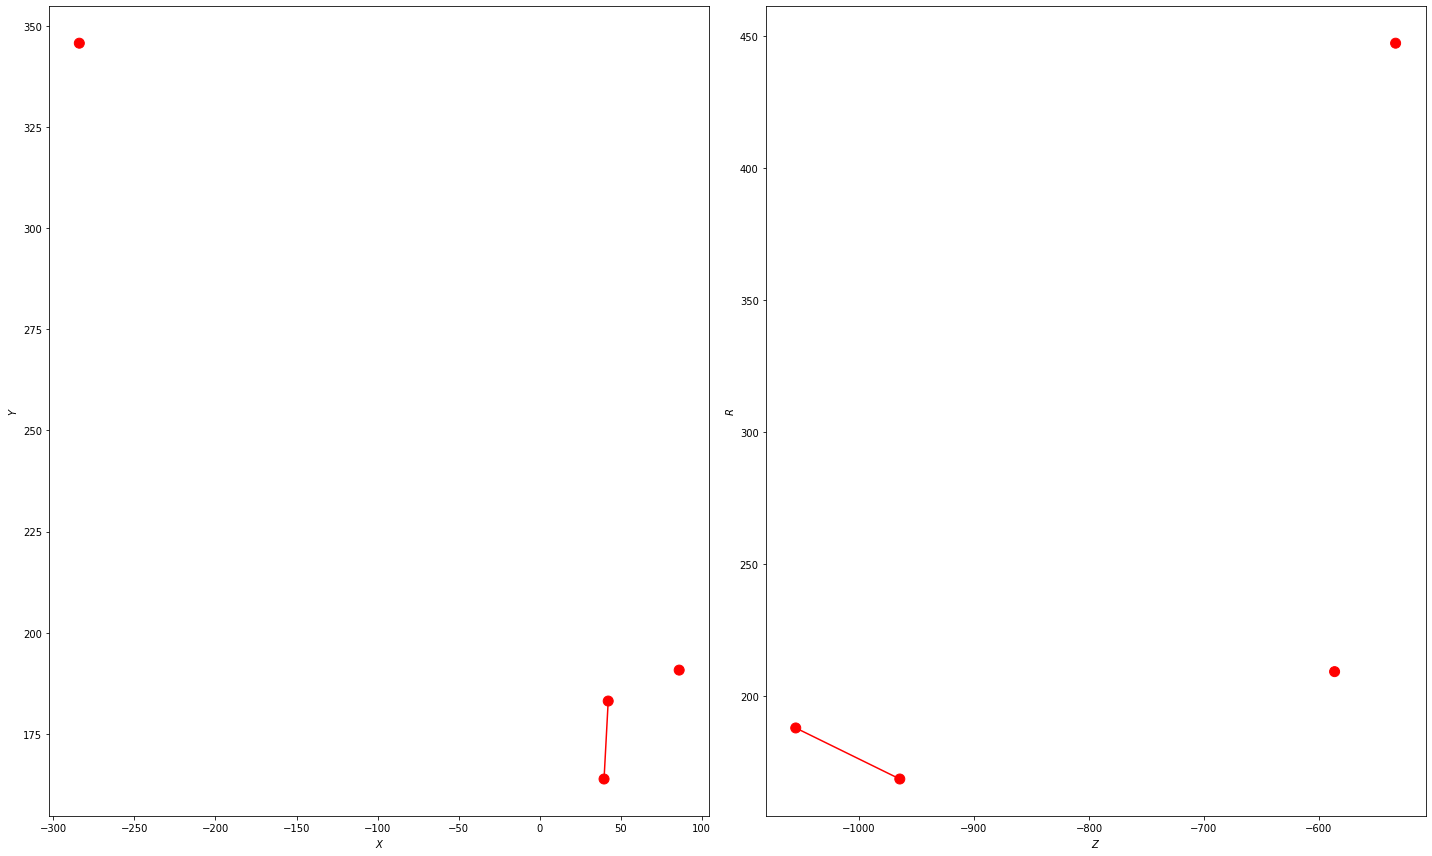

Event= 10    Sector= 3
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0       -99      0.0        3.0         1.0  447.434326  -533.325684
1         0      1.0        3.0         1.0  117.290359  -615.698242
2         7      2.0        3.0         3.0  168.538940  -964.500000
3         8      2.0        3.0         4.0  185.634644 -1054.994995
4        10      3.0        3.0         2.0  313.032104  -793.598755
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 1
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope         z0
0        2        3           7           8  -0.024557 -72.350056
Event= 10    Sector= 3
Z_i= [-964.50001001]
Z_o= [-1054.99494076]


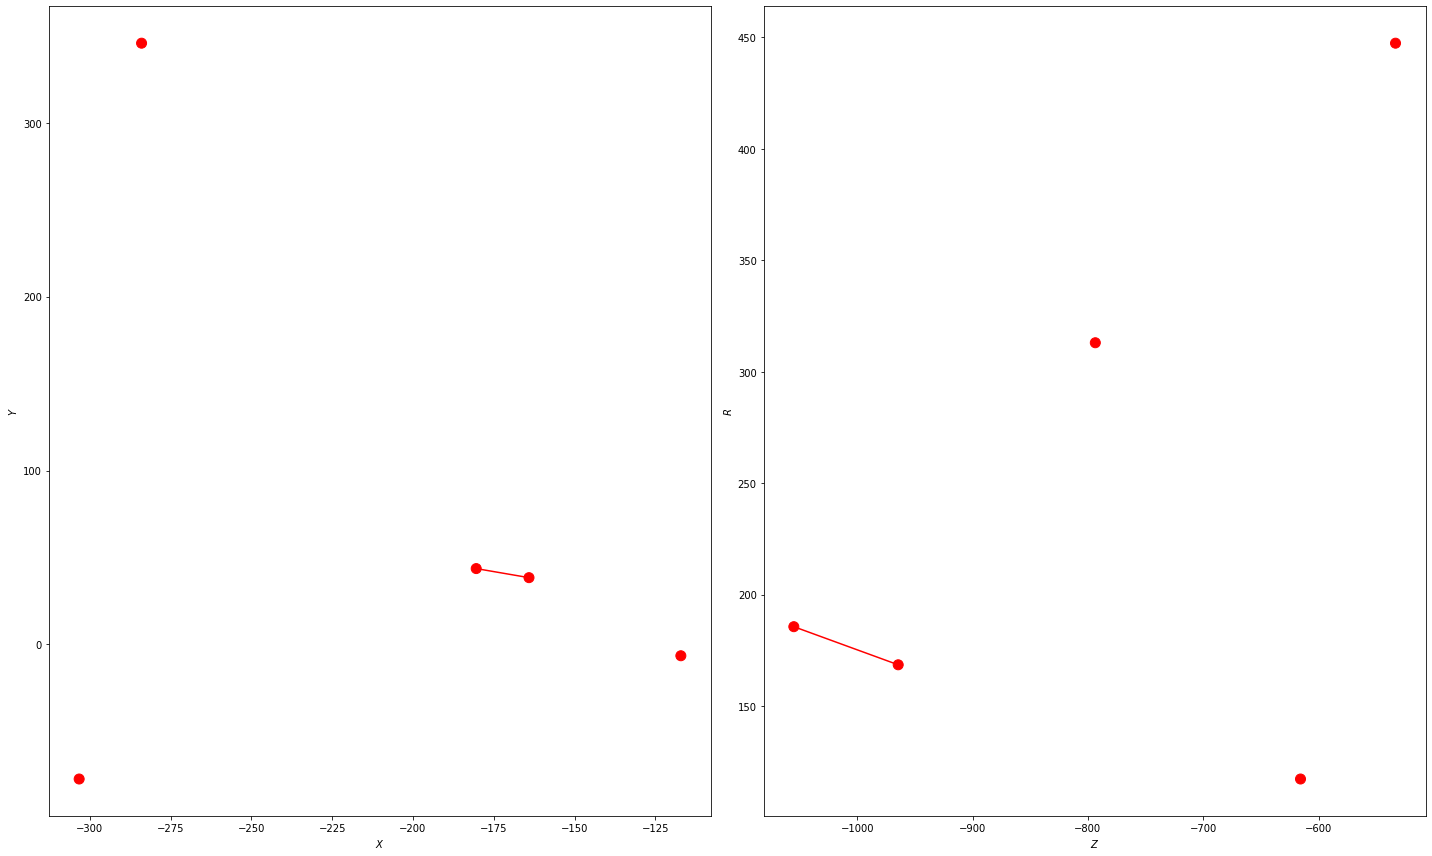

Event= 10    Sector= 4
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         1      1.0        4.0         1.0  343.765778 -684.241821
1         5      2.0        4.0         1.0  317.379150 -694.934570
2         5      2.0        4.0         1.0  317.068939 -725.950012
3         5      2.0        4.0         1.0  318.018799 -694.934570
4        10      3.0        4.0         2.0  313.032104 -793.598755
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 10    Sector= 6
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        6.0         1.0  138.109711  -615.661987
1         2      1.0        6.0         2.0  301.271393  -814.974976
2         4      1.0        6.0         4.0  381.724792 -1038.429321
3         7      2.0        6.0         3.0  355.883240  -970.799988
4         8      2.0        6.0         4.0  408.421448 -1061.295044
5        11      4.0   

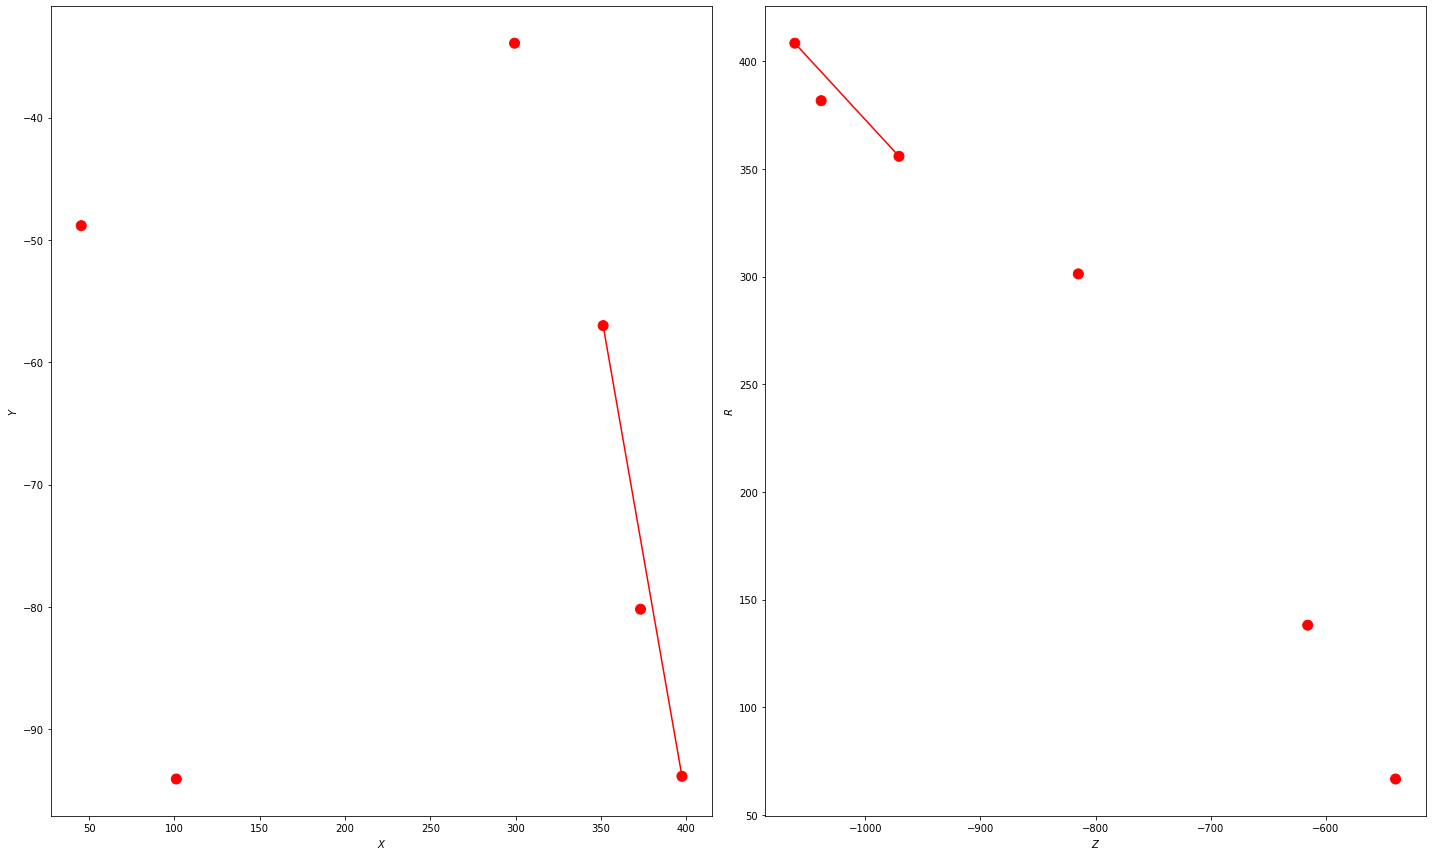

Event= 10    Sector= 7
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r   vh_sim_z
0         0      1.0        1.0         1.0  202.763702  586.41748
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 10    Sector= 8
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        2.0         1.0  152.170410   615.821045
1         0      1.0        2.0         1.0  132.770401   586.520996
2         4      1.0        2.0         4.0  226.566971  1013.901550
3         7      2.0        2.0         3.0  223.393311   964.500000
4         8      2.0        2.0         4.0  234.198593  1054.994995
5         9      3.0        2.0         1.0  145.825943   567.971252
6        10      3.0        2.0         2.0  193.996796   796.001221
7        11      4.0        2.0         1.0  135.018860   539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], 

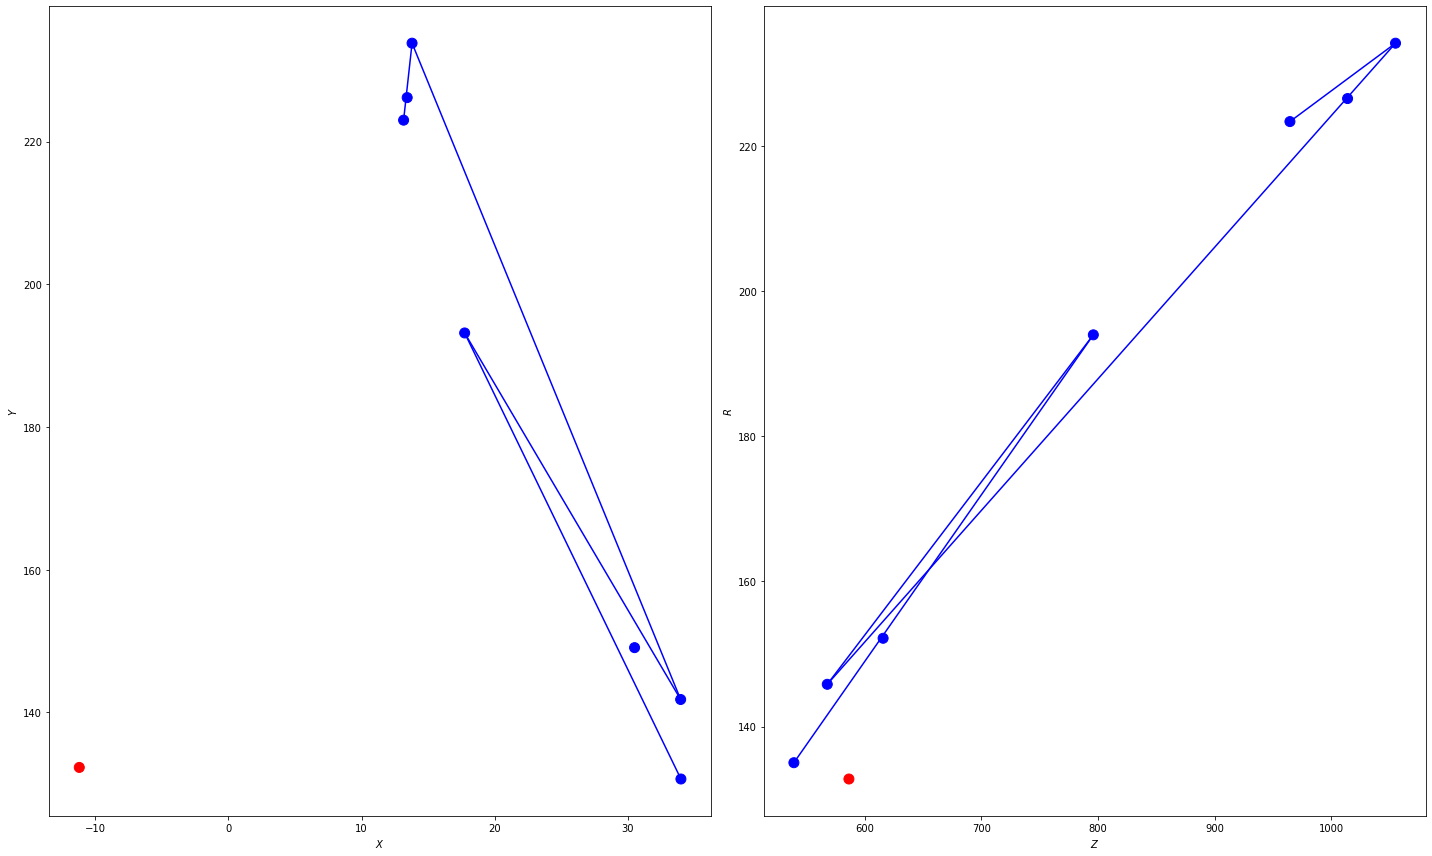

Event= 10    Sector= 9
   vh_layer  vh_type  vh_sector  vh_station   vh_sim_r    vh_sim_z
0        11      4.0        3.0         1.0  66.193962  539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 10    Sector= 10
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        4.0         1.0  111.775177   615.704590
1         2      1.0        4.0         2.0  155.113297   839.811462
2         3      1.0        4.0         3.0  170.483459   923.879700
3         7      2.0        4.0         3.0  179.493393   964.500000
4         8      2.0        4.0         4.0  196.526062  1054.994995
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 2
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope         z0
0        1        2           2           3   0.017685  -8.592126
1        3        4      

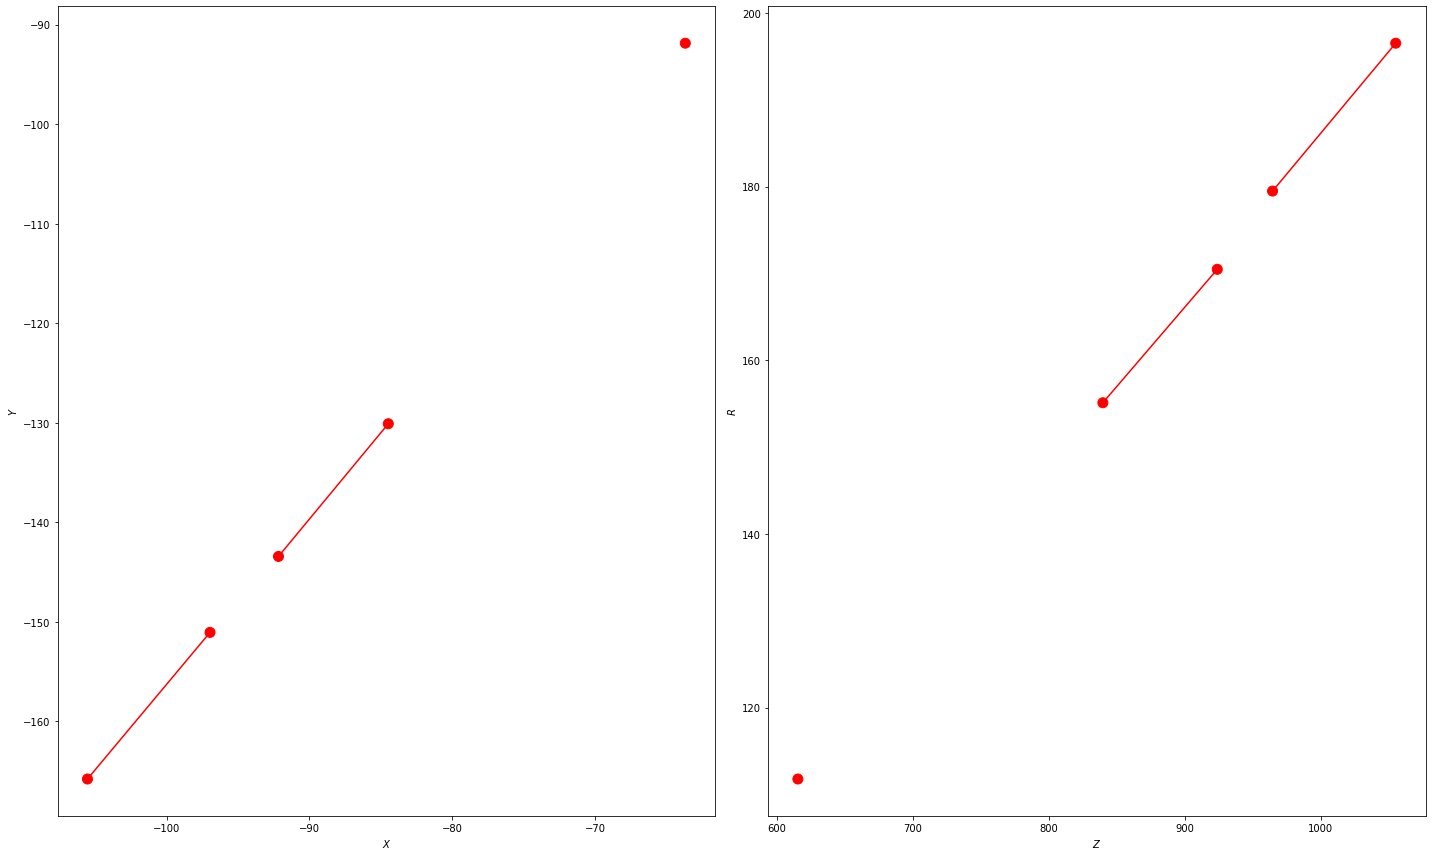

Event= 10    Sector= 11
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        5.0         1.0  184.824142   615.736511
1         2      1.0        5.0         2.0  155.113297   839.811462
2         3      1.0        5.0         3.0  170.483459   923.879700
3         7      2.0        5.0         3.0  179.493393   964.500000
4         8      2.0        5.0         4.0  196.526062  1054.994995
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 2
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope         z0
0        1        2           2           3   0.017685  -8.592126
1        3        4           7           8   0.012546  10.847131
Event= 10    Sector= 11
Z_i= [964.50001001 839.81144428]
Z_o= [1054.99494076  923.87968302]


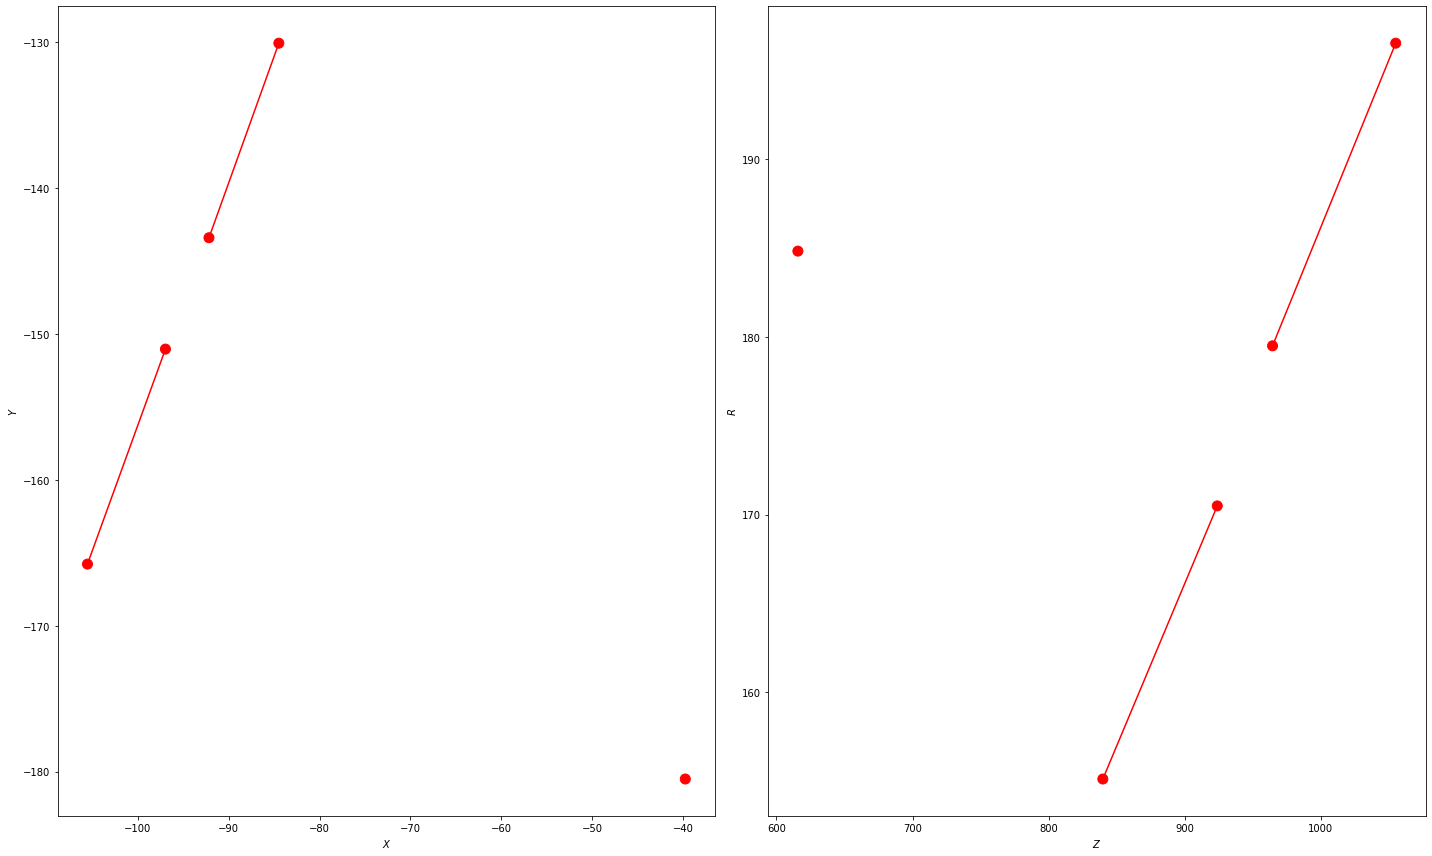

Event= 10    Sector= 12
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r   vh_sim_z
0         0      1.0        6.0         1.0  182.652603  586.45459
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 11    Sector= 1
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        1.0         1.0  132.721573 -615.693665
1         0      1.0        1.0         1.0  112.036171 -615.701477
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 11    Sector= 3
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        3.0         1.0  250.986404 -615.797302
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 11    Sector= 4
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        4.0       

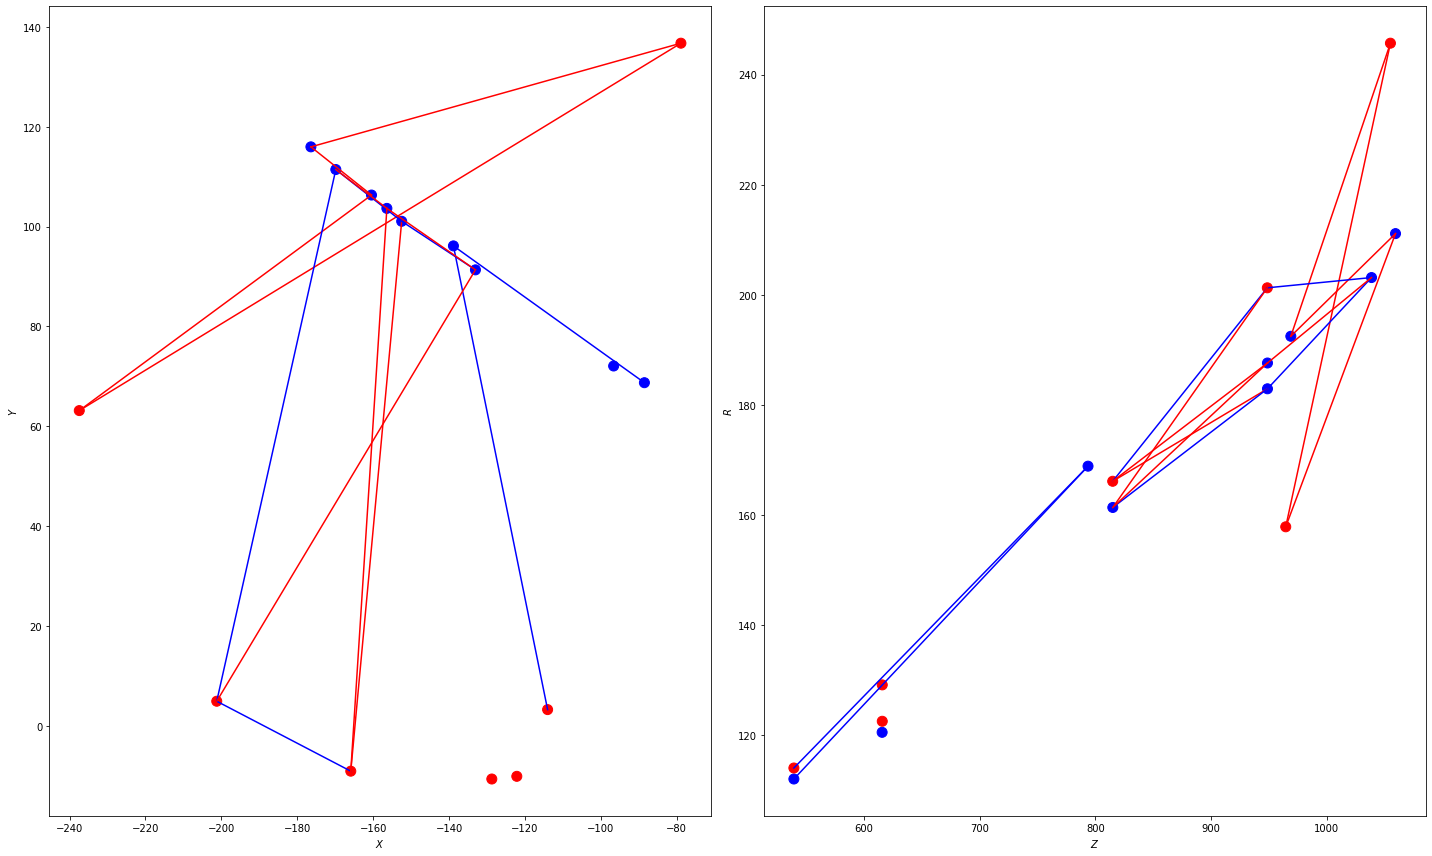

Event= 11    Sector= 10
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        4.0         1.0  128.770325   615.761169
1         2      1.0        4.0         2.0  166.154343   814.924438
2         3      1.0        4.0         3.0  201.282028   948.585205
3         5      2.0        4.0         1.0  317.816010   725.950012
4         5      2.0        4.0         1.0  317.578644   694.934570
5         7      2.0        4.0         3.0  356.190308   970.799988
6         8      2.0        4.0         4.0  356.493073  1065.694946
7        10      3.0        4.0         2.0  309.265045   793.598755
8        11      4.0        4.0         1.0  114.091270   539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 3
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope             z0
0        1        2           2           3   9.940344     182.707528
1      

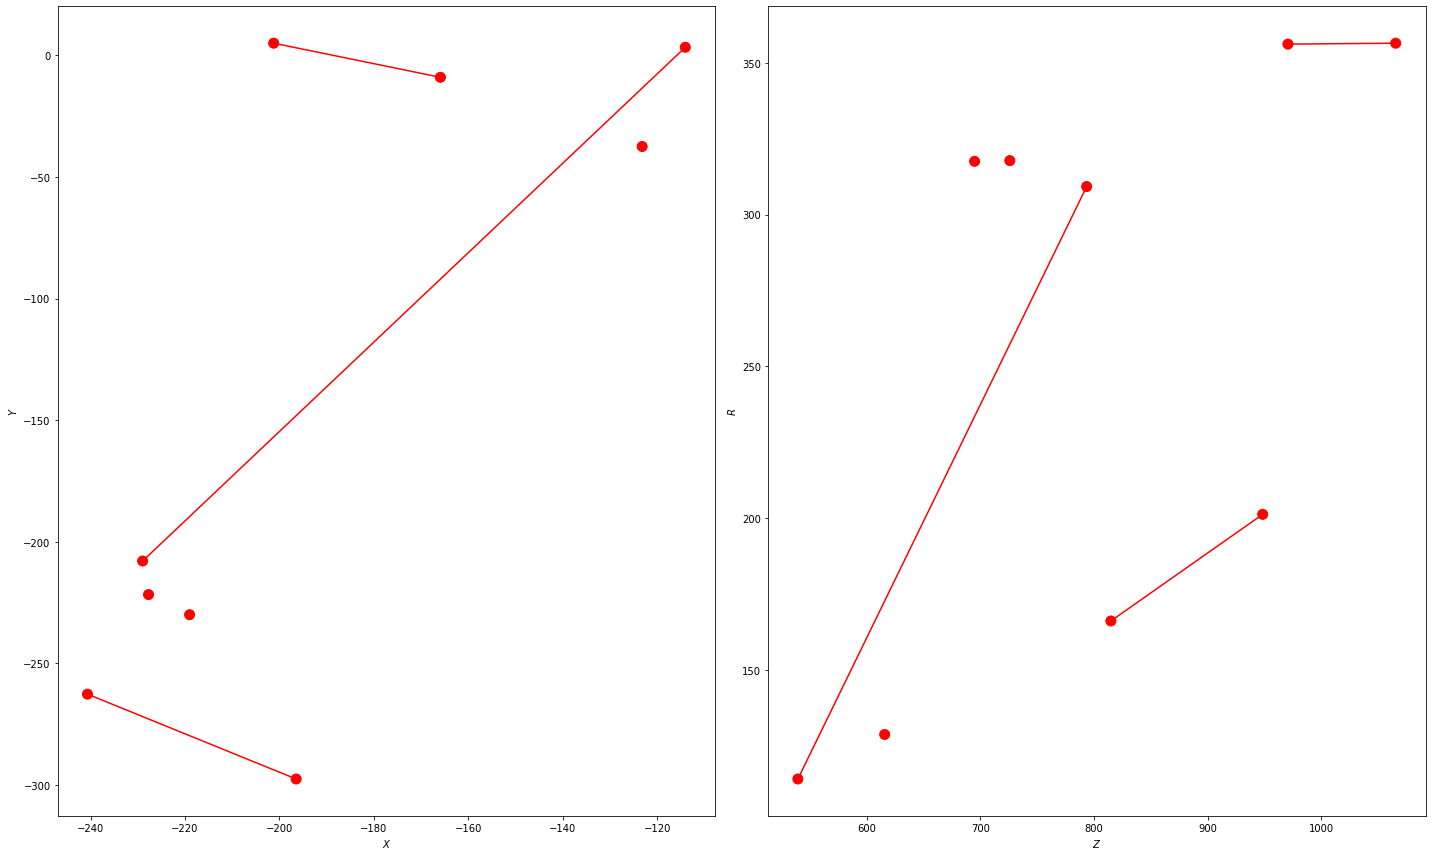

Event= 11    Sector= 12
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0         0      1.0        6.0         1.0  215.485519  615.783691
1         1      1.0        6.0         1.0  295.758301  711.362854
2         2      1.0        6.0         2.0  314.808014  815.031738
3         3      1.0        6.0         3.0  338.841736  948.617004
4         3      1.0        6.0         3.0  333.534882  948.756592
5         5      2.0        6.0         1.0  317.217529  725.950012
6         7      2.0        6.0         3.0  356.381561  975.200012
7        10      3.0        6.0         2.0  308.915192  793.598755
8        11      4.0        6.0         1.0   75.140656  539.349976
9        11      4.0        6.0         1.0  102.287636  539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 4
df_segments=    index_1  index_2  vh_layer_1  vh_layer_2  phi_slope           z0
0        0        1  

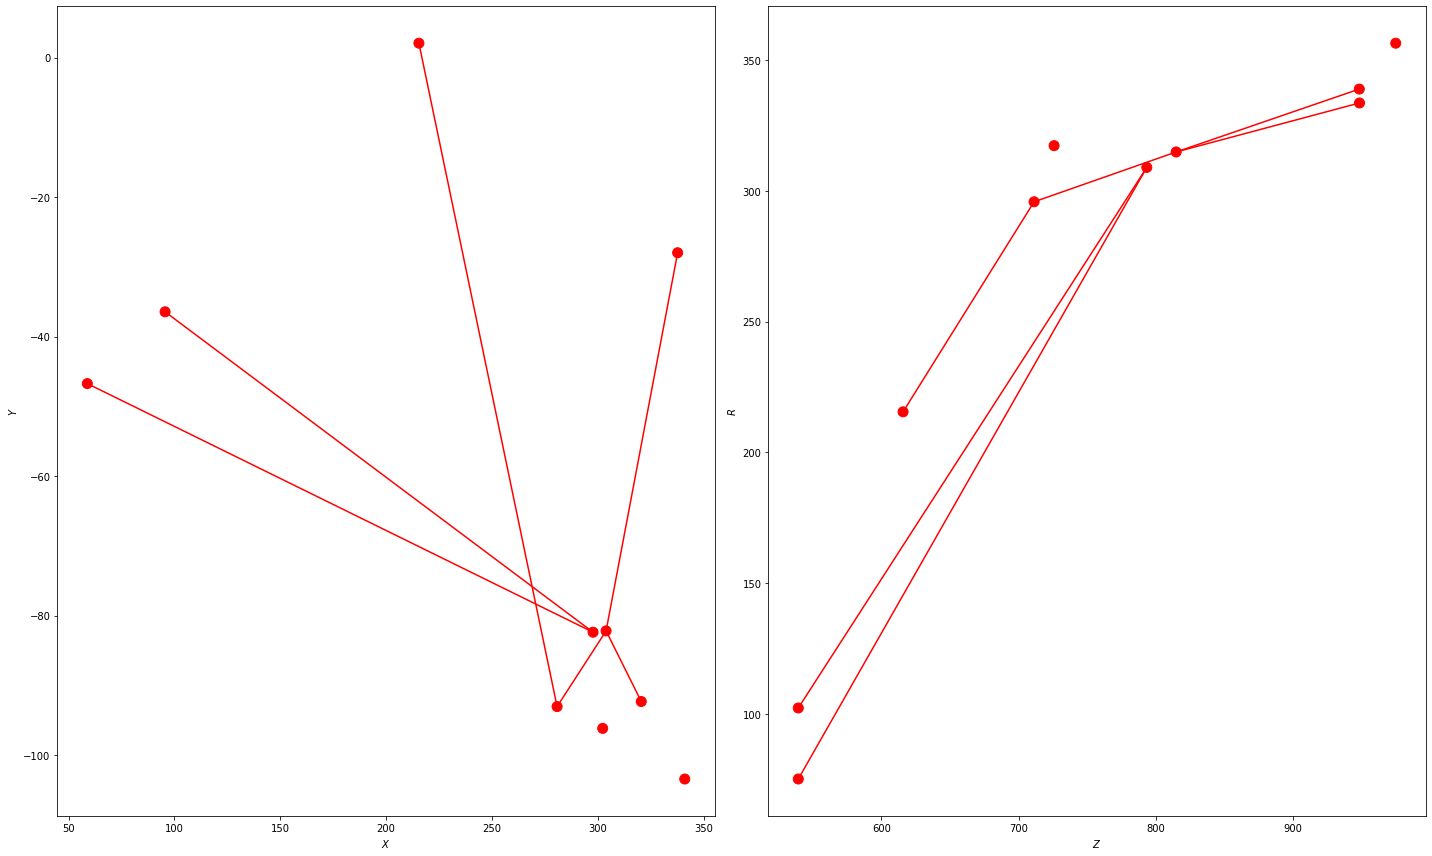

Event= 12    Sector= 2
   vh_layer  vh_type  vh_sector  vh_station   vh_sim_r    vh_sim_z
0        11      4.0        2.0         1.0  77.270645 -539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 12    Sector= 3
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        3.0         1.0  127.045387  -586.409485
1         0      1.0        3.0         1.0  140.139236  -586.458008
2         2      1.0        3.0         2.0  185.312546  -814.943787
3         3      1.0        3.0         3.0  219.005066  -948.921448
4         4      1.0        3.0         4.0  239.206818 -1038.184692
5         7      2.0        3.0         3.0  226.837631  -968.900024
6         8      2.0        3.0         4.0  242.205780 -1059.395020
7        11      4.0        3.0         1.0   77.270645  -539.349976
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], 

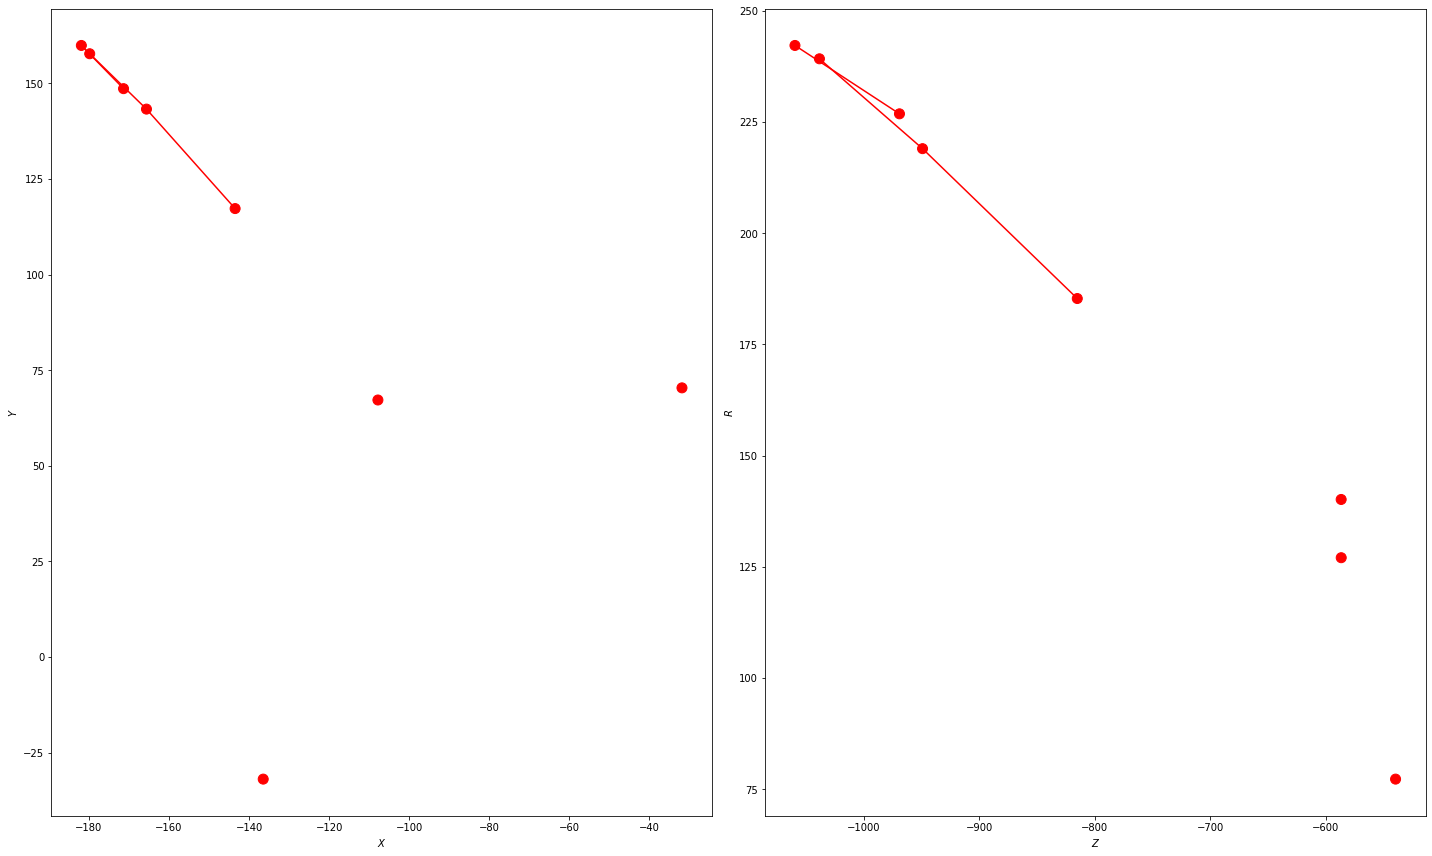

Event= 12    Sector= 4
    vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0          0      1.0        4.0         1.0  174.042496  -586.358337
1          0      1.0        4.0         1.0  131.702698  -615.649170
2          0      1.0        4.0         1.0  139.294495  -586.482788
3          0      1.0        4.0         1.0  140.139236  -586.458008
4          2      1.0        4.0         2.0  177.513000  -839.696045
5          3      1.0        4.0         3.0  181.798676  -924.208618
6          4      1.0        4.0         4.0  189.952118 -1013.622253
7          7      2.0        4.0         3.0  186.054733  -964.500000
8          8      2.0        4.0         4.0  268.239807 -1054.994995
9          8      2.0        4.0         4.0  195.249649 -1054.994995
10         8      2.0        4.0         4.0  197.900543 -1054.994995
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
len(segments)= 3
df_segments

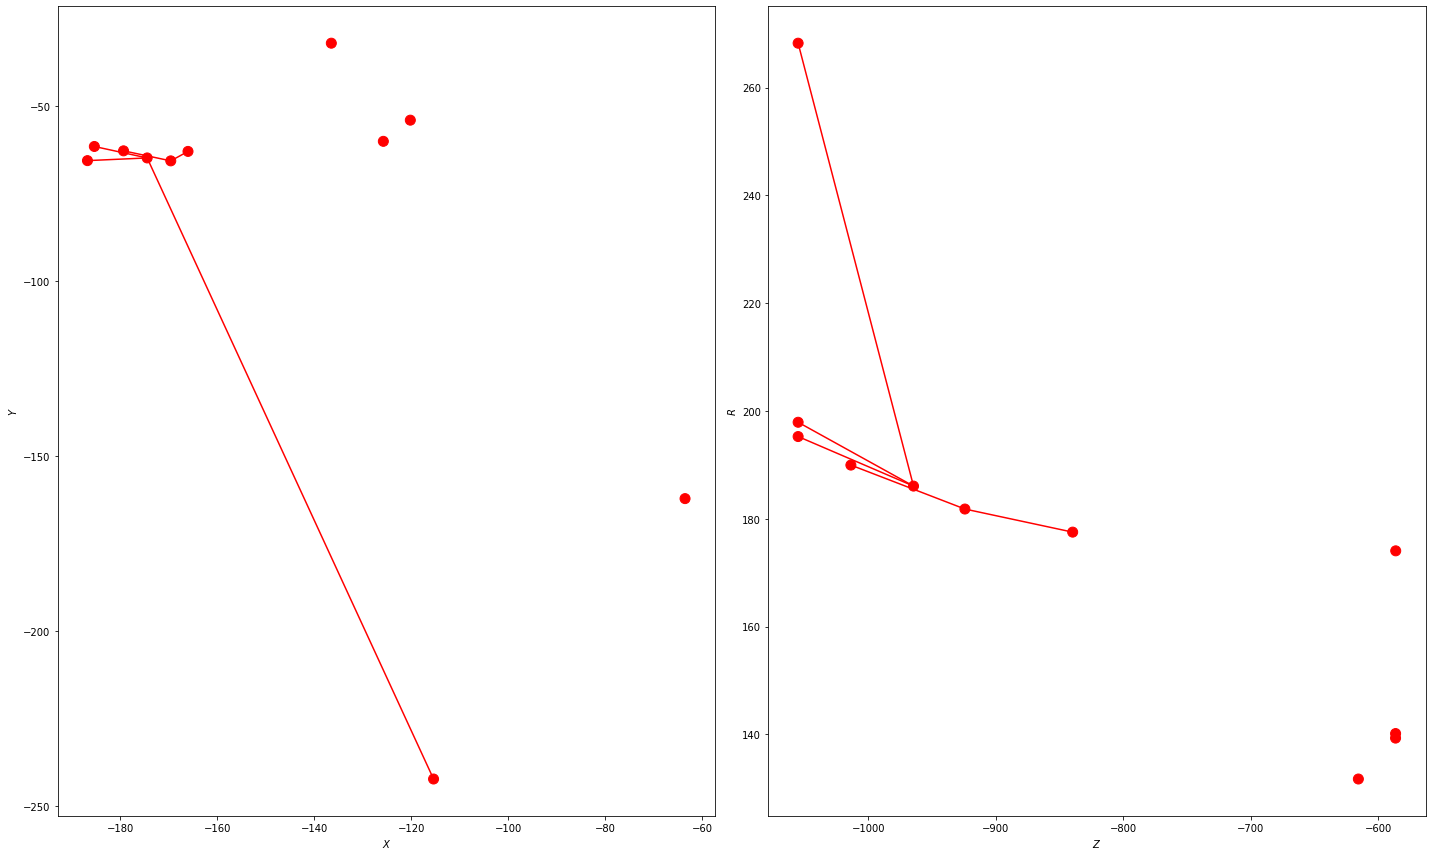

Event= 12    Sector= 5
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r     vh_sim_z
0         0      1.0        5.0         1.0  174.042496  -586.358337
1         0      1.0        5.0         1.0  115.377693  -586.367554
2         0      1.0        5.0         1.0  103.483788  -615.763000
3         0      1.0        5.0         1.0  154.583633  -615.726135
4         8      2.0        5.0         4.0  268.239807 -1054.994995
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 12    Sector= 6
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0       -99      0.0        6.0         1.0  447.381439 -533.300598
adj_layer_pairs= [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]]
Event= 12    Sector= 7
   vh_layer  vh_type  vh_sector  vh_station    vh_sim_r    vh_sim_z
0       -99      0.0        1.0         2.0  534.159485  533.289307
1         0      1.0       

KeyboardInterrupt: ignored

In [8]:
# Initialize the random number generator
print('Initializing random seed=1')
random.seed(1)

# Read all EVENTS into dataframes
df_events_mu , df_events_pu , df_muons_vp = readEvents()

# Get number of events in dataframes
nmu = len(df_events_mu)
npu = len(df_events_pu)

# Loop over muon events mu 
n_graphs=0
for imu, event_mu in df_events_mu.iterrows():
#for ievt, event_mu in df_events_mu.iterrows():

  # Pick a random pu event 
  ipu = random.randint(0,npu-1)
  event_pu = df_events_pu.iloc[ipu] 

  # Get HITS dataframe from merged muon and pileup events
  df_hits = getHits(event_mu, event_pu)
 
  # Create a list of HITS dataframe by detector Eta sign  and Phi sector
  hits_sectors = splitHits(df_hits)

  # Loop over list of HITS per sector
  for isec, df_hits_sec in enumerate(hits_sectors, start=1): 

    # Skip empty sectors
    if (len(df_hits_sec)==0):
#      print("Skipping empty sector",isec)
      continue
      
    print("Event=",imu,"   Sector=",isec)
    # Build SEGMENTS ( returns modified df_hits_sec and df_segments )
    df_segments = buildSegments(df_hits_sec)

    # Skip empty segments
    if ( len(df_segments)==0 ):
#      print("Skipping empty segments",isec)
      continue 

    # Build GRAPH
    graph = buildGraph(df_hits_sec,df_segments)

    # Convert GRAPH to a dictionary to save as NPZ
    gdic = dict(X=graph.X, Ri=graph.Ri, Ro=graph.Ro, y=graph.y)
    
    # Save GRAPH dictionary to a NPZ file
    n_graphs+=1
    outfile = data_dir+'/graphs/graph_'+str(n_graphs)+'.npz' 
    np.savez(outfile,**gdic)

    # Visualize the graphs
    print("Event=",imu,"   Sector=",isec)
    draw_sample(graph.X*feature_scale,graph.Ri, graph.Ro, graph.y)

    # Convert to SPARSE GRAPHS and save to NPZ file
#    sparse_graph = graph_to_sparse(graph) 
#    outfile = data_dir+'/graphs/sgraph_'+str(imu)+'.npz' 
#    np.savez(outfile,**sparse_graph)

    # End loop over hits per sector
  # End loop over events

